<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1527, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1527 (delta 49), reused 42 (delta 20), pack-reused 1444 (from 1)
Receiving objects: 100% (1527/1527), 16.27 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (1032/1032), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits, get_liver_mask
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_2

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
0.51% complete (down: 8038.2 kB/s up: 229.7 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php

## Model

In [6]:
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [7]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)

In [8]:
liver_masks = get_liver_mask(config["source_folder_lits"], model_stage_1, device)

## Load data

In [ ]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="tumor", liver_masks = liver_masks)
print(len(full_train_dataset), len(val_dataset))

105 26


In [ ]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor):
    """
    Visualize 3D volume (from DataLoader) using Max Intensity Projection (MIP)

    Args:
        image_tensor: Tensor, shape [1, 1, D, H, W]
        label_tensor: Tensor, shape [1, 1, D, H, W]

    Notes:
        - Converts to numpy
        - Projects to 2D using max projection along depth
    """

    # Convert to numpy, squeeze to shape [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze()
    label = label_tensor.detach().cpu().numpy().squeeze()

    # Max projection along depth
    image_2d = np.max(image, axis=0)
    label_2d = np.max(label, axis=0)

    # Color map for tumor mask
    cmap = mcolors.ListedColormap(["black", "yellow"])

    # Plotting
    num_cols = 2
    plt.figure(figsize=(5 * num_cols, 5))

    plt.subplot(1, num_cols, 1)
    plt.title("Input Image (MIP)")
    plt.imshow(image_2d, cmap='gray')
    plt.axis("off")

    plt.subplot(1, num_cols, 2)
    plt.title("Ground Truth (Tumor MIP)")
    plt.imshow(image_2d, cmap='gray')
    plt.imshow(label_2d, cmap=cmap, alpha=0.5)
    plt.axis("off")


    plt.tight_layout()
    plt.show()


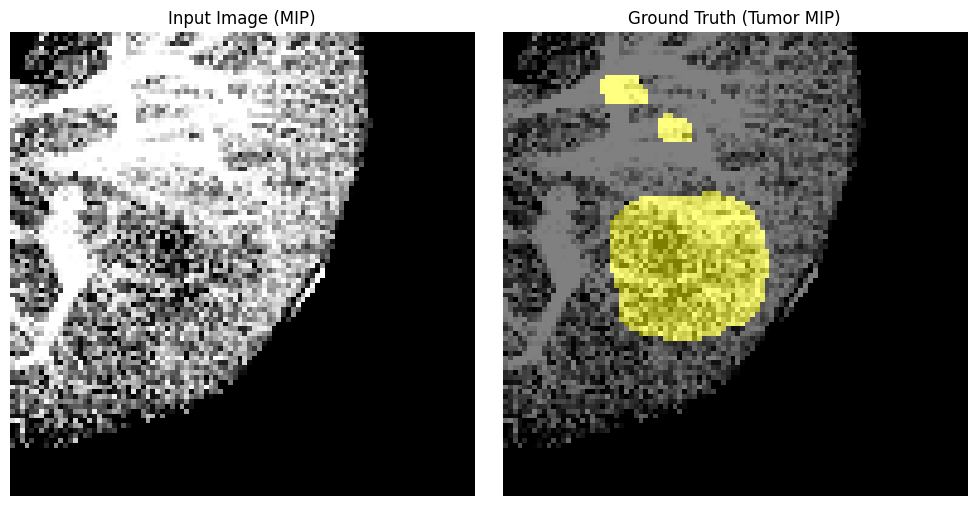

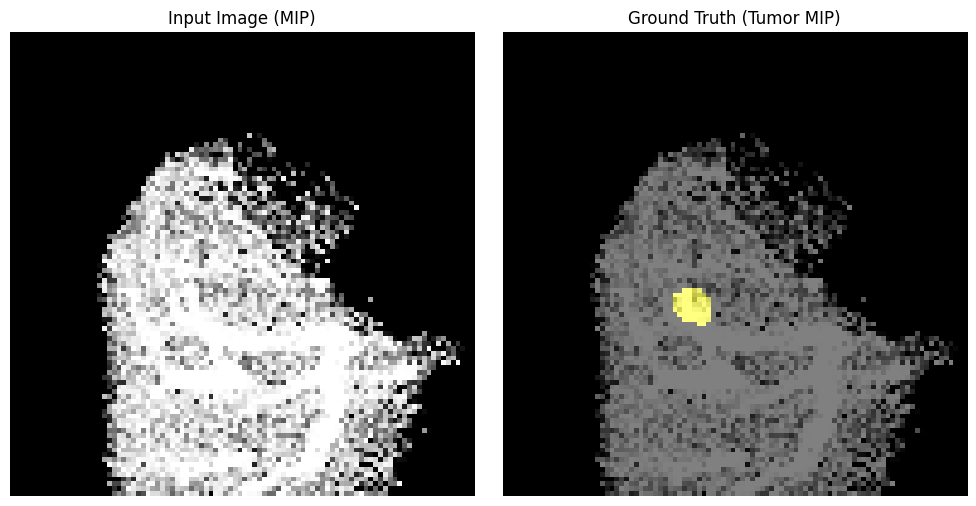

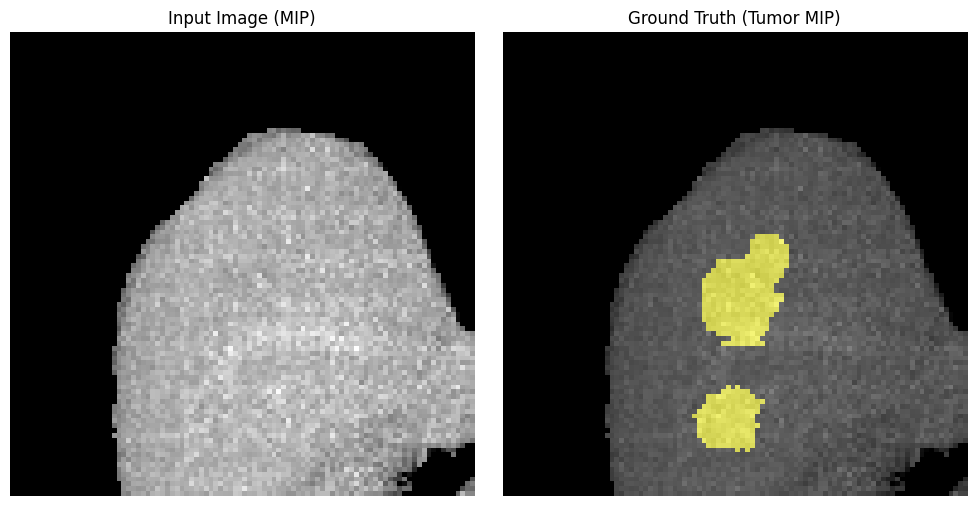

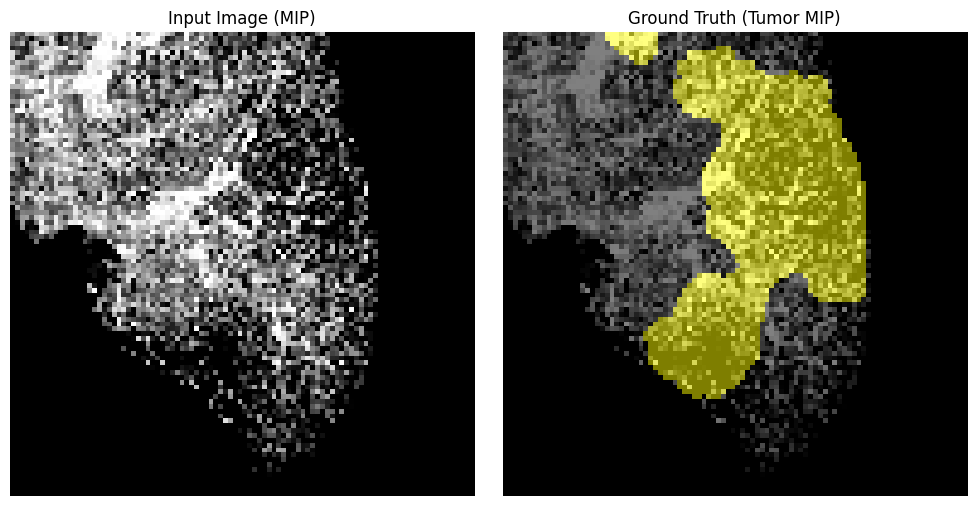

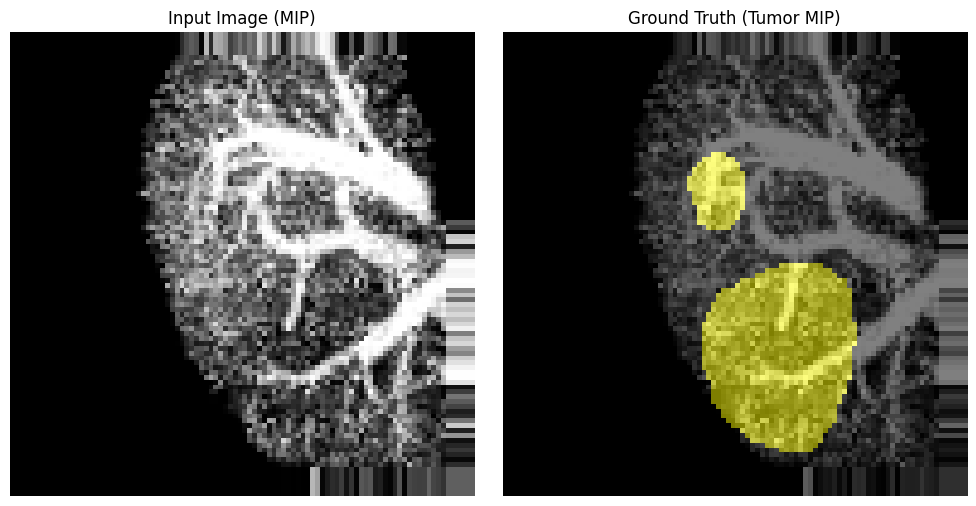

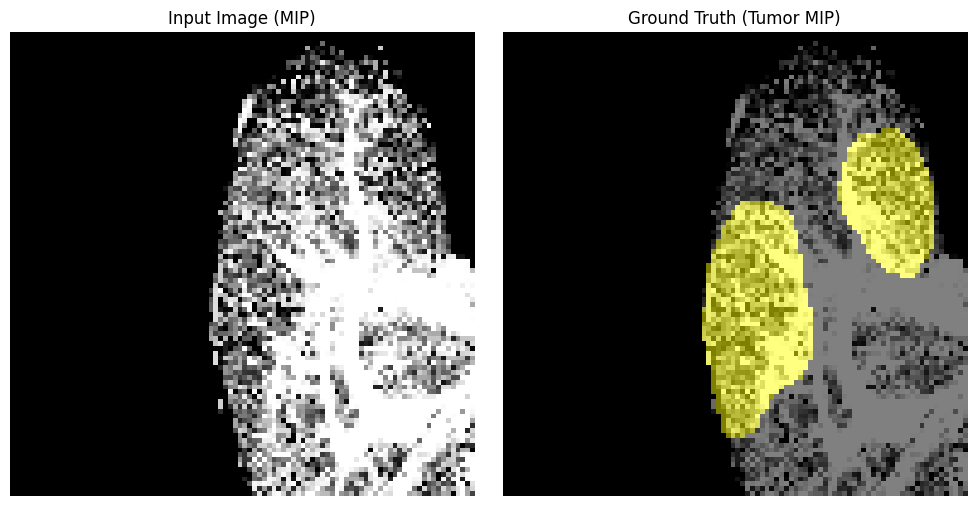

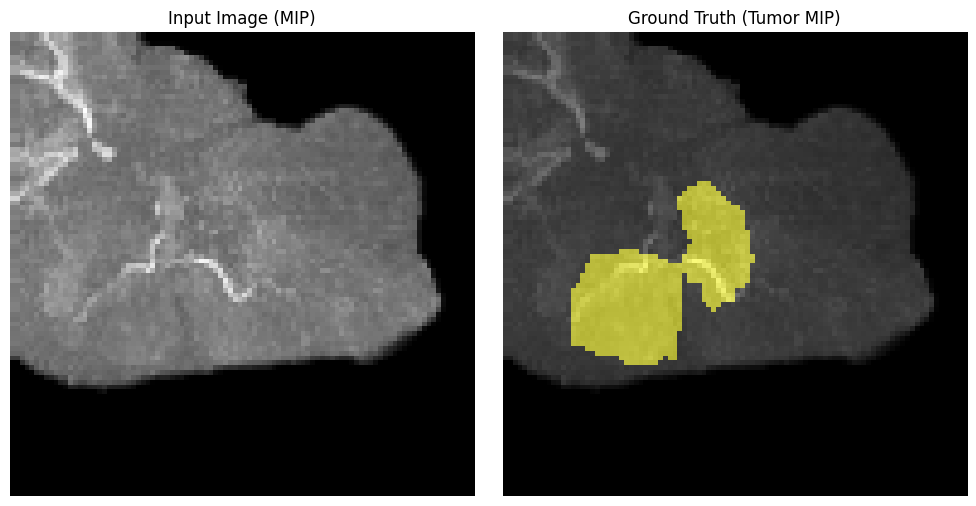

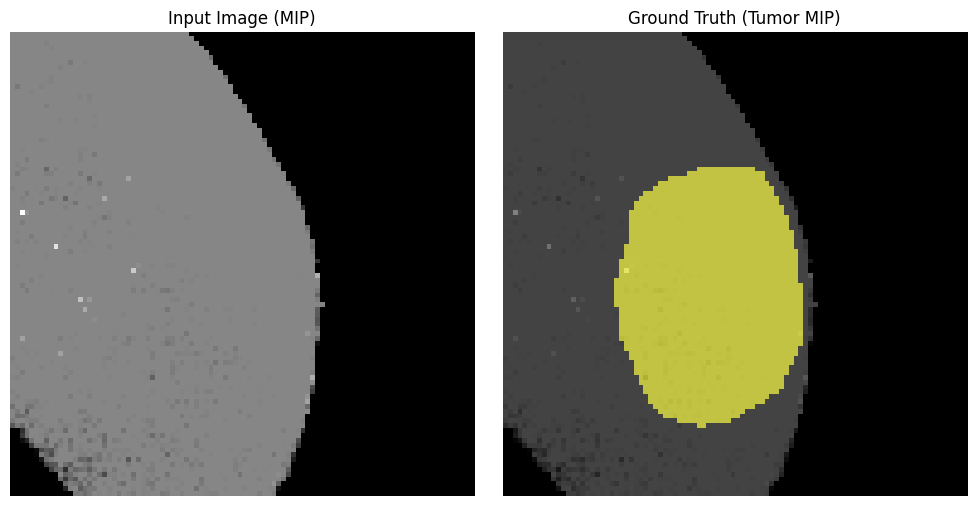

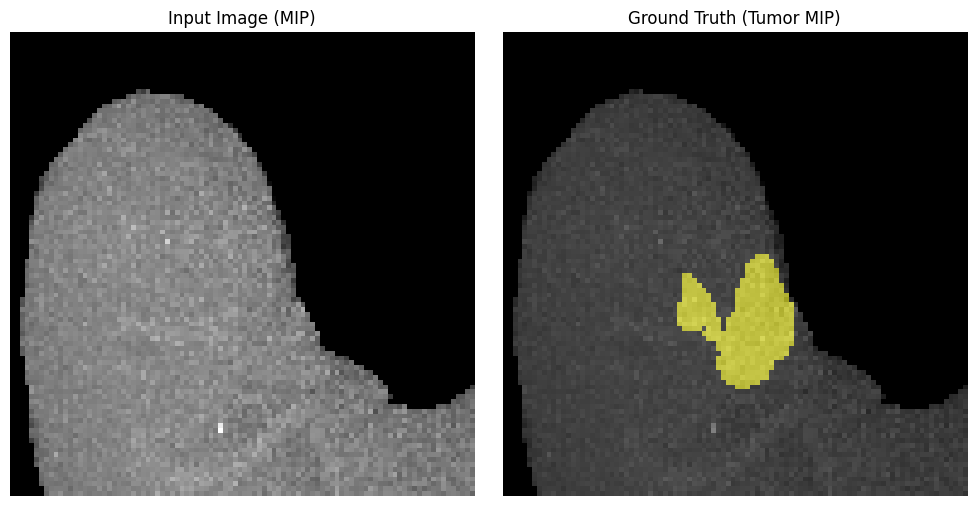

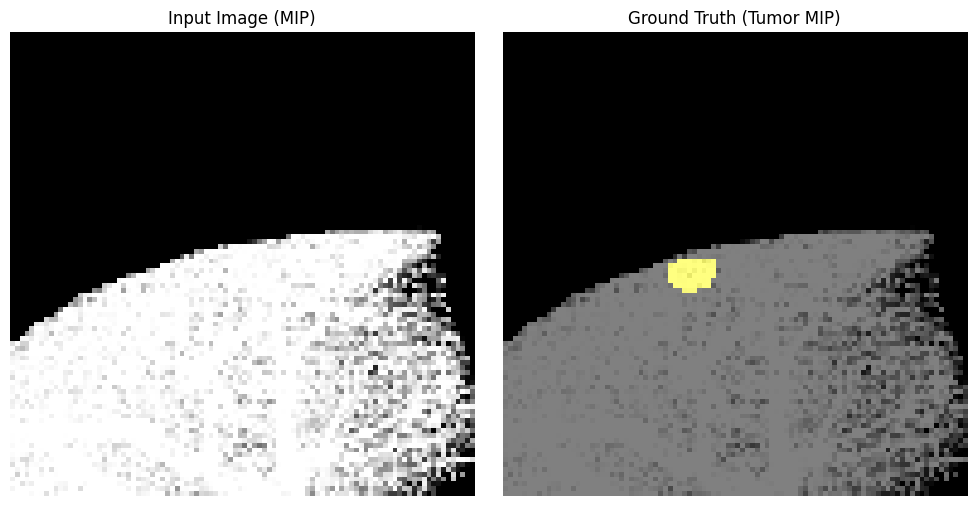

In [ ]:
i = 0
for train_data in train_loader:
    i+= 1
    image = train_data["image"]
    label = train_data["label"]

    visualize_from_loader(image, label)
    if i == 10:
      break

## Training

In [ ]:
criterion = TverskyLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate_train"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="tumor"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 1.1628 time 6.78s
Epoch 1/100 2/105 loss: 1.1043 time 9.02s
Epoch 1/100 3/105 loss: 1.0814 time 3.06s
Epoch 1/100 4/105 loss: 1.0991 time 4.92s
Epoch 1/100 5/105 loss: 1.0960 time 1.50s
Epoch 1/100 6/105 loss: 1.1095 time 5.57s
Epoch 1/100 7/105 loss: 1.1200 time 1.40s
Epoch 1/100 8/105 loss: 1.1189 time 9.32s
Epoch 1/100 9/105 loss: 1.1206 time 4.22s
Epoch 1/100 10/105 loss: 1.1203 time 1.56s
Epoch 1/100 11/105 loss: 1.1140 time 1.58s
Epoch 1/100 12/105 loss: 1.1144 time 3.42s
Epoch 1/100 13/105 loss: 1.1062 time 23.71s
Epoch 1/100 14/105 loss: 1.1082 time 5.43s
Epoch 1/100 15/105 loss: 1.1081 time 3.98s
Epoch 1/100 16/105 loss: 1.1091 time 1.57s
Epoch 1/100 17/105 loss: 1.1093 time 1.62s
Epoch 1/100 18/105 loss: 1.1110 time 4.95s
Epoch 1/100 19/105 loss: 1.1110 time 1.56s
Epoch 1/100 20/105 loss: 1.1103 time 3.48s
Epoch 1/100 21/105 loss: 1.1105 time 7.15s
Epoch 1/100 22/105 loss: 1.1098 time 8.86s
Epoch 1/100 23/105 loss: 1.1081 time 1.38s
Epoch 1/100 24/105 

Final training epochs: 1/100 ---[loss: 1.0087] ---[time 511.28s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 1.0087] ---[time 511.28s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 1.0087 time 6.40s


Val 1/100 1/26, Dice_Tumor: 0.000581, time 2.63s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Tumor: 0.000581, time 2.63s
Val 1/100 2/26, Dice_Tumor: 0.031107, time 6.39s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Tumor: 0.031107, time 6.39s
Val 1/100 3/26, Dice_Tumor: 0.006166, time 5.99s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Tumor: 0.006166, time 5.99s
Val 1/100 4/26, Dice_Tumor: 0.000000, time 5.84s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Tumor: 0.000000, time 5.84s
Val 1/100 5/26, Dice_Tumor: 0.048118, time 7.39s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Tumor: 0.048118, time 7.39s
Val 1/100 6/26, Dice_Tumor: 0.006663, time 2.27s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Tumor: 0.006663, time 2.27s
Val 1/100 7/26, Dice_Tumor: 0.012155, time 7.17s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Tumor: 0.012155, time 7.17s
Val 1/100 8/26, Dice_Tumor: 0.000162, time 6.36s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Tumor: 0.000162, time 6.36s
Val 1/100 9/26, Dice_Tumor: 0.00

New best (0.000000 --> 0.017165). At epoch 1
Epoch 2/100 1/105 loss: 0.9262 time 2.18s
Epoch 2/100 2/105 loss: 0.8870 time 3.68s
Epoch 2/100 3/105 loss: 0.8963 time 7.16s
Epoch 2/100 4/105 loss: 0.8981 time 1.43s
Epoch 2/100 5/105 loss: 0.8997 time 12.22s
Epoch 2/100 6/105 loss: 0.9038 time 3.29s
Epoch 2/100 7/105 loss: 0.9065 time 8.03s
Epoch 2/100 8/105 loss: 0.9019 time 2.65s
Epoch 2/100 9/105 loss: 0.9039 time 3.38s
Epoch 2/100 10/105 loss: 0.9046 time 3.89s
Epoch 2/100 11/105 loss: 0.9002 time 14.66s
Epoch 2/100 12/105 loss: 0.9009 time 3.01s
Epoch 2/100 13/105 loss: 0.8959 time 9.20s
Epoch 2/100 14/105 loss: 0.8962 time 9.55s
Epoch 2/100 15/105 loss: 0.8973 time 5.31s
Epoch 2/100 16/105 loss: 0.8990 time 10.03s
Epoch 2/100 17/105 loss: 0.8948 time 7.12s
Epoch 2/100 18/105 loss: 0.8911 time 1.63s
Epoch 2/100 19/105 loss: 0.8916 time 5.10s
Epoch 2/100 20/105 loss: 0.8925 time 6.86s
Epoch 2/100 21/105 loss: 0.8932 time 7.89s
Epoch 2/100 22/105 loss: 0.8932 time 1.45s
Epoch 2/100 23/

Final training epochs: 2/100 ---[loss: 0.8522] ---[time 552.21s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.8522] ---[time 552.21s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.8522 time 1.46s


Val 2/100 1/26, Dice_Tumor: 0.000180, time 2.73s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Tumor: 0.000180, time 2.73s
Val 2/100 2/26, Dice_Tumor: 0.149853, time 6.41s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Tumor: 0.149853, time 6.41s
Val 2/100 3/26, Dice_Tumor: 0.041748, time 5.48s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Tumor: 0.041748, time 5.48s
Val 2/100 4/26, Dice_Tumor: 0.000000, time 6.18s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Tumor: 0.000000, time 6.18s
Val 2/100 5/26, Dice_Tumor: 0.032577, time 6.60s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Tumor: 0.032577, time 6.60s
Val 2/100 6/26, Dice_Tumor: 0.007501, time 2.83s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Tumor: 0.007501, time 2.83s
Val 2/100 7/26, Dice_Tumor: 0.000181, time 7.54s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Tumor: 0.000181, time 7.54s
Val 2/100 8/26, Dice_Tumor: 0.000000, time 6.81s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Tumor: 0.000000, time 6.81s
Val 2/100 9/26, Dice_Tumor: 0.02

New best (0.017165 --> 0.017431). At epoch 2
Epoch 3/100 1/105 loss: 0.8039 time 6.86s
Epoch 3/100 2/105 loss: 0.7976 time 4.96s
Epoch 3/100 3/105 loss: 0.8013 time 2.14s
Epoch 3/100 4/105 loss: 0.7892 time 1.62s
Epoch 3/100 5/105 loss: 0.7860 time 2.05s
Epoch 3/100 6/105 loss: 0.7887 time 10.29s
Epoch 3/100 7/105 loss: 0.7912 time 7.71s
Epoch 3/100 8/105 loss: 0.7925 time 3.18s
Epoch 3/100 9/105 loss: 0.7850 time 1.42s
Epoch 3/100 10/105 loss: 0.7860 time 4.29s
Epoch 3/100 11/105 loss: 0.7872 time 1.35s
Epoch 3/100 12/105 loss: 0.7885 time 3.29s
Epoch 3/100 13/105 loss: 0.7893 time 6.90s
Epoch 3/100 14/105 loss: 0.7899 time 7.01s
Epoch 3/100 15/105 loss: 0.7908 time 1.81s
Epoch 3/100 16/105 loss: 0.7904 time 10.12s
Epoch 3/100 17/105 loss: 0.7908 time 4.99s
Epoch 3/100 18/105 loss: 0.7899 time 5.52s
Epoch 3/100 19/105 loss: 0.7877 time 6.01s
Epoch 3/100 20/105 loss: 0.7880 time 5.13s
Epoch 3/100 21/105 loss: 0.7881 time 3.54s
Epoch 3/100 22/105 loss: 0.7886 time 1.20s
Epoch 3/100 23/1

Final training epochs: 3/100 ---[loss: 0.7630] ---[time 538.35s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.7630] ---[time 538.35s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.7630 time 5.13s


Val 3/100 1/26, Dice_Tumor: 0.000000, time 2.81s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Tumor: 0.000000, time 2.81s
Val 3/100 2/26, Dice_Tumor: 0.306594, time 7.12s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Tumor: 0.306594, time 7.12s
Val 3/100 3/26, Dice_Tumor: 0.014170, time 5.92s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Tumor: 0.014170, time 5.92s
Val 3/100 4/26, Dice_Tumor: 0.000000, time 6.89s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Tumor: 0.000000, time 6.89s
Val 3/100 5/26, Dice_Tumor: 0.045569, time 5.98s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Tumor: 0.045569, time 5.98s
Val 3/100 6/26, Dice_Tumor: 0.000000, time 2.37s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Tumor: 0.000000, time 2.37s
Val 3/100 7/26, Dice_Tumor: 0.000243, time 7.64s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Tumor: 0.000243, time 7.64s
Val 3/100 8/26, Dice_Tumor: 0.000000, time 5.97s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Tumor: 0.000000, time 5.97s
Val 3/100 9/26, Dice_Tumor: 0.00

New best (0.017431 --> 0.020467). At epoch 3
Epoch 4/100 1/105 loss: 0.7676 time 2.19s
Epoch 4/100 2/105 loss: 0.7387 time 9.92s
Epoch 4/100 3/105 loss: 0.7465 time 4.56s
Epoch 4/100 4/105 loss: 0.7418 time 6.66s
Epoch 4/100 5/105 loss: 0.7458 time 5.06s
Epoch 4/100 6/105 loss: 0.7302 time 1.45s
Epoch 4/100 7/105 loss: 0.7337 time 5.32s
Epoch 4/100 8/105 loss: 0.7373 time 8.39s
Epoch 4/100 9/105 loss: 0.7380 time 11.99s
Epoch 4/100 10/105 loss: 0.7409 time 5.12s
Epoch 4/100 11/105 loss: 0.7427 time 1.35s
Epoch 4/100 12/105 loss: 0.7444 time 6.78s
Epoch 4/100 13/105 loss: 0.7463 time 5.17s
Epoch 4/100 14/105 loss: 0.7461 time 3.45s
Epoch 4/100 15/105 loss: 0.7472 time 5.19s
Epoch 4/100 16/105 loss: 0.7477 time 5.27s
Epoch 4/100 17/105 loss: 0.7457 time 2.78s
Epoch 4/100 18/105 loss: 0.7464 time 5.60s
Epoch 4/100 19/105 loss: 0.7473 time 2.32s
Epoch 4/100 20/105 loss: 0.7482 time 6.72s
Epoch 4/100 21/105 loss: 0.7488 time 2.08s
Epoch 4/100 22/105 loss: 0.7465 time 5.74s
Epoch 4/100 23/10

Final training epochs: 4/100 ---[loss: 0.7272] ---[time 534.25s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.7272] ---[time 534.25s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.7272 time 1.23s


Val 4/100 1/26, Dice_Tumor: 0.000000, time 3.41s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Tumor: 0.000000, time 3.41s
Val 4/100 2/26, Dice_Tumor: 0.360029, time 6.51s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Tumor: 0.360029, time 6.51s
Val 4/100 3/26, Dice_Tumor: 0.000000, time 5.89s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Tumor: 0.000000, time 5.89s
Val 4/100 4/26, Dice_Tumor: 0.000000, time 6.08s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Tumor: 0.000000, time 6.08s
Val 4/100 5/26, Dice_Tumor: 0.107520, time 6.35s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Tumor: 0.107520, time 6.35s
Val 4/100 6/26, Dice_Tumor: 0.000000, time 2.75s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Tumor: 0.000000, time 2.75s
Val 4/100 7/26, Dice_Tumor: 0.060493, time 7.17s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Tumor: 0.060493, time 7.17s
Val 4/100 8/26, Dice_Tumor: 0.000000, time 7.22s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Tumor: 0.000000, time 7.22s
Val 4/100 9/26, Dice_Tumor: 0.00

New best (0.020467 --> 0.034746). At epoch 4
Epoch 5/100 1/105 loss: 0.7576 time 1.66s
Epoch 5/100 2/105 loss: 0.7566 time 1.16s
Epoch 5/100 3/105 loss: 0.7524 time 8.59s
Epoch 5/100 4/105 loss: 0.7541 time 2.14s
Epoch 5/100 5/105 loss: 0.7514 time 4.10s
Epoch 5/100 6/105 loss: 0.7521 time 1.90s
Epoch 5/100 7/105 loss: 0.7517 time 3.23s
Epoch 5/100 8/105 loss: 0.7333 time 8.51s
Epoch 5/100 9/105 loss: 0.7335 time 6.96s
Epoch 5/100 10/105 loss: 0.7355 time 1.89s
Epoch 5/100 11/105 loss: 0.7355 time 6.20s
Epoch 5/100 12/105 loss: 0.7166 time 16.96s
Epoch 5/100 13/105 loss: 0.7113 time 2.07s
Epoch 5/100 14/105 loss: 0.7060 time 9.12s
Epoch 5/100 15/105 loss: 0.7089 time 6.60s
Epoch 5/100 16/105 loss: 0.7116 time 3.91s
Epoch 5/100 17/105 loss: 0.7135 time 7.17s
Epoch 5/100 18/105 loss: 0.7156 time 1.89s
Epoch 5/100 19/105 loss: 0.7167 time 7.32s
Epoch 5/100 20/105 loss: 0.7118 time 2.65s
Epoch 5/100 21/105 loss: 0.7137 time 11.21s
Epoch 5/100 22/105 loss: 0.7116 time 1.44s
Epoch 5/100 23/1

Final training epochs: 5/100 ---[loss: 0.7027] ---[time 538.47s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.7027] ---[time 538.47s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.7027 time 5.71s


Val 5/100 1/26, Dice_Tumor: 0.000000, time 2.90s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Tumor: 0.000000, time 2.90s
Val 5/100 2/26, Dice_Tumor: 0.446881, time 6.48s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Tumor: 0.446881, time 6.48s
Val 5/100 3/26, Dice_Tumor: 0.025679, time 6.22s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Tumor: 0.025679, time 6.22s
Val 5/100 4/26, Dice_Tumor: 0.000000, time 5.99s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Tumor: 0.000000, time 5.99s
Val 5/100 5/26, Dice_Tumor: 0.314168, time 5.85s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Tumor: 0.314168, time 5.85s
Val 5/100 6/26, Dice_Tumor: 0.080774, time 2.53s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Tumor: 0.080774, time 2.53s
Val 5/100 7/26, Dice_Tumor: 0.001046, time 7.82s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Tumor: 0.001046, time 7.82s
Val 5/100 8/26, Dice_Tumor: 0.000000, time 6.36s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Tumor: 0.000000, time 6.36s
Val 5/100 9/26, Dice_Tumor: 0.00

New best (0.034746 --> 0.070732). At epoch 5
Epoch 6/100 1/105 loss: 0.7386 time 1.66s
Epoch 6/100 2/105 loss: 0.6830 time 6.02s
Epoch 6/100 3/105 loss: 0.6990 time 1.77s
Epoch 6/100 4/105 loss: 0.7091 time 1.71s
Epoch 6/100 5/105 loss: 0.7010 time 1.38s
Epoch 6/100 6/105 loss: 0.7072 time 6.84s
Epoch 6/100 7/105 loss: 0.7122 time 6.52s
Epoch 6/100 8/105 loss: 0.7161 time 8.55s
Epoch 6/100 9/105 loss: 0.7198 time 1.42s
Epoch 6/100 10/105 loss: 0.7150 time 6.44s
Epoch 6/100 11/105 loss: 0.7170 time 4.97s
Epoch 6/100 12/105 loss: 0.7065 time 10.47s
Epoch 6/100 13/105 loss: 0.7094 time 7.86s
Epoch 6/100 14/105 loss: 0.7115 time 5.80s
Epoch 6/100 15/105 loss: 0.7111 time 5.85s
Epoch 6/100 16/105 loss: 0.7049 time 8.59s
Epoch 6/100 17/105 loss: 0.7071 time 6.65s
Epoch 6/100 18/105 loss: 0.7087 time 2.15s
Epoch 6/100 19/105 loss: 0.7106 time 3.67s
Epoch 6/100 20/105 loss: 0.7121 time 1.19s
Epoch 6/100 21/105 loss: 0.7133 time 5.32s
Epoch 6/100 22/105 loss: 0.7079 time 5.41s
Epoch 6/100 23/10

Final training epochs: 6/100 ---[loss: 0.6828] ---[time 561.20s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.6828] ---[time 561.20s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.6828 time 1.74s


Val 6/100 1/26, Dice_Tumor: 0.000000, time 2.69s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Tumor: 0.000000, time 2.69s
Val 6/100 2/26, Dice_Tumor: 0.199915, time 6.29s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Tumor: 0.199915, time 6.29s
Val 6/100 3/26, Dice_Tumor: 0.001650, time 6.76s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Tumor: 0.001650, time 6.76s
Val 6/100 4/26, Dice_Tumor: 0.000000, time 5.94s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Tumor: 0.000000, time 5.94s
Val 6/100 5/26, Dice_Tumor: 0.127582, time 6.77s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Tumor: 0.127582, time 6.77s
Val 6/100 6/26, Dice_Tumor: 0.116881, time 2.42s
INFO:kltn.utils.logger:Val 6/100 6/26, Dice_Tumor: 0.116881, time 2.42s
Val 6/100 7/26, Dice_Tumor: 0.055048, time 7.80s
INFO:kltn.utils.logger:Val 6/100 7/26, Dice_Tumor: 0.055048, time 7.80s
Val 6/100 8/26, Dice_Tumor: 0.000000, time 6.25s
INFO:kltn.utils.logger:Val 6/100 8/26, Dice_Tumor: 0.000000, time 6.25s
Val 6/100 9/26, Dice_Tumor: 0.00

Epoch 7/100 1/105 loss: 0.7302 time 1.16s
Epoch 7/100 2/105 loss: 0.6916 time 6.09s
Epoch 7/100 3/105 loss: 0.7073 time 6.39s
Epoch 7/100 4/105 loss: 0.7120 time 6.73s
Epoch 7/100 5/105 loss: 0.6627 time 3.42s
Epoch 7/100 6/105 loss: 0.6528 time 16.24s
Epoch 7/100 7/105 loss: 0.6663 time 1.21s
Epoch 7/100 8/105 loss: 0.6731 time 4.76s
Epoch 7/100 9/105 loss: 0.6760 time 4.92s
Epoch 7/100 10/105 loss: 0.6812 time 1.90s
Epoch 7/100 11/105 loss: 0.6839 time 1.40s
Epoch 7/100 12/105 loss: 0.6884 time 1.96s
Epoch 7/100 13/105 loss: 0.6915 time 2.24s
Epoch 7/100 14/105 loss: 0.6823 time 7.08s
Epoch 7/100 15/105 loss: 0.6830 time 6.83s
Epoch 7/100 16/105 loss: 0.6862 time 5.51s
Epoch 7/100 17/105 loss: 0.6698 time 27.46s
Epoch 7/100 18/105 loss: 0.6730 time 7.58s
Epoch 7/100 19/105 loss: 0.6770 time 1.35s
Epoch 7/100 20/105 loss: 0.6799 time 4.04s
Epoch 7/100 21/105 loss: 0.6799 time 7.47s
Epoch 7/100 22/105 loss: 0.6710 time 5.09s
Epoch 7/100 23/105 loss: 0.6741 time 2.26s
Epoch 7/100 24/105

Final training epochs: 7/100 ---[loss: 0.6714] ---[time 558.10s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.6714] ---[time 558.10s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.6714 time 4.62s


Val 7/100 1/26, Dice_Tumor: 0.000000, time 2.73s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Tumor: 0.000000, time 2.73s
Val 7/100 2/26, Dice_Tumor: 0.210043, time 7.35s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Tumor: 0.210043, time 7.35s
Val 7/100 3/26, Dice_Tumor: 0.025252, time 5.89s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Tumor: 0.025252, time 5.89s
Val 7/100 4/26, Dice_Tumor: 0.000000, time 6.83s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Tumor: 0.000000, time 6.83s
Val 7/100 5/26, Dice_Tumor: 0.040437, time 6.19s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Tumor: 0.040437, time 6.19s
Val 7/100 6/26, Dice_Tumor: 0.065030, time 2.28s
INFO:kltn.utils.logger:Val 7/100 6/26, Dice_Tumor: 0.065030, time 2.28s
Val 7/100 7/26, Dice_Tumor: 0.289783, time 7.66s
INFO:kltn.utils.logger:Val 7/100 7/26, Dice_Tumor: 0.289783, time 7.66s
Val 7/100 8/26, Dice_Tumor: 0.000000, time 5.57s
INFO:kltn.utils.logger:Val 7/100 8/26, Dice_Tumor: 0.000000, time 5.57s
Val 7/100 9/26, Dice_Tumor: 0.00

New best (0.070732 --> 0.093896). At epoch 7
Epoch 8/100 1/105 loss: 0.6862 time 12.23s
Epoch 8/100 2/105 loss: 0.6244 time 2.78s
Epoch 8/100 3/105 loss: 0.6618 time 7.32s
Epoch 8/100 4/105 loss: 0.6009 time 2.65s
Epoch 8/100 5/105 loss: 0.6270 time 3.44s
Epoch 8/100 6/105 loss: 0.6145 time 1.53s
Epoch 8/100 7/105 loss: 0.6197 time 7.28s
Epoch 8/100 8/105 loss: 0.6208 time 1.48s
Epoch 8/100 9/105 loss: 0.6055 time 5.60s
Epoch 8/100 10/105 loss: 0.6080 time 6.26s
Epoch 8/100 11/105 loss: 0.6187 time 5.41s
Epoch 8/100 12/105 loss: 0.6278 time 6.62s
Epoch 8/100 13/105 loss: 0.6225 time 6.28s
Epoch 8/100 14/105 loss: 0.6303 time 6.63s
Epoch 8/100 15/105 loss: 0.6369 time 6.20s
Epoch 8/100 16/105 loss: 0.6405 time 4.92s
Epoch 8/100 17/105 loss: 0.6461 time 5.60s
Epoch 8/100 18/105 loss: 0.6504 time 1.13s
Epoch 8/100 19/105 loss: 0.6366 time 6.04s
Epoch 8/100 20/105 loss: 0.6414 time 1.90s
Epoch 8/100 21/105 loss: 0.6453 time 1.65s
Epoch 8/100 22/105 loss: 0.6445 time 2.93s
Epoch 8/100 23/10

Final training epochs: 8/100 ---[loss: 0.6472] ---[time 544.60s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.6472] ---[time 544.60s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.6472 time 1.91s


Val 8/100 1/26, Dice_Tumor: 0.000000, time 2.65s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Tumor: 0.000000, time 2.65s
Val 8/100 2/26, Dice_Tumor: 0.179380, time 6.43s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Tumor: 0.179380, time 6.43s
Val 8/100 3/26, Dice_Tumor: 0.086461, time 6.27s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Tumor: 0.086461, time 6.27s
Val 8/100 4/26, Dice_Tumor: 0.000000, time 6.19s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Tumor: 0.000000, time 6.19s
Val 8/100 5/26, Dice_Tumor: 0.457473, time 6.06s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Tumor: 0.457473, time 6.06s
Val 8/100 6/26, Dice_Tumor: 0.084119, time 2.64s
INFO:kltn.utils.logger:Val 8/100 6/26, Dice_Tumor: 0.084119, time 2.64s
Val 8/100 7/26, Dice_Tumor: 0.000000, time 7.35s
INFO:kltn.utils.logger:Val 8/100 7/26, Dice_Tumor: 0.000000, time 7.35s
Val 8/100 8/26, Dice_Tumor: 0.000000, time 6.90s
INFO:kltn.utils.logger:Val 8/100 8/26, Dice_Tumor: 0.000000, time 6.90s
Val 8/100 9/26, Dice_Tumor: 0.00

Epoch 9/100 1/105 loss: 0.6235 time 6.33s
Epoch 9/100 2/105 loss: 0.6727 time 2.59s
Epoch 9/100 3/105 loss: 0.6338 time 9.34s
Epoch 9/100 4/105 loss: 0.6565 time 7.69s
Epoch 9/100 5/105 loss: 0.6708 time 3.25s
Epoch 9/100 6/105 loss: 0.6367 time 1.56s
Epoch 9/100 7/105 loss: 0.6530 time 3.64s
Epoch 9/100 8/105 loss: 0.6475 time 7.91s
Epoch 9/100 9/105 loss: 0.6566 time 7.52s
Epoch 9/100 10/105 loss: 0.6637 time 8.15s
Epoch 9/100 11/105 loss: 0.6557 time 12.01s
Epoch 9/100 12/105 loss: 0.6626 time 1.60s
Epoch 9/100 13/105 loss: 0.6566 time 2.75s
Epoch 9/100 14/105 loss: 0.6586 time 5.79s
Epoch 9/100 15/105 loss: 0.6612 time 2.49s
Epoch 9/100 16/105 loss: 0.6451 time 5.03s
Epoch 9/100 17/105 loss: 0.6395 time 3.75s
Epoch 9/100 18/105 loss: 0.6205 time 29.35s
Epoch 9/100 19/105 loss: 0.6259 time 4.13s
Epoch 9/100 20/105 loss: 0.6309 time 6.09s
Epoch 9/100 21/105 loss: 0.6343 time 10.13s
Epoch 9/100 22/105 loss: 0.6384 time 5.55s
Epoch 9/100 23/105 loss: 0.6394 time 4.93s
Epoch 9/100 24/10

Final training epochs: 9/100 ---[loss: 0.6315] ---[time 558.25s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.6315] ---[time 558.25s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.6315 time 5.62s


Val 9/100 1/26, Dice_Tumor: 0.000000, time 3.19s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Tumor: 0.000000, time 3.19s
Val 9/100 2/26, Dice_Tumor: 0.264838, time 6.45s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Tumor: 0.264838, time 6.45s
Val 9/100 3/26, Dice_Tumor: 0.087622, time 6.71s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Tumor: 0.087622, time 6.71s
Val 9/100 4/26, Dice_Tumor: 0.000000, time 5.95s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Tumor: 0.000000, time 5.95s
Val 9/100 5/26, Dice_Tumor: 0.089293, time 7.06s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Tumor: 0.089293, time 7.06s
Val 9/100 6/26, Dice_Tumor: 0.198618, time 2.44s
INFO:kltn.utils.logger:Val 9/100 6/26, Dice_Tumor: 0.198618, time 2.44s
Val 9/100 7/26, Dice_Tumor: 0.297071, time 7.23s
INFO:kltn.utils.logger:Val 9/100 7/26, Dice_Tumor: 0.297071, time 7.23s
Val 9/100 8/26, Dice_Tumor: 0.000000, time 6.49s
INFO:kltn.utils.logger:Val 9/100 8/26, Dice_Tumor: 0.000000, time 6.49s
Val 9/100 9/26, Dice_Tumor: 0.00

New best (0.093896 --> 0.110149). At epoch 9
Epoch 10/100 1/105 loss: 0.7209 time 3.18s
Epoch 10/100 2/105 loss: 0.5406 time 2.63s
Epoch 10/100 3/105 loss: 0.6013 time 1.32s
Epoch 10/100 4/105 loss: 0.6278 time 1.96s
Epoch 10/100 5/105 loss: 0.6472 time 1.82s
Epoch 10/100 6/105 loss: 0.5962 time 2.69s
Epoch 10/100 7/105 loss: 0.6135 time 3.98s
Epoch 10/100 8/105 loss: 0.6259 time 1.42s
Epoch 10/100 9/105 loss: 0.6362 time 1.30s
Epoch 10/100 10/105 loss: 0.6443 time 6.60s
Epoch 10/100 11/105 loss: 0.6343 time 1.45s
Epoch 10/100 12/105 loss: 0.6282 time 2.62s
Epoch 10/100 13/105 loss: 0.6352 time 3.67s
Epoch 10/100 14/105 loss: 0.6400 time 1.37s
Epoch 10/100 15/105 loss: 0.6454 time 2.04s
Epoch 10/100 16/105 loss: 0.6459 time 3.39s
Epoch 10/100 17/105 loss: 0.6424 time 6.12s
Epoch 10/100 18/105 loss: 0.6303 time 8.79s
Epoch 10/100 19/105 loss: 0.6350 time 5.68s
Epoch 10/100 20/105 loss: 0.6375 time 5.16s
Epoch 10/100 21/105 loss: 0.6401 time 1.97s
Epoch 10/100 22/105 loss: 0.6437 time 5.

Final training epochs: 10/100 ---[loss: 0.6160] ---[time 562.46s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.6160] ---[time 562.46s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.6160 time 5.70s


Val 10/100 1/26, Dice_Tumor: 0.000000, time 3.00s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Tumor: 0.000000, time 3.00s
Val 10/100 2/26, Dice_Tumor: 0.391096, time 6.66s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Tumor: 0.391096, time 6.66s
Val 10/100 3/26, Dice_Tumor: 0.365830, time 6.23s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Tumor: 0.365830, time 6.23s
Val 10/100 4/26, Dice_Tumor: 0.000000, time 5.95s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Tumor: 0.000000, time 5.95s
Val 10/100 5/26, Dice_Tumor: 0.552895, time 6.34s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Tumor: 0.552895, time 6.34s
Val 10/100 6/26, Dice_Tumor: 0.180390, time 2.37s
INFO:kltn.utils.logger:Val 10/100 6/26, Dice_Tumor: 0.180390, time 2.37s
Val 10/100 7/26, Dice_Tumor: 0.201918, time 8.60s
INFO:kltn.utils.logger:Val 10/100 7/26, Dice_Tumor: 0.201918, time 8.60s
Val 10/100 8/26, Dice_Tumor: 0.000000, time 6.43s
INFO:kltn.utils.logger:Val 10/100 8/26, Dice_Tumor: 0.000000, time 6.43s
Val 10/100 9/26,

New best (0.110149 --> 0.140091). At epoch 10



==============================Training epoch 11==============================
INFO:kltn.utils.logger:
==============================Training epoch 11==============================


Epoch 11/100 1/105 loss: 0.7168 time 3.50s
Epoch 11/100 2/105 loss: 0.6055 time 6.57s
Epoch 11/100 3/105 loss: 0.6433 time 1.61s
Epoch 11/100 4/105 loss: 0.5955 time 2.05s
Epoch 11/100 5/105 loss: 0.6222 time 1.15s
Epoch 11/100 6/105 loss: 0.6388 time 1.17s
Epoch 11/100 7/105 loss: 0.6513 time 5.74s
Epoch 11/100 8/105 loss: 0.6619 time 3.41s
Epoch 11/100 9/105 loss: 0.6639 time 2.82s
Epoch 11/100 10/105 loss: 0.6478 time 4.46s
Epoch 11/100 11/105 loss: 0.6509 time 6.77s
Epoch 11/100 12/105 loss: 0.6563 time 4.00s
Epoch 11/100 13/105 loss: 0.6612 time 5.60s
Epoch 11/100 14/105 loss: 0.6469 time 3.73s
Epoch 11/100 15/105 loss: 0.6492 time 9.46s
Epoch 11/100 16/105 loss: 0.6464 time 8.13s
Epoch 11/100 17/105 loss: 0.6364 time 8.86s
Epoch 11/100 18/105 loss: 0.6404 time 4.17s
Epoch 11/100 19/105 loss: 0.6445 time 8.25s
Epoch 11/100 20/105 loss: 0.6373 time 9.12s
Epoch 11/100 21/105 loss: 0.6270 time 2.34s
Epoch 11/100 22/105 loss: 0.6267 time 7.60s
Epoch 11/100 23/105 loss: 0.6297 time 2.1

Final training epochs: 11/100 ---[loss: 0.5992] ---[time 562.89s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.5992] ---[time 562.89s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.5992 time 5.52s


Val 11/100 1/26, Dice_Tumor: 0.000000, time 3.18s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Tumor: 0.000000, time 3.18s
Val 11/100 2/26, Dice_Tumor: 0.244222, time 8.00s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Tumor: 0.244222, time 8.00s
Val 11/100 3/26, Dice_Tumor: 0.058034, time 6.19s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Tumor: 0.058034, time 6.19s
Val 11/100 4/26, Dice_Tumor: 0.000000, time 6.92s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Tumor: 0.000000, time 6.92s
Val 11/100 5/26, Dice_Tumor: 0.141827, time 6.23s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Tumor: 0.141827, time 6.23s
Val 11/100 6/26, Dice_Tumor: 0.169065, time 2.43s
INFO:kltn.utils.logger:Val 11/100 6/26, Dice_Tumor: 0.169065, time 2.43s
Val 11/100 7/26, Dice_Tumor: 0.230012, time 7.46s
INFO:kltn.utils.logger:Val 11/100 7/26, Dice_Tumor: 0.230012, time 7.46s
Val 11/100 8/26, Dice_Tumor: 0.000000, time 6.49s
INFO:kltn.utils.logger:Val 11/100 8/26, Dice_Tumor: 0.000000, time 6.49s
Val 11/100 9/26,

Epoch 12/100 1/105 loss: 0.6857 time 2.52s
Epoch 12/100 2/105 loss: 0.7021 time 6.95s
Epoch 12/100 3/105 loss: 0.6666 time 1.50s
Epoch 12/100 4/105 loss: 0.6099 time 8.19s
Epoch 12/100 5/105 loss: 0.5493 time 6.85s
Epoch 12/100 6/105 loss: 0.5351 time 3.79s
Epoch 12/100 7/105 loss: 0.5601 time 5.19s
Epoch 12/100 8/105 loss: 0.5298 time 9.08s
Epoch 12/100 9/105 loss: 0.5510 time 4.92s
Epoch 12/100 10/105 loss: 0.5662 time 1.95s
Epoch 12/100 11/105 loss: 0.5801 time 1.23s
Epoch 12/100 12/105 loss: 0.5537 time 6.03s
Epoch 12/100 13/105 loss: 0.5663 time 3.99s
Epoch 12/100 14/105 loss: 0.5773 time 6.69s
Epoch 12/100 15/105 loss: 0.5864 time 5.56s
Epoch 12/100 16/105 loss: 0.5945 time 5.32s
Epoch 12/100 17/105 loss: 0.5880 time 5.71s
Epoch 12/100 18/105 loss: 0.5744 time 5.96s
Epoch 12/100 19/105 loss: 0.5809 time 1.78s
Epoch 12/100 20/105 loss: 0.5724 time 16.09s
Epoch 12/100 21/105 loss: 0.5618 time 7.82s
Epoch 12/100 22/105 loss: 0.5688 time 1.58s
Epoch 12/100 23/105 loss: 0.5676 time 4.

Final training epochs: 12/100 ---[loss: 0.5842] ---[time 554.66s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.5842] ---[time 554.66s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.5842 time 7.75s


Val 12/100 1/26, Dice_Tumor: 0.000000, time 2.93s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Tumor: 0.000000, time 2.93s
Val 12/100 2/26, Dice_Tumor: 0.359512, time 7.29s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Tumor: 0.359512, time 7.29s
Val 12/100 3/26, Dice_Tumor: 0.000000, time 6.22s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Tumor: 0.000000, time 6.22s
Val 12/100 4/26, Dice_Tumor: 0.000000, time 6.90s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Tumor: 0.000000, time 6.90s
Val 12/100 5/26, Dice_Tumor: 0.331470, time 6.19s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Tumor: 0.331470, time 6.19s
Val 12/100 6/26, Dice_Tumor: 0.115756, time 2.44s
INFO:kltn.utils.logger:Val 12/100 6/26, Dice_Tumor: 0.115756, time 2.44s
Val 12/100 7/26, Dice_Tumor: 0.342098, time 7.70s
INFO:kltn.utils.logger:Val 12/100 7/26, Dice_Tumor: 0.342098, time 7.70s
Val 12/100 8/26, Dice_Tumor: 0.000000, time 7.22s
INFO:kltn.utils.logger:Val 12/100 8/26, Dice_Tumor: 0.000000, time 7.22s
Val 12/100 9/26,

Epoch 13/100 1/105 loss: 0.2951 time 8.70s
Epoch 13/100 2/105 loss: 0.4263 time 8.67s
Epoch 13/100 3/105 loss: 0.5068 time 7.43s
Epoch 13/100 4/105 loss: 0.5598 time 6.85s
Epoch 13/100 5/105 loss: 0.5911 time 7.62s
Epoch 13/100 6/105 loss: 0.5667 time 13.10s
Epoch 13/100 7/105 loss: 0.5688 time 1.32s
Epoch 13/100 8/105 loss: 0.5624 time 1.33s
Epoch 13/100 9/105 loss: 0.5452 time 5.54s
Epoch 13/100 10/105 loss: 0.5408 time 3.49s
Epoch 13/100 11/105 loss: 0.5456 time 8.46s
Epoch 13/100 12/105 loss: 0.5527 time 7.19s
Epoch 13/100 13/105 loss: 0.5657 time 1.15s
Epoch 13/100 14/105 loss: 0.5724 time 5.10s
Epoch 13/100 15/105 loss: 0.5792 time 2.32s
Epoch 13/100 16/105 loss: 0.5878 time 6.33s
Epoch 13/100 17/105 loss: 0.5942 time 2.06s
Epoch 13/100 18/105 loss: 0.6009 time 6.55s
Epoch 13/100 19/105 loss: 0.5870 time 2.49s
Epoch 13/100 20/105 loss: 0.5917 time 1.75s
Epoch 13/100 21/105 loss: 0.5806 time 6.04s
Epoch 13/100 22/105 loss: 0.5828 time 1.65s
Epoch 13/100 23/105 loss: 0.5880 time 4.

Final training epochs: 13/100 ---[loss: 0.5737] ---[time 545.67s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.5737] ---[time 545.67s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.5737 time 2.08s


Val 13/100 1/26, Dice_Tumor: 0.000000, time 3.44s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Tumor: 0.000000, time 3.44s
Val 13/100 2/26, Dice_Tumor: 0.327171, time 6.76s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Tumor: 0.327171, time 6.76s
Val 13/100 3/26, Dice_Tumor: 0.181860, time 6.55s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Tumor: 0.181860, time 6.55s
Val 13/100 4/26, Dice_Tumor: 0.000000, time 6.12s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Tumor: 0.000000, time 6.12s
Val 13/100 5/26, Dice_Tumor: 0.220145, time 7.61s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Tumor: 0.220145, time 7.61s
Val 13/100 6/26, Dice_Tumor: 0.182475, time 2.42s
INFO:kltn.utils.logger:Val 13/100 6/26, Dice_Tumor: 0.182475, time 2.42s
Val 13/100 7/26, Dice_Tumor: 0.000000, time 7.55s
INFO:kltn.utils.logger:Val 13/100 7/26, Dice_Tumor: 0.000000, time 7.55s
Val 13/100 8/26, Dice_Tumor: 0.000000, time 6.58s
INFO:kltn.utils.logger:Val 13/100 8/26, Dice_Tumor: 0.000000, time 6.58s
Val 13/100 9/26,

Epoch 14/100 1/105 loss: 0.6536 time 2.18s
Epoch 14/100 2/105 loss: 0.6850 time 6.57s
Epoch 14/100 3/105 loss: 0.5638 time 5.80s
Epoch 14/100 4/105 loss: 0.6024 time 2.21s
Epoch 14/100 5/105 loss: 0.6260 time 1.46s
Epoch 14/100 6/105 loss: 0.6405 time 7.74s
Epoch 14/100 7/105 loss: 0.6498 time 4.25s
Epoch 14/100 8/105 loss: 0.6007 time 2.64s
Epoch 14/100 9/105 loss: 0.6118 time 5.48s
Epoch 14/100 10/105 loss: 0.5896 time 1.35s
Epoch 14/100 11/105 loss: 0.5940 time 3.02s
Epoch 14/100 12/105 loss: 0.6044 time 1.28s
Epoch 14/100 13/105 loss: 0.5836 time 9.13s
Epoch 14/100 14/105 loss: 0.5924 time 6.29s
Epoch 14/100 15/105 loss: 0.5924 time 4.00s
Epoch 14/100 16/105 loss: 0.5999 time 1.28s
Epoch 14/100 17/105 loss: 0.6019 time 10.09s
Epoch 14/100 18/105 loss: 0.6027 time 6.38s
Epoch 14/100 19/105 loss: 0.5918 time 4.00s
Epoch 14/100 20/105 loss: 0.5876 time 9.29s
Epoch 14/100 21/105 loss: 0.5847 time 7.47s
Epoch 14/100 22/105 loss: 0.5883 time 1.97s
Epoch 14/100 23/105 loss: 0.5934 time 2.

Final training epochs: 14/100 ---[loss: 0.5571] ---[time 547.59s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.5571] ---[time 547.59s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.5571 time 4.51s


Val 14/100 1/26, Dice_Tumor: 0.000000, time 2.63s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Tumor: 0.000000, time 2.63s
Val 14/100 2/26, Dice_Tumor: 0.223639, time 6.95s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Tumor: 0.223639, time 6.95s
Val 14/100 3/26, Dice_Tumor: 0.000000, time 6.15s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Tumor: 0.000000, time 6.15s
Val 14/100 4/26, Dice_Tumor: 0.000000, time 6.77s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Tumor: 0.000000, time 6.77s
Val 14/100 5/26, Dice_Tumor: 0.267003, time 5.88s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Tumor: 0.267003, time 5.88s
Val 14/100 6/26, Dice_Tumor: 0.151654, time 2.39s
INFO:kltn.utils.logger:Val 14/100 6/26, Dice_Tumor: 0.151654, time 2.39s
Val 14/100 7/26, Dice_Tumor: 0.164076, time 8.27s
INFO:kltn.utils.logger:Val 14/100 7/26, Dice_Tumor: 0.164076, time 8.27s
Val 14/100 8/26, Dice_Tumor: 0.000000, time 5.92s
INFO:kltn.utils.logger:Val 14/100 8/26, Dice_Tumor: 0.000000, time 5.92s
Val 14/100 9/26,

Epoch 15/100 1/105 loss: 0.3460 time 13.48s
Epoch 15/100 2/105 loss: 0.5000 time 1.91s
Epoch 15/100 3/105 loss: 0.5676 time 1.76s
Epoch 15/100 4/105 loss: 0.6056 time 1.86s
Epoch 15/100 5/105 loss: 0.6251 time 3.50s
Epoch 15/100 6/105 loss: 0.6339 time 1.98s
Epoch 15/100 7/105 loss: 0.5785 time 1.96s
Epoch 15/100 8/105 loss: 0.5942 time 6.86s
Epoch 15/100 9/105 loss: 0.5660 time 10.85s
Epoch 15/100 10/105 loss: 0.5811 time 5.56s
Epoch 15/100 11/105 loss: 0.5907 time 5.34s
Epoch 15/100 12/105 loss: 0.5722 time 5.73s
Epoch 15/100 13/105 loss: 0.5665 time 1.55s
Epoch 15/100 14/105 loss: 0.5508 time 5.30s
Epoch 15/100 15/105 loss: 0.5562 time 2.91s
Epoch 15/100 16/105 loss: 0.5508 time 1.52s
Epoch 15/100 17/105 loss: 0.5467 time 1.30s
Epoch 15/100 18/105 loss: 0.5561 time 2.17s
Epoch 15/100 19/105 loss: 0.5441 time 9.02s
Epoch 15/100 20/105 loss: 0.5486 time 6.22s
Epoch 15/100 21/105 loss: 0.5561 time 1.17s
Epoch 15/100 22/105 loss: 0.5625 time 1.97s
Epoch 15/100 23/105 loss: 0.5675 time 1

Final training epochs: 15/100 ---[loss: 0.5358] ---[time 552.38s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.5358] ---[time 552.38s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.5358 time 4.01s


Val 15/100 1/26, Dice_Tumor: 0.000000, time 2.86s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Tumor: 0.000000, time 2.86s
Val 15/100 2/26, Dice_Tumor: 0.426539, time 7.11s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Tumor: 0.426539, time 7.11s
Val 15/100 3/26, Dice_Tumor: 0.000000, time 5.26s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Tumor: 0.000000, time 5.26s
Val 15/100 4/26, Dice_Tumor: 0.000000, time 6.09s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Tumor: 0.000000, time 6.09s
Val 15/100 5/26, Dice_Tumor: 0.534500, time 6.61s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Tumor: 0.534500, time 6.61s
Val 15/100 6/26, Dice_Tumor: 0.206735, time 2.73s
INFO:kltn.utils.logger:Val 15/100 6/26, Dice_Tumor: 0.206735, time 2.73s
Val 15/100 7/26, Dice_Tumor: 0.182367, time 7.23s
INFO:kltn.utils.logger:Val 15/100 7/26, Dice_Tumor: 0.182367, time 7.23s
Val 15/100 8/26, Dice_Tumor: 0.000000, time 7.13s
INFO:kltn.utils.logger:Val 15/100 8/26, Dice_Tumor: 0.000000, time 7.13s
Val 15/100 9/26,

Epoch 16/100 1/105 loss: 0.6510 time 1.97s
Epoch 16/100 2/105 loss: 0.6723 time 5.73s
Epoch 16/100 3/105 loss: 0.5792 time 7.82s
Epoch 16/100 4/105 loss: 0.6098 time 5.57s
Epoch 16/100 5/105 loss: 0.5269 time 6.24s
Epoch 16/100 6/105 loss: 0.4963 time 1.43s
Epoch 16/100 7/105 loss: 0.5267 time 3.52s
Epoch 16/100 8/105 loss: 0.5493 time 6.02s
Epoch 16/100 9/105 loss: 0.5410 time 8.03s
Epoch 16/100 10/105 loss: 0.5151 time 3.05s
Epoch 16/100 11/105 loss: 0.5125 time 6.49s
Epoch 16/100 12/105 loss: 0.4848 time 6.38s
Epoch 16/100 13/105 loss: 0.5019 time 3.08s
Epoch 16/100 14/105 loss: 0.5079 time 3.94s
Epoch 16/100 15/105 loss: 0.5217 time 7.61s
Epoch 16/100 16/105 loss: 0.5099 time 14.48s
Epoch 16/100 17/105 loss: 0.5186 time 6.51s
Epoch 16/100 18/105 loss: 0.5307 time 1.27s
Epoch 16/100 19/105 loss: 0.5413 time 3.46s
Epoch 16/100 20/105 loss: 0.5384 time 2.40s
Epoch 16/100 21/105 loss: 0.5203 time 25.59s
Epoch 16/100 22/105 loss: 0.5228 time 3.88s
Epoch 16/100 23/105 loss: 0.5251 time 6

Final training epochs: 16/100 ---[loss: 0.5285] ---[time 549.47s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.5285] ---[time 549.47s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.5285 time 6.95s


Val 16/100 1/26, Dice_Tumor: 0.000000, time 2.88s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Tumor: 0.000000, time 2.88s
Val 16/100 2/26, Dice_Tumor: 0.350781, time 6.38s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Tumor: 0.350781, time 6.38s
Val 16/100 3/26, Dice_Tumor: 0.000000, time 6.41s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Tumor: 0.000000, time 6.41s
Val 16/100 4/26, Dice_Tumor: 0.000000, time 5.80s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Tumor: 0.000000, time 5.80s
Val 16/100 5/26, Dice_Tumor: 0.384988, time 6.26s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Tumor: 0.384988, time 6.26s
Val 16/100 6/26, Dice_Tumor: 0.342453, time 2.42s
INFO:kltn.utils.logger:Val 16/100 6/26, Dice_Tumor: 0.342453, time 2.42s
Val 16/100 7/26, Dice_Tumor: 0.222014, time 8.59s
INFO:kltn.utils.logger:Val 16/100 7/26, Dice_Tumor: 0.222014, time 8.59s
Val 16/100 8/26, Dice_Tumor: 0.000000, time 6.45s
INFO:kltn.utils.logger:Val 16/100 8/26, Dice_Tumor: 0.000000, time 6.45s
Val 16/100 9/26,

New best (0.140091 --> 0.161329). At epoch 16



==============================Training epoch 17==============================
INFO:kltn.utils.logger:
==============================Training epoch 17==============================


Epoch 17/100 1/105 loss: 0.5761 time 5.41s
Epoch 17/100 2/105 loss: 0.4861 time 1.91s
Epoch 17/100 3/105 loss: 0.5406 time 1.29s
Epoch 17/100 4/105 loss: 0.5427 time 7.39s
Epoch 17/100 5/105 loss: 0.5010 time 12.97s
Epoch 17/100 6/105 loss: 0.4794 time 8.23s
Epoch 17/100 7/105 loss: 0.4558 time 5.76s
Epoch 17/100 8/105 loss: 0.4875 time 7.02s
Epoch 17/100 9/105 loss: 0.4873 time 7.78s
Epoch 17/100 10/105 loss: 0.4888 time 6.56s
Epoch 17/100 11/105 loss: 0.5086 time 7.09s
Epoch 17/100 12/105 loss: 0.4853 time 1.56s
Epoch 17/100 13/105 loss: 0.5029 time 5.76s
Epoch 17/100 14/105 loss: 0.5177 time 5.29s
Epoch 17/100 15/105 loss: 0.5279 time 5.71s
Epoch 17/100 16/105 loss: 0.5391 time 5.33s
Epoch 17/100 17/105 loss: 0.5492 time 1.42s
Epoch 17/100 18/105 loss: 0.5365 time 3.84s
Epoch 17/100 19/105 loss: 0.5452 time 6.96s
Epoch 17/100 20/105 loss: 0.5502 time 2.10s
Epoch 17/100 21/105 loss: 0.5421 time 6.40s
Epoch 17/100 22/105 loss: 0.5419 time 14.99s
Epoch 17/100 23/105 loss: 0.5492 time 1

Final training epochs: 17/100 ---[loss: 0.5185] ---[time 546.70s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.5185] ---[time 546.70s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.5185 time 1.16s


Val 17/100 1/26, Dice_Tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Tumor: 0.000000, time 2.64s
Val 17/100 2/26, Dice_Tumor: 0.485362, time 6.84s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Tumor: 0.485362, time 6.84s
Val 17/100 3/26, Dice_Tumor: 0.000000, time 5.41s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Tumor: 0.000000, time 5.41s
Val 17/100 4/26, Dice_Tumor: 0.000000, time 6.59s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Tumor: 0.000000, time 6.59s
Val 17/100 5/26, Dice_Tumor: 0.335167, time 6.13s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Tumor: 0.335167, time 6.13s
Val 17/100 6/26, Dice_Tumor: 0.354200, time 2.30s
INFO:kltn.utils.logger:Val 17/100 6/26, Dice_Tumor: 0.354200, time 2.30s
Val 17/100 7/26, Dice_Tumor: 0.085074, time 7.57s
INFO:kltn.utils.logger:Val 17/100 7/26, Dice_Tumor: 0.085074, time 7.57s
Val 17/100 8/26, Dice_Tumor: 0.000000, time 6.78s
INFO:kltn.utils.logger:Val 17/100 8/26, Dice_Tumor: 0.000000, time 6.78s
Val 17/100 9/26,

Epoch 18/100 1/105 loss: 0.5862 time 7.20s
Epoch 18/100 2/105 loss: 0.4566 time 1.46s
Epoch 18/100 3/105 loss: 0.5447 time 1.34s
Epoch 18/100 4/105 loss: 0.5383 time 7.31s
Epoch 18/100 5/105 loss: 0.5548 time 1.40s
Epoch 18/100 6/105 loss: 0.5595 time 1.30s
Epoch 18/100 7/105 loss: 0.5807 time 1.40s
Epoch 18/100 8/105 loss: 0.5392 time 5.20s
Epoch 18/100 9/105 loss: 0.5100 time 1.39s
Epoch 18/100 10/105 loss: 0.4862 time 5.39s
Epoch 18/100 11/105 loss: 0.5009 time 6.98s
Epoch 18/100 12/105 loss: 0.5180 time 1.22s
Epoch 18/100 13/105 loss: 0.5005 time 6.30s
Epoch 18/100 14/105 loss: 0.5152 time 6.39s
Epoch 18/100 15/105 loss: 0.5220 time 1.14s
Epoch 18/100 16/105 loss: 0.5329 time 7.78s
Epoch 18/100 17/105 loss: 0.5431 time 3.13s
Epoch 18/100 18/105 loss: 0.5535 time 5.05s
Epoch 18/100 19/105 loss: 0.5430 time 8.94s
Epoch 18/100 20/105 loss: 0.5435 time 2.09s
Epoch 18/100 21/105 loss: 0.5350 time 2.52s
Epoch 18/100 22/105 loss: 0.5335 time 5.48s
Epoch 18/100 23/105 loss: 0.5411 time 5.8

Final training epochs: 18/100 ---[loss: 0.5023] ---[time 555.24s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.5023] ---[time 555.24s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.5023 time 7.74s


Val 18/100 1/26, Dice_Tumor: 0.000000, time 2.72s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Tumor: 0.000000, time 2.72s
Val 18/100 2/26, Dice_Tumor: 0.541396, time 7.11s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Tumor: 0.541396, time 7.11s
Val 18/100 3/26, Dice_Tumor: 0.000000, time 5.94s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Tumor: 0.000000, time 5.94s
Val 18/100 4/26, Dice_Tumor: 0.000000, time 6.07s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Tumor: 0.000000, time 6.07s
Val 18/100 5/26, Dice_Tumor: 0.213991, time 6.17s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Tumor: 0.213991, time 6.17s
Val 18/100 6/26, Dice_Tumor: 0.271087, time 2.41s
INFO:kltn.utils.logger:Val 18/100 6/26, Dice_Tumor: 0.271087, time 2.41s
Val 18/100 7/26, Dice_Tumor: 0.269009, time 7.68s
INFO:kltn.utils.logger:Val 18/100 7/26, Dice_Tumor: 0.269009, time 7.68s
Val 18/100 8/26, Dice_Tumor: 0.000000, time 6.53s
INFO:kltn.utils.logger:Val 18/100 8/26, Dice_Tumor: 0.000000, time 6.53s
Val 18/100 9/26,

New best (0.161329 --> 0.167120). At epoch 18
Epoch 19/100 1/105 loss: 0.6814 time 1.47s
Epoch 19/100 2/105 loss: 0.5071 time 3.37s
Epoch 19/100 3/105 loss: 0.4495 time 1.30s
Epoch 19/100 4/105 loss: 0.3774 time 5.61s
Epoch 19/100 5/105 loss: 0.4226 time 1.15s
Epoch 19/100 6/105 loss: 0.4333 time 6.06s
Epoch 19/100 7/105 loss: 0.4708 time 7.44s
Epoch 19/100 8/105 loss: 0.4484 time 1.44s
Epoch 19/100 9/105 loss: 0.4769 time 6.27s
Epoch 19/100 10/105 loss: 0.5007 time 1.28s
Epoch 19/100 11/105 loss: 0.4758 time 2.88s
Epoch 19/100 12/105 loss: 0.4749 time 4.91s
Epoch 19/100 13/105 loss: 0.4772 time 2.04s
Epoch 19/100 14/105 loss: 0.4580 time 1.43s
Epoch 19/100 15/105 loss: 0.4747 time 6.53s
Epoch 19/100 16/105 loss: 0.4566 time 14.44s
Epoch 19/100 17/105 loss: 0.4514 time 2.51s
Epoch 19/100 18/105 loss: 0.4538 time 7.42s
Epoch 19/100 19/105 loss: 0.4639 time 1.42s
Epoch 19/100 20/105 loss: 0.4755 time 1.68s
Epoch 19/100 21/105 loss: 0.4678 time 6.68s
Epoch 19/100 22/105 loss: 0.4606 time 

Final training epochs: 19/100 ---[loss: 0.4930] ---[time 567.52s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.4930] ---[time 567.52s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.4930 time 1.96s


Val 19/100 1/26, Dice_Tumor: 0.000000, time 2.76s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Tumor: 0.000000, time 2.76s
Val 19/100 2/26, Dice_Tumor: 0.370283, time 7.92s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Tumor: 0.370283, time 7.92s
Val 19/100 3/26, Dice_Tumor: 0.000000, time 5.96s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Tumor: 0.000000, time 5.96s
Val 19/100 4/26, Dice_Tumor: 0.000000, time 6.80s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Tumor: 0.000000, time 6.80s
Val 19/100 5/26, Dice_Tumor: 0.512245, time 6.28s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Tumor: 0.512245, time 6.28s
Val 19/100 6/26, Dice_Tumor: 0.000000, time 2.33s
INFO:kltn.utils.logger:Val 19/100 6/26, Dice_Tumor: 0.000000, time 2.33s
Val 19/100 7/26, Dice_Tumor: 0.298261, time 7.96s
INFO:kltn.utils.logger:Val 19/100 7/26, Dice_Tumor: 0.298261, time 7.96s
Val 19/100 8/26, Dice_Tumor: 0.000000, time 5.88s
INFO:kltn.utils.logger:Val 19/100 8/26, Dice_Tumor: 0.000000, time 5.88s
Val 19/100 9/26,

Epoch 20/100 1/105 loss: 0.4961 time 12.19s
Epoch 20/100 2/105 loss: 0.5953 time 3.08s
Epoch 20/100 3/105 loss: 0.5374 time 4.50s
Epoch 20/100 4/105 loss: 0.5789 time 7.22s
Epoch 20/100 5/105 loss: 0.6029 time 1.43s
Epoch 20/100 6/105 loss: 0.5414 time 11.44s
Epoch 20/100 7/105 loss: 0.5617 time 3.09s
Epoch 20/100 8/105 loss: 0.5166 time 4.27s
Epoch 20/100 9/105 loss: 0.5196 time 7.33s
Epoch 20/100 10/105 loss: 0.4831 time 5.89s
Epoch 20/100 11/105 loss: 0.4987 time 7.26s
Epoch 20/100 12/105 loss: 0.4832 time 21.86s
Epoch 20/100 13/105 loss: 0.5000 time 7.54s
Epoch 20/100 14/105 loss: 0.5150 time 3.24s
Epoch 20/100 15/105 loss: 0.5277 time 6.18s
Epoch 20/100 16/105 loss: 0.5029 time 5.43s
Epoch 20/100 17/105 loss: 0.5107 time 2.49s
Epoch 20/100 18/105 loss: 0.5204 time 1.35s
Epoch 20/100 19/105 loss: 0.5106 time 5.74s
Epoch 20/100 20/105 loss: 0.5084 time 3.88s
Epoch 20/100 21/105 loss: 0.4932 time 31.30s
Epoch 20/100 22/105 loss: 0.4995 time 5.46s
Epoch 20/100 23/105 loss: 0.5069 time

Final training epochs: 20/100 ---[loss: 0.4900] ---[time 559.19s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.4900] ---[time 559.19s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.4900 time 7.28s


Val 20/100 1/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Tumor: 0.000000, time 2.99s
Val 20/100 2/26, Dice_Tumor: 0.676016, time 6.21s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Tumor: 0.676016, time 6.21s
Val 20/100 3/26, Dice_Tumor: 0.000000, time 6.36s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Tumor: 0.000000, time 6.36s
Val 20/100 4/26, Dice_Tumor: 0.000000, time 6.15s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Tumor: 0.000000, time 6.15s
Val 20/100 5/26, Dice_Tumor: 0.327655, time 5.84s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Tumor: 0.327655, time 5.84s
Val 20/100 6/26, Dice_Tumor: 0.267995, time 2.55s
INFO:kltn.utils.logger:Val 20/100 6/26, Dice_Tumor: 0.267995, time 2.55s
Val 20/100 7/26, Dice_Tumor: 0.328543, time 7.70s
INFO:kltn.utils.logger:Val 20/100 7/26, Dice_Tumor: 0.328543, time 7.70s
Val 20/100 8/26, Dice_Tumor: 0.000000, time 6.60s
INFO:kltn.utils.logger:Val 20/100 8/26, Dice_Tumor: 0.000000, time 6.60s
Val 20/100 9/26,

New best (0.167120 --> 0.199681). At epoch 20



==============================Training epoch 21==============================
INFO:kltn.utils.logger:
==============================Training epoch 21==============================


Epoch 21/100 1/105 loss: 0.1583 time 9.18s
Epoch 21/100 2/105 loss: 0.3949 time 6.14s
Epoch 21/100 3/105 loss: 0.4682 time 6.73s
Epoch 21/100 4/105 loss: 0.4023 time 1.82s
Epoch 21/100 5/105 loss: 0.3519 time 5.26s
Epoch 21/100 6/105 loss: 0.3322 time 5.97s
Epoch 21/100 7/105 loss: 0.3558 time 2.43s
Epoch 21/100 8/105 loss: 0.3832 time 3.41s
Epoch 21/100 9/105 loss: 0.3830 time 5.95s
Epoch 21/100 10/105 loss: 0.4137 time 3.81s
Epoch 21/100 11/105 loss: 0.3892 time 2.17s
Epoch 21/100 12/105 loss: 0.4164 time 4.92s
Epoch 21/100 13/105 loss: 0.4046 time 10.74s
Epoch 21/100 14/105 loss: 0.4123 time 1.86s
Epoch 21/100 15/105 loss: 0.4091 time 9.22s
Epoch 21/100 16/105 loss: 0.4046 time 1.83s
Epoch 21/100 17/105 loss: 0.4077 time 4.56s
Epoch 21/100 18/105 loss: 0.4036 time 9.69s
Epoch 21/100 19/105 loss: 0.4196 time 2.97s
Epoch 21/100 20/105 loss: 0.4308 time 1.28s
Epoch 21/100 21/105 loss: 0.4207 time 10.81s
Epoch 21/100 22/105 loss: 0.4336 time 3.67s
Epoch 21/100 23/105 loss: 0.4455 time 6

Final training epochs: 21/100 ---[loss: 0.4639] ---[time 529.29s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.4639] ---[time 529.29s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.4639 time 4.50s


Val 21/100 1/26, Dice_Tumor: 0.000000, time 2.74s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Tumor: 0.000000, time 2.74s
Val 21/100 2/26, Dice_Tumor: 0.412264, time 6.91s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Tumor: 0.412264, time 6.91s
Val 21/100 3/26, Dice_Tumor: 0.000000, time 5.89s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Tumor: 0.000000, time 5.89s
Val 21/100 4/26, Dice_Tumor: 0.000000, time 6.07s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Tumor: 0.000000, time 6.07s
Val 21/100 5/26, Dice_Tumor: 0.020654, time 6.22s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Tumor: 0.020654, time 6.22s
Val 21/100 6/26, Dice_Tumor: 0.245812, time 2.91s
INFO:kltn.utils.logger:Val 21/100 6/26, Dice_Tumor: 0.245812, time 2.91s
Val 21/100 7/26, Dice_Tumor: 0.242226, time 7.12s
INFO:kltn.utils.logger:Val 21/100 7/26, Dice_Tumor: 0.242226, time 7.12s
Val 21/100 8/26, Dice_Tumor: 0.000000, time 7.25s
INFO:kltn.utils.logger:Val 21/100 8/26, Dice_Tumor: 0.000000, time 7.25s
Val 21/100 9/26,

Epoch 22/100 1/105 loss: 0.2960 time 2.85s
Epoch 22/100 2/105 loss: 0.4897 time 5.23s
Epoch 22/100 3/105 loss: 0.4312 time 7.19s
Epoch 22/100 4/105 loss: 0.3636 time 3.92s
Epoch 22/100 5/105 loss: 0.3686 time 7.31s
Epoch 22/100 6/105 loss: 0.3780 time 9.29s
Epoch 22/100 7/105 loss: 0.4250 time 2.85s
Epoch 22/100 8/105 loss: 0.4139 time 3.17s
Epoch 22/100 9/105 loss: 0.4460 time 4.81s
Epoch 22/100 10/105 loss: 0.4208 time 5.20s
Epoch 22/100 11/105 loss: 0.4431 time 1.80s
Epoch 22/100 12/105 loss: 0.4294 time 1.32s
Epoch 22/100 13/105 loss: 0.4360 time 5.98s
Epoch 22/100 14/105 loss: 0.4194 time 9.67s
Epoch 22/100 15/105 loss: 0.3963 time 2.01s
Epoch 22/100 16/105 loss: 0.4093 time 5.64s
Epoch 22/100 17/105 loss: 0.4265 time 4.64s
Epoch 22/100 18/105 loss: 0.4357 time 1.92s
Epoch 22/100 19/105 loss: 0.4267 time 8.74s
Epoch 22/100 20/105 loss: 0.4407 time 7.17s
Epoch 22/100 21/105 loss: 0.4528 time 6.64s
Epoch 22/100 22/105 loss: 0.4392 time 2.83s
Epoch 22/100 23/105 loss: 0.4349 time 6.1

Final training epochs: 22/100 ---[loss: 0.4682] ---[time 547.47s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.4682] ---[time 547.47s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.4682 time 1.39s


Val 22/100 1/26, Dice_Tumor: 0.000000, time 3.23s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Tumor: 0.000000, time 3.23s
Val 22/100 2/26, Dice_Tumor: 0.392322, time 6.46s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Tumor: 0.392322, time 6.46s
Val 22/100 3/26, Dice_Tumor: 0.000000, time 5.93s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Tumor: 0.000000, time 5.93s
Val 22/100 4/26, Dice_Tumor: 0.000000, time 5.90s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Tumor: 0.000000, time 5.90s
Val 22/100 5/26, Dice_Tumor: 0.330586, time 6.32s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Tumor: 0.330586, time 6.32s
Val 22/100 6/26, Dice_Tumor: 0.170085, time 3.05s
INFO:kltn.utils.logger:Val 22/100 6/26, Dice_Tumor: 0.170085, time 3.05s
Val 22/100 7/26, Dice_Tumor: 0.090335, time 7.16s
INFO:kltn.utils.logger:Val 22/100 7/26, Dice_Tumor: 0.090335, time 7.16s
Val 22/100 8/26, Dice_Tumor: 0.000000, time 7.16s
INFO:kltn.utils.logger:Val 22/100 8/26, Dice_Tumor: 0.000000, time 7.16s
Val 22/100 9/26,

Epoch 23/100 1/105 loss: 0.1927 time 3.02s
Epoch 23/100 2/105 loss: 0.2840 time 6.53s
Epoch 23/100 3/105 loss: 0.3757 time 2.55s
Epoch 23/100 4/105 loss: 0.3766 time 9.41s
Epoch 23/100 5/105 loss: 0.3791 time 3.26s
Epoch 23/100 6/105 loss: 0.4349 time 1.82s
Epoch 23/100 7/105 loss: 0.4484 time 2.12s
Epoch 23/100 8/105 loss: 0.4810 time 1.39s
Epoch 23/100 9/105 loss: 0.4990 time 5.75s
Epoch 23/100 10/105 loss: 0.4717 time 6.21s
Epoch 23/100 11/105 loss: 0.4473 time 5.81s
Epoch 23/100 12/105 loss: 0.4283 time 1.74s
Epoch 23/100 13/105 loss: 0.4457 time 1.16s
Epoch 23/100 14/105 loss: 0.4259 time 4.42s
Epoch 23/100 15/105 loss: 0.4449 time 3.72s
Epoch 23/100 16/105 loss: 0.4610 time 7.07s
Epoch 23/100 17/105 loss: 0.4756 time 6.20s
Epoch 23/100 18/105 loss: 0.4788 time 2.07s
Epoch 23/100 19/105 loss: 0.4912 time 3.28s
Epoch 23/100 20/105 loss: 0.5001 time 3.53s
Epoch 23/100 21/105 loss: 0.4871 time 7.89s
Epoch 23/100 22/105 loss: 0.4727 time 2.27s
Epoch 23/100 23/105 loss: 0.4615 time 7.9

Final training epochs: 23/100 ---[loss: 0.4437] ---[time 529.96s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.4437] ---[time 529.96s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.4437 time 8.47s


Val 23/100 1/26, Dice_Tumor: 0.000000, time 2.65s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Tumor: 0.000000, time 2.65s
Val 23/100 2/26, Dice_Tumor: 0.491699, time 6.60s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Tumor: 0.491699, time 6.60s
Val 23/100 3/26, Dice_Tumor: 0.099924, time 5.88s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Tumor: 0.099924, time 5.88s
Val 23/100 4/26, Dice_Tumor: 0.000000, time 6.17s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Tumor: 0.000000, time 6.17s
Val 23/100 5/26, Dice_Tumor: 0.131282, time 5.90s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Tumor: 0.131282, time 5.90s
Val 23/100 6/26, Dice_Tumor: 0.417398, time 2.56s
INFO:kltn.utils.logger:Val 23/100 6/26, Dice_Tumor: 0.417398, time 2.56s
Val 23/100 7/26, Dice_Tumor: 0.000000, time 7.25s
INFO:kltn.utils.logger:Val 23/100 7/26, Dice_Tumor: 0.000000, time 7.25s
Val 23/100 8/26, Dice_Tumor: 0.000000, time 6.48s
INFO:kltn.utils.logger:Val 23/100 8/26, Dice_Tumor: 0.000000, time 6.48s
Val 23/100 9/26,

Epoch 24/100 1/105 loss: 0.6271 time 6.33s
Epoch 24/100 2/105 loss: 0.3659 time 2.32s
Epoch 24/100 3/105 loss: 0.3430 time 6.67s
Epoch 24/100 4/105 loss: 0.3270 time 2.53s
Epoch 24/100 5/105 loss: 0.3468 time 1.97s
Epoch 24/100 6/105 loss: 0.3394 time 1.39s
Epoch 24/100 7/105 loss: 0.3344 time 1.25s
Epoch 24/100 8/105 loss: 0.3498 time 2.64s
Epoch 24/100 9/105 loss: 0.3739 time 6.20s
Epoch 24/100 10/105 loss: 0.3830 time 7.54s
Epoch 24/100 11/105 loss: 0.4120 time 8.06s
Epoch 24/100 12/105 loss: 0.4330 time 7.28s
Epoch 24/100 13/105 loss: 0.4531 time 4.86s
Epoch 24/100 14/105 loss: 0.4540 time 6.55s
Epoch 24/100 15/105 loss: 0.4715 time 1.09s
Epoch 24/100 16/105 loss: 0.4611 time 8.77s
Epoch 24/100 17/105 loss: 0.4602 time 2.26s
Epoch 24/100 18/105 loss: 0.4668 time 2.65s
Epoch 24/100 19/105 loss: 0.4491 time 18.83s
Epoch 24/100 20/105 loss: 0.4510 time 4.67s
Epoch 24/100 21/105 loss: 0.4632 time 2.04s
Epoch 24/100 22/105 loss: 0.4741 time 5.36s
Epoch 24/100 23/105 loss: 0.4835 time 3.

Final training epochs: 24/100 ---[loss: 0.4382] ---[time 560.07s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.4382] ---[time 560.07s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.4382 time 5.66s


Val 24/100 1/26, Dice_Tumor: 0.000000, time 3.43s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Tumor: 0.000000, time 3.43s
Val 24/100 2/26, Dice_Tumor: 0.689506, time 6.36s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Tumor: 0.689506, time 6.36s
Val 24/100 3/26, Dice_Tumor: 0.000000, time 6.50s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Tumor: 0.000000, time 6.50s
Val 24/100 4/26, Dice_Tumor: 0.000000, time 6.98s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Tumor: 0.000000, time 6.98s
Val 24/100 5/26, Dice_Tumor: 0.425631, time 7.38s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Tumor: 0.425631, time 7.38s
Val 24/100 6/26, Dice_Tumor: 0.000000, time 2.62s
INFO:kltn.utils.logger:Val 24/100 6/26, Dice_Tumor: 0.000000, time 2.62s
Val 24/100 7/26, Dice_Tumor: 0.223488, time 7.35s
INFO:kltn.utils.logger:Val 24/100 7/26, Dice_Tumor: 0.223488, time 7.35s
Val 24/100 8/26, Dice_Tumor: 0.000000, time 6.77s
INFO:kltn.utils.logger:Val 24/100 8/26, Dice_Tumor: 0.000000, time 6.77s
Val 24/100 9/26,

Epoch 25/100 1/105 loss: 0.3111 time 7.32s
Epoch 25/100 2/105 loss: 0.3008 time 5.23s
Epoch 25/100 3/105 loss: 0.2823 time 7.57s
Epoch 25/100 4/105 loss: 0.2394 time 5.92s
Epoch 25/100 5/105 loss: 0.3310 time 1.89s
Epoch 25/100 6/105 loss: 0.3195 time 7.07s
Epoch 25/100 7/105 loss: 0.3066 time 5.53s
Epoch 25/100 8/105 loss: 0.2970 time 9.15s
Epoch 25/100 9/105 loss: 0.3428 time 8.31s
Epoch 25/100 10/105 loss: 0.3791 time 1.23s
Epoch 25/100 11/105 loss: 0.3706 time 4.64s
Epoch 25/100 12/105 loss: 0.3532 time 8.72s
Epoch 25/100 13/105 loss: 0.3717 time 5.04s
Epoch 25/100 14/105 loss: 0.3778 time 1.44s
Epoch 25/100 15/105 loss: 0.3637 time 7.47s
Epoch 25/100 16/105 loss: 0.3830 time 3.90s
Epoch 25/100 17/105 loss: 0.3749 time 6.85s
Epoch 25/100 18/105 loss: 0.3701 time 2.69s
Epoch 25/100 19/105 loss: 0.3778 time 2.13s
Epoch 25/100 20/105 loss: 0.3696 time 2.55s
Epoch 25/100 21/105 loss: 0.3671 time 6.96s
Epoch 25/100 22/105 loss: 0.3815 time 6.77s
Epoch 25/100 23/105 loss: 0.3934 time 6.1

Final training epochs: 25/100 ---[loss: 0.4360] ---[time 552.88s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.4360] ---[time 552.88s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.4360 time 5.05s


Val 25/100 1/26, Dice_Tumor: 0.000000, time 3.24s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Tumor: 0.000000, time 3.24s
Val 25/100 2/26, Dice_Tumor: 0.545594, time 6.42s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Tumor: 0.545594, time 6.42s
Val 25/100 3/26, Dice_Tumor: 0.431849, time 5.74s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Tumor: 0.431849, time 5.74s
Val 25/100 4/26, Dice_Tumor: 0.000000, time 6.01s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Tumor: 0.000000, time 6.01s
Val 25/100 5/26, Dice_Tumor: 0.018318, time 5.82s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Tumor: 0.018318, time 5.82s
Val 25/100 6/26, Dice_Tumor: 0.310446, time 2.93s
INFO:kltn.utils.logger:Val 25/100 6/26, Dice_Tumor: 0.310446, time 2.93s
Val 25/100 7/26, Dice_Tumor: 0.364270, time 7.52s
INFO:kltn.utils.logger:Val 25/100 7/26, Dice_Tumor: 0.364270, time 7.52s
Val 25/100 8/26, Dice_Tumor: 0.000000, time 7.18s
INFO:kltn.utils.logger:Val 25/100 8/26, Dice_Tumor: 0.000000, time 7.18s
Val 25/100 9/26,

New best (0.199681 --> 0.245568). At epoch 25
Epoch 26/100 1/105 loss: 0.6676 time 5.64s
Epoch 26/100 2/105 loss: 0.6854 time 1.94s
Epoch 26/100 3/105 loss: 0.5227 time 7.00s
Epoch 26/100 4/105 loss: 0.4966 time 2.12s
Epoch 26/100 5/105 loss: 0.4577 time 1.50s
Epoch 26/100 6/105 loss: 0.4983 time 6.21s
Epoch 26/100 7/105 loss: 0.5283 time 7.10s
Epoch 26/100 8/105 loss: 0.5498 time 3.43s
Epoch 26/100 9/105 loss: 0.5672 time 1.41s
Epoch 26/100 10/105 loss: 0.5772 time 2.91s
Epoch 26/100 11/105 loss: 0.5310 time 2.32s
Epoch 26/100 12/105 loss: 0.5429 time 2.05s
Epoch 26/100 13/105 loss: 0.5224 time 5.70s
Epoch 26/100 14/105 loss: 0.5131 time 2.02s
Epoch 26/100 15/105 loss: 0.5213 time 5.55s
Epoch 26/100 16/105 loss: 0.5037 time 1.59s
Epoch 26/100 17/105 loss: 0.5058 time 2.21s
Epoch 26/100 18/105 loss: 0.5037 time 1.73s
Epoch 26/100 19/105 loss: 0.5141 time 5.20s
Epoch 26/100 20/105 loss: 0.5066 time 6.91s
Epoch 26/100 21/105 loss: 0.5158 time 7.84s
Epoch 26/100 22/105 loss: 0.5243 time 6

Final training epochs: 26/100 ---[loss: 0.4387] ---[time 548.69s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.4387] ---[time 548.69s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.4387 time 1.46s


Val 26/100 1/26, Dice_Tumor: 0.000000, time 2.69s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Tumor: 0.000000, time 2.69s
Val 26/100 2/26, Dice_Tumor: 0.543846, time 7.02s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Tumor: 0.543846, time 7.02s
Val 26/100 3/26, Dice_Tumor: 0.000000, time 5.42s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Tumor: 0.000000, time 5.42s
Val 26/100 4/26, Dice_Tumor: 0.000000, time 6.74s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Tumor: 0.000000, time 6.74s
Val 26/100 5/26, Dice_Tumor: 0.172627, time 6.75s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Tumor: 0.172627, time 6.75s
Val 26/100 6/26, Dice_Tumor: 0.069114, time 2.53s
INFO:kltn.utils.logger:Val 26/100 6/26, Dice_Tumor: 0.069114, time 2.53s
Val 26/100 7/26, Dice_Tumor: 0.201125, time 7.20s
INFO:kltn.utils.logger:Val 26/100 7/26, Dice_Tumor: 0.201125, time 7.20s
Val 26/100 8/26, Dice_Tumor: 0.000000, time 6.80s
INFO:kltn.utils.logger:Val 26/100 8/26, Dice_Tumor: 0.000000, time 6.80s
Val 26/100 9/26,

Epoch 27/100 1/105 loss: 0.7074 time 1.34s
Epoch 27/100 2/105 loss: 0.6294 time 7.18s
Epoch 27/100 3/105 loss: 0.6262 time 6.49s
Epoch 27/100 4/105 loss: 0.5477 time 9.73s
Epoch 27/100 5/105 loss: 0.4819 time 5.24s
Epoch 27/100 6/105 loss: 0.4597 time 7.56s
Epoch 27/100 7/105 loss: 0.4282 time 2.09s
Epoch 27/100 8/105 loss: 0.3850 time 2.40s
Epoch 27/100 9/105 loss: 0.3891 time 2.84s
Epoch 27/100 10/105 loss: 0.4211 time 7.51s
Epoch 27/100 11/105 loss: 0.4463 time 1.92s
Epoch 27/100 12/105 loss: 0.4360 time 8.65s
Epoch 27/100 13/105 loss: 0.4183 time 8.95s
Epoch 27/100 14/105 loss: 0.3983 time 2.64s
Epoch 27/100 15/105 loss: 0.3788 time 10.27s
Epoch 27/100 16/105 loss: 0.3640 time 8.12s
Epoch 27/100 17/105 loss: 0.3520 time 8.23s
Epoch 27/100 18/105 loss: 0.3476 time 1.77s
Epoch 27/100 19/105 loss: 0.3358 time 5.44s
Epoch 27/100 20/105 loss: 0.3412 time 2.23s
Epoch 27/100 21/105 loss: 0.3577 time 6.95s
Epoch 27/100 22/105 loss: 0.3526 time 2.70s
Epoch 27/100 23/105 loss: 0.3659 time 1.

Final training epochs: 27/100 ---[loss: 0.4262] ---[time 558.33s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.4262] ---[time 558.33s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.4262 time 2.30s


Val 27/100 1/26, Dice_Tumor: 0.000000, time 3.64s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Tumor: 0.000000, time 3.64s
Val 27/100 2/26, Dice_Tumor: 0.644306, time 6.73s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Tumor: 0.644306, time 6.73s
Val 27/100 3/26, Dice_Tumor: 0.035115, time 6.33s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Tumor: 0.035115, time 6.33s
Val 27/100 4/26, Dice_Tumor: 0.000000, time 6.02s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Tumor: 0.000000, time 6.02s
Val 27/100 5/26, Dice_Tumor: 0.447538, time 6.93s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Tumor: 0.447538, time 6.93s
Val 27/100 6/26, Dice_Tumor: 0.294835, time 2.53s
INFO:kltn.utils.logger:Val 27/100 6/26, Dice_Tumor: 0.294835, time 2.53s
Val 27/100 7/26, Dice_Tumor: 0.097654, time 7.13s
INFO:kltn.utils.logger:Val 27/100 7/26, Dice_Tumor: 0.097654, time 7.13s
Val 27/100 8/26, Dice_Tumor: 0.000000, time 6.79s
INFO:kltn.utils.logger:Val 27/100 8/26, Dice_Tumor: 0.000000, time 6.79s
Val 27/100 9/26,

Epoch 28/100 1/105 loss: 0.6228 time 6.67s
Epoch 28/100 2/105 loss: 0.5129 time 5.74s
Epoch 28/100 3/105 loss: 0.5794 time 1.67s
Epoch 28/100 4/105 loss: 0.5115 time 5.68s
Epoch 28/100 5/105 loss: 0.5493 time 3.08s
Epoch 28/100 6/105 loss: 0.4849 time 2.51s
Epoch 28/100 7/105 loss: 0.5111 time 1.17s
Epoch 28/100 8/105 loss: 0.4713 time 1.48s
Epoch 28/100 9/105 loss: 0.4762 time 7.24s
Epoch 28/100 10/105 loss: 0.4689 time 3.04s
Epoch 28/100 11/105 loss: 0.4457 time 5.58s
Epoch 28/100 12/105 loss: 0.4218 time 12.36s
Epoch 28/100 13/105 loss: 0.4355 time 2.31s
Epoch 28/100 14/105 loss: 0.4084 time 1.92s
Epoch 28/100 15/105 loss: 0.4164 time 1.20s
Epoch 28/100 16/105 loss: 0.4196 time 1.30s
Epoch 28/100 17/105 loss: 0.4360 time 6.47s
Epoch 28/100 18/105 loss: 0.4335 time 1.70s
Epoch 28/100 19/105 loss: 0.4167 time 5.59s
Epoch 28/100 20/105 loss: 0.4311 time 5.48s
Epoch 28/100 21/105 loss: 0.4444 time 8.13s
Epoch 28/100 22/105 loss: 0.4308 time 4.08s
Epoch 28/100 23/105 loss: 0.4414 time 18

Final training epochs: 28/100 ---[loss: 0.4157] ---[time 572.34s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.4157] ---[time 572.34s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.4157 time 12.71s


Val 28/100 1/26, Dice_Tumor: 0.000000, time 2.54s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Tumor: 0.000000, time 2.54s
Val 28/100 2/26, Dice_Tumor: 0.511104, time 5.76s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Tumor: 0.511104, time 5.76s
Val 28/100 3/26, Dice_Tumor: 0.165323, time 6.58s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Tumor: 0.165323, time 6.58s
Val 28/100 4/26, Dice_Tumor: 0.000000, time 6.19s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Tumor: 0.000000, time 6.19s
Val 28/100 5/26, Dice_Tumor: 0.260730, time 6.35s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Tumor: 0.260730, time 6.35s
Val 28/100 6/26, Dice_Tumor: 0.319137, time 2.52s
INFO:kltn.utils.logger:Val 28/100 6/26, Dice_Tumor: 0.319137, time 2.52s
Val 28/100 7/26, Dice_Tumor: 0.241576, time 8.19s
INFO:kltn.utils.logger:Val 28/100 7/26, Dice_Tumor: 0.241576, time 8.19s
Val 28/100 8/26, Dice_Tumor: 0.000000, time 6.07s
INFO:kltn.utils.logger:Val 28/100 8/26, Dice_Tumor: 0.000000, time 6.07s
Val 28/100 9/26,

Epoch 29/100 1/105 loss: 0.2851 time 7.40s
Epoch 29/100 2/105 loss: 0.2492 time 5.04s
Epoch 29/100 3/105 loss: 0.2446 time 7.81s
Epoch 29/100 4/105 loss: 0.2438 time 6.18s
Epoch 29/100 5/105 loss: 0.3363 time 1.62s
Epoch 29/100 6/105 loss: 0.3114 time 7.42s
Epoch 29/100 7/105 loss: 0.2825 time 1.33s
Epoch 29/100 8/105 loss: 0.3349 time 6.59s
Epoch 29/100 9/105 loss: 0.3276 time 5.04s
Epoch 29/100 10/105 loss: 0.3270 time 1.45s
Epoch 29/100 11/105 loss: 0.3105 time 4.06s
Epoch 29/100 12/105 loss: 0.3036 time 5.72s
Epoch 29/100 13/105 loss: 0.3347 time 7.29s
Epoch 29/100 14/105 loss: 0.3611 time 7.97s
Epoch 29/100 15/105 loss: 0.3843 time 1.45s
Epoch 29/100 16/105 loss: 0.3981 time 6.22s
Epoch 29/100 17/105 loss: 0.4160 time 6.92s
Epoch 29/100 18/105 loss: 0.4132 time 8.71s
Epoch 29/100 19/105 loss: 0.4213 time 2.48s
Epoch 29/100 20/105 loss: 0.4122 time 4.68s
Epoch 29/100 21/105 loss: 0.4239 time 1.87s
Epoch 29/100 22/105 loss: 0.4181 time 1.64s
Epoch 29/100 23/105 loss: 0.4136 time 1.2

Final training epochs: 29/100 ---[loss: 0.4264] ---[time 547.92s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.4264] ---[time 547.92s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.4264 time 5.63s


Val 29/100 1/26, Dice_Tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Tumor: 0.000000, time 2.64s
Val 29/100 2/26, Dice_Tumor: 0.322433, time 6.82s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Tumor: 0.322433, time 6.82s
Val 29/100 3/26, Dice_Tumor: 0.176183, time 5.55s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Tumor: 0.176183, time 5.55s
Val 29/100 4/26, Dice_Tumor: 0.000000, time 5.99s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Tumor: 0.000000, time 5.99s
Val 29/100 5/26, Dice_Tumor: 0.269339, time 6.48s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Tumor: 0.269339, time 6.48s
Val 29/100 6/26, Dice_Tumor: 0.415699, time 2.92s
INFO:kltn.utils.logger:Val 29/100 6/26, Dice_Tumor: 0.415699, time 2.92s
Val 29/100 7/26, Dice_Tumor: 0.221597, time 7.37s
INFO:kltn.utils.logger:Val 29/100 7/26, Dice_Tumor: 0.221597, time 7.37s
Val 29/100 8/26, Dice_Tumor: 0.000000, time 7.21s
INFO:kltn.utils.logger:Val 29/100 8/26, Dice_Tumor: 0.000000, time 7.21s
Val 29/100 9/26,

Epoch 30/100 1/105 loss: 0.2205 time 6.02s
Epoch 30/100 2/105 loss: 0.3489 time 2.13s
Epoch 30/100 3/105 loss: 0.3167 time 2.29s
Epoch 30/100 4/105 loss: 0.2821 time 6.57s
Epoch 30/100 5/105 loss: 0.2778 time 1.41s
Epoch 30/100 6/105 loss: 0.3270 time 3.06s
Epoch 30/100 7/105 loss: 0.3092 time 18.28s
Epoch 30/100 8/105 loss: 0.3151 time 7.09s
Epoch 30/100 9/105 loss: 0.3224 time 2.78s
Epoch 30/100 10/105 loss: 0.3462 time 7.23s
Epoch 30/100 11/105 loss: 0.3256 time 28.17s
Epoch 30/100 12/105 loss: 0.3199 time 7.25s
Epoch 30/100 13/105 loss: 0.3306 time 2.31s
Epoch 30/100 14/105 loss: 0.3516 time 5.23s
Epoch 30/100 15/105 loss: 0.3562 time 4.55s
Epoch 30/100 16/105 loss: 0.3500 time 5.97s
Epoch 30/100 17/105 loss: 0.3388 time 4.43s
Epoch 30/100 18/105 loss: 0.3595 time 8.65s
Epoch 30/100 19/105 loss: 0.3471 time 1.52s
Epoch 30/100 20/105 loss: 0.3548 time 6.29s
Epoch 30/100 21/105 loss: 0.3496 time 7.94s
Epoch 30/100 22/105 loss: 0.3649 time 1.74s
Epoch 30/100 23/105 loss: 0.3552 time 5

Final training epochs: 30/100 ---[loss: 0.4068] ---[time 562.87s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.4068] ---[time 562.87s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.4068 time 7.64s


Val 30/100 1/26, Dice_Tumor: 0.000000, time 2.76s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Tumor: 0.000000, time 2.76s
Val 30/100 2/26, Dice_Tumor: 0.546897, time 6.84s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Tumor: 0.546897, time 6.84s
Val 30/100 3/26, Dice_Tumor: 0.013600, time 6.14s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Tumor: 0.013600, time 6.14s
Val 30/100 4/26, Dice_Tumor: 0.000000, time 5.66s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Tumor: 0.000000, time 5.66s
Val 30/100 5/26, Dice_Tumor: 0.477267, time 6.56s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Tumor: 0.477267, time 6.56s
Val 30/100 6/26, Dice_Tumor: 0.279048, time 2.54s
INFO:kltn.utils.logger:Val 30/100 6/26, Dice_Tumor: 0.279048, time 2.54s
Val 30/100 7/26, Dice_Tumor: 0.287941, time 8.76s
INFO:kltn.utils.logger:Val 30/100 7/26, Dice_Tumor: 0.287941, time 8.76s
Val 30/100 8/26, Dice_Tumor: 0.000000, time 6.45s
INFO:kltn.utils.logger:Val 30/100 8/26, Dice_Tumor: 0.000000, time 6.45s
Val 30/100 9/26,

Epoch 31/100 1/105 loss: 0.6841 time 1.43s
Epoch 31/100 2/105 loss: 0.5008 time 3.05s
Epoch 31/100 3/105 loss: 0.4967 time 5.85s
Epoch 31/100 4/105 loss: 0.4372 time 1.25s
Epoch 31/100 5/105 loss: 0.4914 time 1.43s
Epoch 31/100 6/105 loss: 0.4764 time 5.97s
Epoch 31/100 7/105 loss: 0.5086 time 8.03s
Epoch 31/100 8/105 loss: 0.5369 time 3.16s
Epoch 31/100 9/105 loss: 0.5368 time 6.38s
Epoch 31/100 10/105 loss: 0.5501 time 6.50s
Epoch 31/100 11/105 loss: 0.5642 time 1.50s
Epoch 31/100 12/105 loss: 0.5356 time 1.84s
Epoch 31/100 13/105 loss: 0.5140 time 8.05s
Epoch 31/100 14/105 loss: 0.5181 time 5.28s
Epoch 31/100 15/105 loss: 0.5290 time 1.35s
Epoch 31/100 16/105 loss: 0.5130 time 1.47s
Epoch 31/100 17/105 loss: 0.4944 time 7.37s
Epoch 31/100 18/105 loss: 0.4805 time 5.22s
Epoch 31/100 19/105 loss: 0.4929 time 1.09s
Epoch 31/100 20/105 loss: 0.5032 time 6.13s
Epoch 31/100 21/105 loss: 0.5121 time 6.06s
Epoch 31/100 22/105 loss: 0.4970 time 4.74s
Epoch 31/100 23/105 loss: 0.5020 time 3.3

Final training epochs: 31/100 ---[loss: 0.4332] ---[time 575.57s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.4332] ---[time 575.57s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.4332 time 6.32s


Val 31/100 1/26, Dice_Tumor: 0.000000, time 2.88s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Tumor: 0.000000, time 2.88s
Val 31/100 2/26, Dice_Tumor: 0.540120, time 7.16s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Tumor: 0.540120, time 7.16s
Val 31/100 3/26, Dice_Tumor: 0.295849, time 6.06s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Tumor: 0.295849, time 6.06s
Val 31/100 4/26, Dice_Tumor: 0.000000, time 6.19s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Tumor: 0.000000, time 6.19s
Val 31/100 5/26, Dice_Tumor: 0.523288, time 6.51s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Tumor: 0.523288, time 6.51s
Val 31/100 6/26, Dice_Tumor: 0.000000, time 2.39s
INFO:kltn.utils.logger:Val 31/100 6/26, Dice_Tumor: 0.000000, time 2.39s
Val 31/100 7/26, Dice_Tumor: 0.259098, time 8.19s
INFO:kltn.utils.logger:Val 31/100 7/26, Dice_Tumor: 0.259098, time 8.19s
Val 31/100 8/26, Dice_Tumor: 0.000000, time 6.42s
INFO:kltn.utils.logger:Val 31/100 8/26, Dice_Tumor: 0.000000, time 6.42s
Val 31/100 9/26,

Epoch 32/100 1/105 loss: 0.1500 time 6.47s
Epoch 32/100 2/105 loss: 0.4128 time 2.81s
Epoch 32/100 3/105 loss: 0.5096 time 5.49s
Epoch 32/100 4/105 loss: 0.4708 time 13.60s
Epoch 32/100 5/105 loss: 0.5008 time 7.52s
Epoch 32/100 6/105 loss: 0.4757 time 1.43s
Epoch 32/100 7/105 loss: 0.5050 time 6.66s
Epoch 32/100 8/105 loss: 0.5302 time 1.18s
Epoch 32/100 9/105 loss: 0.5010 time 9.16s
Epoch 32/100 10/105 loss: 0.5068 time 1.80s
Epoch 32/100 11/105 loss: 0.4738 time 12.54s
Epoch 32/100 12/105 loss: 0.4922 time 4.01s
Epoch 32/100 13/105 loss: 0.4749 time 4.30s
Epoch 32/100 14/105 loss: 0.4779 time 5.18s
Epoch 32/100 15/105 loss: 0.4927 time 4.78s
Epoch 32/100 16/105 loss: 0.4701 time 2.39s
Epoch 32/100 17/105 loss: 0.4563 time 5.72s
Epoch 32/100 18/105 loss: 0.4590 time 5.37s
Epoch 32/100 19/105 loss: 0.4431 time 2.25s
Epoch 32/100 20/105 loss: 0.4563 time 7.38s
Epoch 32/100 21/105 loss: 0.4681 time 6.95s
Epoch 32/100 22/105 loss: 0.4669 time 6.69s
Epoch 32/100 23/105 loss: 0.4525 time 4

Final training epochs: 32/100 ---[loss: 0.4014] ---[time 584.80s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.4014] ---[time 584.80s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.4014 time 3.23s


Val 32/100 1/26, Dice_Tumor: 0.000000, time 3.86s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Tumor: 0.000000, time 3.86s
Val 32/100 2/26, Dice_Tumor: 0.570490, time 6.82s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Tumor: 0.570490, time 6.82s
Val 32/100 3/26, Dice_Tumor: 0.146672, time 6.88s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Tumor: 0.146672, time 6.88s
Val 32/100 4/26, Dice_Tumor: 0.000000, time 5.63s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Tumor: 0.000000, time 5.63s
Val 32/100 5/26, Dice_Tumor: 0.158697, time 6.88s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Tumor: 0.158697, time 6.88s
Val 32/100 6/26, Dice_Tumor: 0.314627, time 2.37s
INFO:kltn.utils.logger:Val 32/100 6/26, Dice_Tumor: 0.314627, time 2.37s
Val 32/100 7/26, Dice_Tumor: 0.224637, time 8.13s
INFO:kltn.utils.logger:Val 32/100 7/26, Dice_Tumor: 0.224637, time 8.13s
Val 32/100 8/26, Dice_Tumor: 0.000000, time 6.22s
INFO:kltn.utils.logger:Val 32/100 8/26, Dice_Tumor: 0.000000, time 6.22s
Val 32/100 9/26,

Epoch 33/100 1/105 loss: 0.1931 time 7.57s
Epoch 33/100 2/105 loss: 0.4282 time 2.55s
Epoch 33/100 3/105 loss: 0.3248 time 2.28s
Epoch 33/100 4/105 loss: 0.3998 time 1.96s
Epoch 33/100 5/105 loss: 0.3577 time 6.19s
Epoch 33/100 6/105 loss: 0.3796 time 5.10s
Epoch 33/100 7/105 loss: 0.4265 time 2.26s
Epoch 33/100 8/105 loss: 0.4042 time 9.37s
Epoch 33/100 9/105 loss: 0.3741 time 3.72s
Epoch 33/100 10/105 loss: 0.3514 time 2.57s
Epoch 33/100 11/105 loss: 0.3815 time 1.92s
Epoch 33/100 12/105 loss: 0.3731 time 5.36s
Epoch 33/100 13/105 loss: 0.3596 time 1.59s
Epoch 33/100 14/105 loss: 0.3768 time 11.41s
Epoch 33/100 15/105 loss: 0.3938 time 6.67s
Epoch 33/100 16/105 loss: 0.4131 time 6.62s
Epoch 33/100 17/105 loss: 0.4042 time 2.65s
Epoch 33/100 18/105 loss: 0.4210 time 7.73s
Epoch 33/100 19/105 loss: 0.4233 time 1.33s
Epoch 33/100 20/105 loss: 0.4092 time 31.26s
Epoch 33/100 21/105 loss: 0.4134 time 12.34s
Epoch 33/100 22/105 loss: 0.4097 time 5.53s
Epoch 33/100 23/105 loss: 0.4069 time 

Final training epochs: 33/100 ---[loss: 0.3993] ---[time 584.84s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.3993] ---[time 584.84s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.3993 time 3.19s


Val 33/100 1/26, Dice_Tumor: 0.000000, time 2.73s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Tumor: 0.000000, time 2.73s
Val 33/100 2/26, Dice_Tumor: 0.526300, time 7.64s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Tumor: 0.526300, time 7.64s
Val 33/100 3/26, Dice_Tumor: 0.176782, time 5.41s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Tumor: 0.176782, time 5.41s
Val 33/100 4/26, Dice_Tumor: 0.000000, time 7.08s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Tumor: 0.000000, time 7.08s
Val 33/100 5/26, Dice_Tumor: 0.531684, time 6.35s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Tumor: 0.531684, time 6.35s
Val 33/100 6/26, Dice_Tumor: 0.515105, time 2.42s
INFO:kltn.utils.logger:Val 33/100 6/26, Dice_Tumor: 0.515105, time 2.42s
Val 33/100 7/26, Dice_Tumor: 0.255108, time 7.40s
INFO:kltn.utils.logger:Val 33/100 7/26, Dice_Tumor: 0.255108, time 7.40s
Val 33/100 8/26, Dice_Tumor: 0.000000, time 6.15s
INFO:kltn.utils.logger:Val 33/100 8/26, Dice_Tumor: 0.000000, time 6.15s
Val 33/100 9/26,

New best (0.245568 --> 0.267828). At epoch 33
Epoch 34/100 1/105 loss: 0.6028 time 3.29s
Epoch 34/100 2/105 loss: 0.6567 time 1.67s
Epoch 34/100 3/105 loss: 0.4681 time 1.50s
Epoch 34/100 4/105 loss: 0.5265 time 2.03s
Epoch 34/100 5/105 loss: 0.4576 time 3.69s
Epoch 34/100 6/105 loss: 0.4181 time 2.38s
Epoch 34/100 7/105 loss: 0.3723 time 4.24s
Epoch 34/100 8/105 loss: 0.4137 time 1.41s
Epoch 34/100 9/105 loss: 0.3873 time 10.12s
Epoch 34/100 10/105 loss: 0.4083 time 5.67s
Epoch 34/100 11/105 loss: 0.3852 time 8.85s
Epoch 34/100 12/105 loss: 0.4106 time 6.90s
Epoch 34/100 13/105 loss: 0.4341 time 1.08s
Epoch 34/100 14/105 loss: 0.4371 time 6.82s
Epoch 34/100 15/105 loss: 0.4525 time 2.25s
Epoch 34/100 16/105 loss: 0.4436 time 1.37s
Epoch 34/100 17/105 loss: 0.4262 time 13.15s
Epoch 34/100 18/105 loss: 0.4417 time 6.85s
Epoch 34/100 19/105 loss: 0.4450 time 6.06s
Epoch 34/100 20/105 loss: 0.4347 time 5.38s
Epoch 34/100 21/105 loss: 0.4229 time 1.32s
Epoch 34/100 22/105 loss: 0.4160 time

Final training epochs: 34/100 ---[loss: 0.4017] ---[time 578.28s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.4017] ---[time 578.28s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.4017 time 3.72s


Val 34/100 1/26, Dice_Tumor: 0.000000, time 3.05s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Tumor: 0.000000, time 3.05s
Val 34/100 2/26, Dice_Tumor: 0.526353, time 7.29s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Tumor: 0.526353, time 7.29s
Val 34/100 3/26, Dice_Tumor: 0.324324, time 6.21s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Tumor: 0.324324, time 6.21s
Val 34/100 4/26, Dice_Tumor: 0.000000, time 7.04s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Tumor: 0.000000, time 7.04s
Val 34/100 5/26, Dice_Tumor: 0.483126, time 6.40s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Tumor: 0.483126, time 6.40s
Val 34/100 6/26, Dice_Tumor: 0.319361, time 2.64s
INFO:kltn.utils.logger:Val 34/100 6/26, Dice_Tumor: 0.319361, time 2.64s
Val 34/100 7/26, Dice_Tumor: 0.194666, time 7.95s
INFO:kltn.utils.logger:Val 34/100 7/26, Dice_Tumor: 0.194666, time 7.95s
Val 34/100 8/26, Dice_Tumor: 0.000000, time 7.33s
INFO:kltn.utils.logger:Val 34/100 8/26, Dice_Tumor: 0.000000, time 7.33s
Val 34/100 9/26,

Epoch 35/100 1/105 loss: 0.7010 time 7.54s
Epoch 35/100 2/105 loss: 0.4776 time 1.97s
Epoch 35/100 3/105 loss: 0.3567 time 5.94s
Epoch 35/100 4/105 loss: 0.3162 time 7.21s
Epoch 35/100 5/105 loss: 0.3336 time 6.02s
Epoch 35/100 6/105 loss: 0.3951 time 1.94s
Epoch 35/100 7/105 loss: 0.3837 time 6.97s
Epoch 35/100 8/105 loss: 0.3805 time 1.48s
Epoch 35/100 9/105 loss: 0.4163 time 8.06s
Epoch 35/100 10/105 loss: 0.4015 time 10.01s
Epoch 35/100 11/105 loss: 0.3768 time 22.43s
Epoch 35/100 12/105 loss: 0.3806 time 6.31s
Epoch 35/100 13/105 loss: 0.4050 time 3.39s
Epoch 35/100 14/105 loss: 0.4258 time 3.58s
Epoch 35/100 15/105 loss: 0.4358 time 17.03s
Epoch 35/100 16/105 loss: 0.4298 time 1.44s
Epoch 35/100 17/105 loss: 0.4315 time 7.45s
Epoch 35/100 18/105 loss: 0.4374 time 6.99s
Epoch 35/100 19/105 loss: 0.4250 time 6.71s
Epoch 35/100 20/105 loss: 0.4188 time 11.97s
Epoch 35/100 21/105 loss: 0.4335 time 6.02s
Epoch 35/100 22/105 loss: 0.4247 time 1.37s
Epoch 35/100 23/105 loss: 0.4289 time

Final training epochs: 35/100 ---[loss: 0.3941] ---[time 589.50s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.3941] ---[time 589.50s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.3941 time 7.00s


Val 35/100 1/26, Dice_Tumor: 0.000000, time 3.01s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Tumor: 0.000000, time 3.01s
Val 35/100 2/26, Dice_Tumor: 0.445829, time 6.19s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Tumor: 0.445829, time 6.19s
Val 35/100 3/26, Dice_Tumor: 0.000000, time 5.59s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Tumor: 0.000000, time 5.59s
Val 35/100 4/26, Dice_Tumor: 0.000000, time 6.40s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Tumor: 0.000000, time 6.40s
Val 35/100 5/26, Dice_Tumor: 0.360547, time 6.52s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Tumor: 0.360547, time 6.52s
Val 35/100 6/26, Dice_Tumor: 0.097951, time 2.66s
INFO:kltn.utils.logger:Val 35/100 6/26, Dice_Tumor: 0.097951, time 2.66s
Val 35/100 7/26, Dice_Tumor: 0.127991, time 7.30s
INFO:kltn.utils.logger:Val 35/100 7/26, Dice_Tumor: 0.127991, time 7.30s
Val 35/100 8/26, Dice_Tumor: 0.000000, time 7.37s
INFO:kltn.utils.logger:Val 35/100 8/26, Dice_Tumor: 0.000000, time 7.37s
Val 35/100 9/26,

Epoch 36/100 1/105 loss: 0.5978 time 8.37s
Epoch 36/100 2/105 loss: 0.4583 time 2.54s
Epoch 36/100 3/105 loss: 0.5178 time 1.62s
Epoch 36/100 4/105 loss: 0.5630 time 1.67s
Epoch 36/100 5/105 loss: 0.4843 time 9.31s
Epoch 36/100 6/105 loss: 0.4593 time 6.17s
Epoch 36/100 7/105 loss: 0.4940 time 1.60s
Epoch 36/100 8/105 loss: 0.4756 time 6.25s
Epoch 36/100 9/105 loss: 0.4359 time 5.62s
Epoch 36/100 10/105 loss: 0.4305 time 1.65s
Epoch 36/100 11/105 loss: 0.4173 time 2.15s
Epoch 36/100 12/105 loss: 0.4411 time 8.13s
Epoch 36/100 13/105 loss: 0.4156 time 2.60s
Epoch 36/100 14/105 loss: 0.4297 time 5.56s
Epoch 36/100 15/105 loss: 0.4155 time 7.28s
Epoch 36/100 16/105 loss: 0.4287 time 1.49s
Epoch 36/100 17/105 loss: 0.4157 time 6.50s
Epoch 36/100 18/105 loss: 0.3979 time 3.75s
Epoch 36/100 19/105 loss: 0.3958 time 6.27s
Epoch 36/100 20/105 loss: 0.3839 time 21.57s
Epoch 36/100 21/105 loss: 0.3778 time 5.10s
Epoch 36/100 22/105 loss: 0.3924 time 4.84s
Epoch 36/100 23/105 loss: 0.4038 time 7.

Final training epochs: 36/100 ---[loss: 0.3931] ---[time 583.02s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.3931] ---[time 583.02s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.3931 time 3.27s


Val 36/100 1/26, Dice_Tumor: 0.000000, time 3.08s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Tumor: 0.000000, time 3.08s
Val 36/100 2/26, Dice_Tumor: 0.430227, time 7.09s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Tumor: 0.430227, time 7.09s
Val 36/100 3/26, Dice_Tumor: 0.090720, time 6.15s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Tumor: 0.090720, time 6.15s
Val 36/100 4/26, Dice_Tumor: 0.000000, time 5.95s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Tumor: 0.000000, time 5.95s
Val 36/100 5/26, Dice_Tumor: 0.006895, time 6.85s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Tumor: 0.006895, time 6.85s
Val 36/100 6/26, Dice_Tumor: 0.000000, time 2.37s
INFO:kltn.utils.logger:Val 36/100 6/26, Dice_Tumor: 0.000000, time 2.37s
Val 36/100 7/26, Dice_Tumor: 0.033200, time 8.30s
INFO:kltn.utils.logger:Val 36/100 7/26, Dice_Tumor: 0.033200, time 8.30s
Val 36/100 8/26, Dice_Tumor: 0.000000, time 5.84s
INFO:kltn.utils.logger:Val 36/100 8/26, Dice_Tumor: 0.000000, time 5.84s
Val 36/100 9/26,

Epoch 37/100 1/105 loss: 0.1714 time 8.60s
Epoch 37/100 2/105 loss: 0.1569 time 5.37s
Epoch 37/100 3/105 loss: 0.3369 time 1.50s
Epoch 37/100 4/105 loss: 0.2944 time 5.11s
Epoch 37/100 5/105 loss: 0.3512 time 8.79s
Epoch 37/100 6/105 loss: 0.3364 time 16.34s
Epoch 37/100 7/105 loss: 0.3884 time 7.49s
Epoch 37/100 8/105 loss: 0.3702 time 7.11s
Epoch 37/100 9/105 loss: 0.3890 time 7.25s
Epoch 37/100 10/105 loss: 0.3692 time 30.50s
Epoch 37/100 11/105 loss: 0.3995 time 6.41s
Epoch 37/100 12/105 loss: 0.3892 time 11.78s
Epoch 37/100 13/105 loss: 0.3767 time 6.83s
Epoch 37/100 14/105 loss: 0.3540 time 1.97s
Epoch 37/100 15/105 loss: 0.3647 time 4.15s
Epoch 37/100 16/105 loss: 0.3531 time 5.01s
Epoch 37/100 17/105 loss: 0.3455 time 1.96s
Epoch 37/100 18/105 loss: 0.3626 time 1.93s
Epoch 37/100 19/105 loss: 0.3798 time 3.86s
Epoch 37/100 20/105 loss: 0.3755 time 1.73s
Epoch 37/100 21/105 loss: 0.3837 time 11.45s
Epoch 37/100 22/105 loss: 0.3848 time 4.57s
Epoch 37/100 23/105 loss: 0.3847 time

Final training epochs: 37/100 ---[loss: 0.3785] ---[time 597.41s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.3785] ---[time 597.41s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.3785 time 9.46s


Val 37/100 1/26, Dice_Tumor: 0.000000, time 3.22s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Tumor: 0.000000, time 3.22s
Val 37/100 2/26, Dice_Tumor: 0.307521, time 6.64s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Tumor: 0.307521, time 6.64s
Val 37/100 3/26, Dice_Tumor: 0.296155, time 6.19s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Tumor: 0.296155, time 6.19s
Val 37/100 4/26, Dice_Tumor: 0.000000, time 6.26s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Tumor: 0.000000, time 6.26s
Val 37/100 5/26, Dice_Tumor: 0.000000, time 7.08s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Tumor: 0.000000, time 7.08s
Val 37/100 6/26, Dice_Tumor: 0.551882, time 2.53s
INFO:kltn.utils.logger:Val 37/100 6/26, Dice_Tumor: 0.551882, time 2.53s
Val 37/100 7/26, Dice_Tumor: 0.258267, time 7.99s
INFO:kltn.utils.logger:Val 37/100 7/26, Dice_Tumor: 0.258267, time 7.99s
Val 37/100 8/26, Dice_Tumor: 0.000000, time 6.30s
INFO:kltn.utils.logger:Val 37/100 8/26, Dice_Tumor: 0.000000, time 6.30s
Val 37/100 9/26,

Epoch 38/100 1/105 loss: 0.1258 time 6.22s
Epoch 38/100 2/105 loss: 0.3463 time 5.41s
Epoch 38/100 3/105 loss: 0.3584 time 28.78s
Epoch 38/100 4/105 loss: 0.3099 time 4.63s
Epoch 38/100 5/105 loss: 0.3903 time 3.01s
Epoch 38/100 6/105 loss: 0.3706 time 1.40s
Epoch 38/100 7/105 loss: 0.3368 time 7.79s
Epoch 38/100 8/105 loss: 0.3435 time 6.24s
Epoch 38/100 9/105 loss: 0.3847 time 1.14s
Epoch 38/100 10/105 loss: 0.3909 time 8.85s
Epoch 38/100 11/105 loss: 0.3704 time 3.39s
Epoch 38/100 12/105 loss: 0.3541 time 7.31s
Epoch 38/100 13/105 loss: 0.3538 time 3.24s
Epoch 38/100 14/105 loss: 0.3611 time 12.73s
Epoch 38/100 15/105 loss: 0.3534 time 7.33s
Epoch 38/100 16/105 loss: 0.3401 time 2.50s
Epoch 38/100 17/105 loss: 0.3528 time 1.75s
Epoch 38/100 18/105 loss: 0.3631 time 9.89s
Epoch 38/100 19/105 loss: 0.3628 time 5.79s
Epoch 38/100 20/105 loss: 0.3570 time 1.77s
Epoch 38/100 21/105 loss: 0.3677 time 6.71s
Epoch 38/100 22/105 loss: 0.3659 time 7.62s
Epoch 38/100 23/105 loss: 0.3570 time 9

Final training epochs: 38/100 ---[loss: 0.3808] ---[time 566.16s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.3808] ---[time 566.16s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.3808 time 4.12s


Val 38/100 1/26, Dice_Tumor: 0.000000, time 2.73s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Tumor: 0.000000, time 2.73s
Val 38/100 2/26, Dice_Tumor: 0.571429, time 7.23s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Tumor: 0.571429, time 7.23s
Val 38/100 3/26, Dice_Tumor: 0.222222, time 5.75s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Tumor: 0.222222, time 5.75s
Val 38/100 4/26, Dice_Tumor: 0.000000, time 6.02s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Tumor: 0.000000, time 6.02s
Val 38/100 5/26, Dice_Tumor: 0.001874, time 6.06s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Tumor: 0.001874, time 6.06s
Val 38/100 6/26, Dice_Tumor: 0.366854, time 2.49s
INFO:kltn.utils.logger:Val 38/100 6/26, Dice_Tumor: 0.366854, time 2.49s
Val 38/100 7/26, Dice_Tumor: 0.142488, time 8.13s
INFO:kltn.utils.logger:Val 38/100 7/26, Dice_Tumor: 0.142488, time 8.13s
Val 38/100 8/26, Dice_Tumor: 0.000000, time 6.12s
INFO:kltn.utils.logger:Val 38/100 8/26, Dice_Tumor: 0.000000, time 6.12s
Val 38/100 9/26,

Epoch 39/100 1/105 loss: 0.7047 time 4.39s
Epoch 39/100 2/105 loss: 0.6052 time 5.20s
Epoch 39/100 3/105 loss: 0.5006 time 1.51s
Epoch 39/100 4/105 loss: 0.4657 time 5.54s
Epoch 39/100 5/105 loss: 0.3930 time 5.79s
Epoch 39/100 6/105 loss: 0.4081 time 2.38s
Epoch 39/100 7/105 loss: 0.3753 time 6.42s
Epoch 39/100 8/105 loss: 0.3487 time 1.92s
Epoch 39/100 9/105 loss: 0.3287 time 9.59s
Epoch 39/100 10/105 loss: 0.3663 time 1.50s
Epoch 39/100 11/105 loss: 0.3490 time 5.29s
Epoch 39/100 12/105 loss: 0.3554 time 3.99s
Epoch 39/100 13/105 loss: 0.3806 time 1.71s
Epoch 39/100 14/105 loss: 0.3927 time 6.80s
Epoch 39/100 15/105 loss: 0.4030 time 9.11s
Epoch 39/100 16/105 loss: 0.3844 time 2.62s
Epoch 39/100 17/105 loss: 0.3751 time 1.90s
Epoch 39/100 18/105 loss: 0.3614 time 11.64s
Epoch 39/100 19/105 loss: 0.3514 time 6.83s
Epoch 39/100 20/105 loss: 0.3436 time 5.61s
Epoch 39/100 21/105 loss: 0.3387 time 15.30s
Epoch 39/100 22/105 loss: 0.3274 time 2.73s
Epoch 39/100 23/105 loss: 0.3218 time 6

Final training epochs: 39/100 ---[loss: 0.3742] ---[time 555.99s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.3742] ---[time 555.99s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.3742 time 5.35s


Val 39/100 1/26, Dice_Tumor: 0.000000, time 2.91s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Tumor: 0.000000, time 2.91s
Val 39/100 2/26, Dice_Tumor: 0.527270, time 6.60s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Tumor: 0.527270, time 6.60s
Val 39/100 3/26, Dice_Tumor: 0.379714, time 5.73s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Tumor: 0.379714, time 5.73s
Val 39/100 4/26, Dice_Tumor: 0.000000, time 6.30s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Tumor: 0.000000, time 6.30s
Val 39/100 5/26, Dice_Tumor: 0.448127, time 6.05s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Tumor: 0.448127, time 6.05s
Val 39/100 6/26, Dice_Tumor: 0.338336, time 2.56s
INFO:kltn.utils.logger:Val 39/100 6/26, Dice_Tumor: 0.338336, time 2.56s
Val 39/100 7/26, Dice_Tumor: 0.210578, time 7.48s
INFO:kltn.utils.logger:Val 39/100 7/26, Dice_Tumor: 0.210578, time 7.48s
Val 39/100 8/26, Dice_Tumor: 0.000000, time 6.78s
INFO:kltn.utils.logger:Val 39/100 8/26, Dice_Tumor: 0.000000, time 6.78s
Val 39/100 9/26,

Epoch 40/100 1/105 loss: 0.2730 time 1.44s
Epoch 40/100 2/105 loss: 0.1910 time 6.11s
Epoch 40/100 3/105 loss: 0.3300 time 2.47s
Epoch 40/100 4/105 loss: 0.3322 time 5.97s
Epoch 40/100 5/105 loss: 0.3698 time 6.45s
Epoch 40/100 6/105 loss: 0.3832 time 7.76s
Epoch 40/100 7/105 loss: 0.3552 time 1.36s
Epoch 40/100 8/105 loss: 0.3887 time 5.10s
Epoch 40/100 9/105 loss: 0.3577 time 18.05s
Epoch 40/100 10/105 loss: 0.3506 time 3.20s
Epoch 40/100 11/105 loss: 0.3641 time 3.72s
Epoch 40/100 12/105 loss: 0.3932 time 3.12s
Epoch 40/100 13/105 loss: 0.3730 time 2.81s
Epoch 40/100 14/105 loss: 0.3905 time 1.76s
Epoch 40/100 15/105 loss: 0.3729 time 2.61s
Epoch 40/100 16/105 loss: 0.3936 time 7.37s
Epoch 40/100 17/105 loss: 0.3865 time 6.27s
Epoch 40/100 18/105 loss: 0.3770 time 7.33s
Epoch 40/100 19/105 loss: 0.3801 time 7.97s
Epoch 40/100 20/105 loss: 0.3842 time 8.26s
Epoch 40/100 21/105 loss: 0.3732 time 7.10s
Epoch 40/100 22/105 loss: 0.3619 time 2.52s
Epoch 40/100 23/105 loss: 0.3766 time 5.

Final training epochs: 40/100 ---[loss: 0.3569] ---[time 573.96s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.3569] ---[time 573.96s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.3569 time 2.40s


Val 40/100 1/26, Dice_Tumor: 0.000000, time 2.68s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Tumor: 0.000000, time 2.68s
Val 40/100 2/26, Dice_Tumor: 0.505198, time 7.20s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Tumor: 0.505198, time 7.20s
Val 40/100 3/26, Dice_Tumor: 0.056782, time 5.95s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Tumor: 0.056782, time 5.95s
Val 40/100 4/26, Dice_Tumor: 0.000000, time 6.13s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Tumor: 0.000000, time 6.13s
Val 40/100 5/26, Dice_Tumor: 0.581422, time 6.20s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Tumor: 0.581422, time 6.20s
Val 40/100 6/26, Dice_Tumor: 0.183820, time 2.53s
INFO:kltn.utils.logger:Val 40/100 6/26, Dice_Tumor: 0.183820, time 2.53s
Val 40/100 7/26, Dice_Tumor: 0.000000, time 8.29s
INFO:kltn.utils.logger:Val 40/100 7/26, Dice_Tumor: 0.000000, time 8.29s
Val 40/100 8/26, Dice_Tumor: 0.000000, time 5.82s
INFO:kltn.utils.logger:Val 40/100 8/26, Dice_Tumor: 0.000000, time 5.82s
Val 40/100 9/26,

Epoch 41/100 1/105 loss: 0.0786 time 4.32s
Epoch 41/100 2/105 loss: 0.1721 time 1.81s
Epoch 41/100 3/105 loss: 0.2052 time 8.03s
Epoch 41/100 4/105 loss: 0.2616 time 3.15s
Epoch 41/100 5/105 loss: 0.2473 time 5.27s
Epoch 41/100 6/105 loss: 0.2713 time 6.08s
Epoch 41/100 7/105 loss: 0.2634 time 7.39s
Epoch 41/100 8/105 loss: 0.3106 time 5.00s
Epoch 41/100 9/105 loss: 0.3033 time 11.43s
Epoch 41/100 10/105 loss: 0.3234 time 5.40s
Epoch 41/100 11/105 loss: 0.3480 time 2.47s
Epoch 41/100 12/105 loss: 0.3655 time 6.35s
Epoch 41/100 13/105 loss: 0.3468 time 8.54s
Epoch 41/100 14/105 loss: 0.3724 time 3.71s
Epoch 41/100 15/105 loss: 0.3847 time 7.00s
Epoch 41/100 16/105 loss: 0.3813 time 6.88s
Epoch 41/100 17/105 loss: 0.4009 time 1.41s
Epoch 41/100 18/105 loss: 0.4016 time 1.29s
Epoch 41/100 19/105 loss: 0.3881 time 9.85s
Epoch 41/100 20/105 loss: 0.3929 time 7.51s
Epoch 41/100 21/105 loss: 0.3883 time 13.82s
Epoch 41/100 22/105 loss: 0.3816 time 14.20s
Epoch 41/100 23/105 loss: 0.3966 time 

Final training epochs: 41/100 ---[loss: 0.3634] ---[time 568.36s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.3634] ---[time 568.36s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.3634 time 7.06s


Val 41/100 1/26, Dice_Tumor: 0.000000, time 2.75s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Tumor: 0.000000, time 2.75s
Val 41/100 2/26, Dice_Tumor: 0.237927, time 7.04s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Tumor: 0.237927, time 7.04s
Val 41/100 3/26, Dice_Tumor: 0.054481, time 5.61s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Tumor: 0.054481, time 5.61s
Val 41/100 4/26, Dice_Tumor: 0.000000, time 6.62s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Tumor: 0.000000, time 6.62s
Val 41/100 5/26, Dice_Tumor: 0.459891, time 6.65s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Tumor: 0.459891, time 6.65s
Val 41/100 6/26, Dice_Tumor: 0.000000, time 2.38s
INFO:kltn.utils.logger:Val 41/100 6/26, Dice_Tumor: 0.000000, time 2.38s
Val 41/100 7/26, Dice_Tumor: 0.216313, time 7.79s
INFO:kltn.utils.logger:Val 41/100 7/26, Dice_Tumor: 0.216313, time 7.79s
Val 41/100 8/26, Dice_Tumor: 0.000000, time 5.98s
INFO:kltn.utils.logger:Val 41/100 8/26, Dice_Tumor: 0.000000, time 5.98s
Val 41/100 9/26,

Epoch 42/100 1/105 loss: 0.1328 time 6.27s
Epoch 42/100 2/105 loss: 0.1954 time 4.89s
Epoch 42/100 3/105 loss: 0.3732 time 4.98s
Epoch 42/100 4/105 loss: 0.3245 time 8.77s
Epoch 42/100 5/105 loss: 0.3997 time 4.80s
Epoch 42/100 6/105 loss: 0.3499 time 3.93s
Epoch 42/100 7/105 loss: 0.3229 time 6.33s
Epoch 42/100 8/105 loss: 0.3126 time 6.97s
Epoch 42/100 9/105 loss: 0.2955 time 6.68s
Epoch 42/100 10/105 loss: 0.2937 time 1.44s
Epoch 42/100 11/105 loss: 0.3306 time 2.71s
Epoch 42/100 12/105 loss: 0.3114 time 5.84s
Epoch 42/100 13/105 loss: 0.3129 time 1.26s
Epoch 42/100 14/105 loss: 0.3302 time 6.11s
Epoch 42/100 15/105 loss: 0.3243 time 2.23s
Epoch 42/100 16/105 loss: 0.3250 time 6.89s
Epoch 42/100 17/105 loss: 0.3199 time 10.00s
Epoch 42/100 18/105 loss: 0.3142 time 7.19s
Epoch 42/100 19/105 loss: 0.3083 time 6.75s
Epoch 42/100 20/105 loss: 0.3055 time 2.25s
Epoch 42/100 21/105 loss: 0.2968 time 4.08s
Epoch 42/100 22/105 loss: 0.2979 time 6.41s
Epoch 42/100 23/105 loss: 0.3046 time 3.

Final training epochs: 42/100 ---[loss: 0.3726] ---[time 553.33s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.3726] ---[time 553.33s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.3726 time 6.31s


Val 42/100 1/26, Dice_Tumor: 0.000000, time 3.10s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Tumor: 0.000000, time 3.10s
Val 42/100 2/26, Dice_Tumor: 0.264684, time 6.41s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Tumor: 0.264684, time 6.41s
Val 42/100 3/26, Dice_Tumor: 0.137520, time 5.69s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Tumor: 0.137520, time 5.69s
Val 42/100 4/26, Dice_Tumor: 0.000000, time 6.24s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Tumor: 0.000000, time 6.24s
Val 42/100 5/26, Dice_Tumor: 0.305494, time 6.15s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Tumor: 0.305494, time 6.15s
Val 42/100 6/26, Dice_Tumor: 0.000000, time 2.80s
INFO:kltn.utils.logger:Val 42/100 6/26, Dice_Tumor: 0.000000, time 2.80s
Val 42/100 7/26, Dice_Tumor: 0.147594, time 7.52s
INFO:kltn.utils.logger:Val 42/100 7/26, Dice_Tumor: 0.147594, time 7.52s
Val 42/100 8/26, Dice_Tumor: 0.000000, time 7.32s
INFO:kltn.utils.logger:Val 42/100 8/26, Dice_Tumor: 0.000000, time 7.32s
Val 42/100 9/26,

Epoch 43/100 1/105 loss: 0.2828 time 6.39s
Epoch 43/100 2/105 loss: 0.2035 time 6.18s
Epoch 43/100 3/105 loss: 0.3201 time 9.76s
Epoch 43/100 4/105 loss: 0.3389 time 1.21s
Epoch 43/100 5/105 loss: 0.3082 time 6.81s
Epoch 43/100 6/105 loss: 0.2856 time 5.67s
Epoch 43/100 7/105 loss: 0.2829 time 6.05s
Epoch 43/100 8/105 loss: 0.3033 time 7.60s
Epoch 43/100 9/105 loss: 0.2922 time 5.48s
Epoch 43/100 10/105 loss: 0.3140 time 7.28s
Epoch 43/100 11/105 loss: 0.3491 time 3.12s
Epoch 43/100 12/105 loss: 0.3575 time 1.90s
Epoch 43/100 13/105 loss: 0.3406 time 12.72s
Epoch 43/100 14/105 loss: 0.3251 time 4.29s
Epoch 43/100 15/105 loss: 0.3448 time 2.34s
Epoch 43/100 16/105 loss: 0.3300 time 5.04s
Epoch 43/100 17/105 loss: 0.3181 time 3.74s
Epoch 43/100 18/105 loss: 0.3079 time 6.28s
Epoch 43/100 19/105 loss: 0.3067 time 1.42s
Epoch 43/100 20/105 loss: 0.3114 time 12.02s
Epoch 43/100 21/105 loss: 0.3095 time 3.25s
Epoch 43/100 22/105 loss: 0.3106 time 6.21s
Epoch 43/100 23/105 loss: 0.3065 time 6

Final training epochs: 43/100 ---[loss: 0.3596] ---[time 560.74s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.3596] ---[time 560.74s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.3596 time 2.13s


Val 43/100 1/26, Dice_Tumor: 0.000000, time 2.86s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Tumor: 0.000000, time 2.86s
Val 43/100 2/26, Dice_Tumor: 0.522242, time 6.58s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Tumor: 0.522242, time 6.58s
Val 43/100 3/26, Dice_Tumor: 0.476693, time 5.67s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Tumor: 0.476693, time 5.67s
Val 43/100 4/26, Dice_Tumor: 0.000000, time 5.95s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Tumor: 0.000000, time 5.95s
Val 43/100 5/26, Dice_Tumor: 0.196199, time 6.74s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Tumor: 0.196199, time 6.74s
Val 43/100 6/26, Dice_Tumor: 0.000000, time 2.41s
INFO:kltn.utils.logger:Val 43/100 6/26, Dice_Tumor: 0.000000, time 2.41s
Val 43/100 7/26, Dice_Tumor: 0.175399, time 8.71s
INFO:kltn.utils.logger:Val 43/100 7/26, Dice_Tumor: 0.175399, time 8.71s
Val 43/100 8/26, Dice_Tumor: 0.000000, time 6.00s
INFO:kltn.utils.logger:Val 43/100 8/26, Dice_Tumor: 0.000000, time 6.00s
Val 43/100 9/26,

Epoch 44/100 1/105 loss: 0.2502 time 10.72s
Epoch 44/100 2/105 loss: 0.1739 time 6.41s
Epoch 44/100 3/105 loss: 0.2479 time 2.20s
Epoch 44/100 4/105 loss: 0.2327 time 5.42s
Epoch 44/100 5/105 loss: 0.3262 time 7.33s
Epoch 44/100 6/105 loss: 0.3893 time 2.22s
Epoch 44/100 7/105 loss: 0.3867 time 6.70s
Epoch 44/100 8/105 loss: 0.3595 time 2.19s
Epoch 44/100 9/105 loss: 0.3906 time 1.23s
Epoch 44/100 10/105 loss: 0.4214 time 1.31s
Epoch 44/100 11/105 loss: 0.4415 time 6.49s
Epoch 44/100 12/105 loss: 0.4174 time 8.25s
Epoch 44/100 13/105 loss: 0.3954 time 4.60s
Epoch 44/100 14/105 loss: 0.3738 time 8.71s
Epoch 44/100 15/105 loss: 0.3627 time 1.33s
Epoch 44/100 16/105 loss: 0.3534 time 10.60s
Epoch 44/100 17/105 loss: 0.3745 time 1.07s
Epoch 44/100 18/105 loss: 0.3742 time 3.20s
Epoch 44/100 19/105 loss: 0.3899 time 6.98s
Epoch 44/100 20/105 loss: 0.3758 time 18.59s
Epoch 44/100 21/105 loss: 0.3794 time 1.16s
Epoch 44/100 22/105 loss: 0.3818 time 6.55s
Epoch 44/100 23/105 loss: 0.3702 time 

Final training epochs: 44/100 ---[loss: 0.3646] ---[time 563.89s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.3646] ---[time 563.89s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.3646 time 9.70s


Val 44/100 1/26, Dice_Tumor: 0.000000, time 2.92s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Tumor: 0.000000, time 2.92s
Val 44/100 2/26, Dice_Tumor: 0.580637, time 6.20s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Tumor: 0.580637, time 6.20s
Val 44/100 3/26, Dice_Tumor: 0.159647, time 6.09s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Tumor: 0.159647, time 6.09s
Val 44/100 4/26, Dice_Tumor: 0.000000, time 5.98s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Tumor: 0.000000, time 5.98s
Val 44/100 5/26, Dice_Tumor: 0.366680, time 5.89s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Tumor: 0.366680, time 5.89s
Val 44/100 6/26, Dice_Tumor: 0.392088, time 2.89s
INFO:kltn.utils.logger:Val 44/100 6/26, Dice_Tumor: 0.392088, time 2.89s
Val 44/100 7/26, Dice_Tumor: 0.157342, time 7.59s
INFO:kltn.utils.logger:Val 44/100 7/26, Dice_Tumor: 0.157342, time 7.59s
Val 44/100 8/26, Dice_Tumor: 0.000000, time 6.82s
INFO:kltn.utils.logger:Val 44/100 8/26, Dice_Tumor: 0.000000, time 6.82s
Val 44/100 9/26,

Epoch 45/100 1/105 loss: 0.7002 time 6.31s
Epoch 45/100 2/105 loss: 0.5179 time 2.55s
Epoch 45/100 3/105 loss: 0.3911 time 5.25s
Epoch 45/100 4/105 loss: 0.4449 time 1.27s
Epoch 45/100 5/105 loss: 0.4977 time 7.32s
Epoch 45/100 6/105 loss: 0.5098 time 10.74s
Epoch 45/100 7/105 loss: 0.4621 time 8.60s
Epoch 45/100 8/105 loss: 0.4354 time 7.91s
Epoch 45/100 9/105 loss: 0.4670 time 1.10s
Epoch 45/100 10/105 loss: 0.4310 time 9.02s
Epoch 45/100 11/105 loss: 0.4166 time 1.70s
Epoch 45/100 12/105 loss: 0.3964 time 1.53s
Epoch 45/100 13/105 loss: 0.4185 time 7.67s
Epoch 45/100 14/105 loss: 0.4334 time 2.46s
Epoch 45/100 15/105 loss: 0.4255 time 8.29s
Epoch 45/100 16/105 loss: 0.4114 time 3.39s
Epoch 45/100 17/105 loss: 0.4031 time 7.42s
Epoch 45/100 18/105 loss: 0.4017 time 4.68s
Epoch 45/100 19/105 loss: 0.3869 time 4.59s
Epoch 45/100 20/105 loss: 0.3901 time 1.17s
Epoch 45/100 21/105 loss: 0.3871 time 1.90s
Epoch 45/100 22/105 loss: 0.3747 time 5.70s
Epoch 45/100 23/105 loss: 0.3741 time 2.

Final training epochs: 45/100 ---[loss: 0.3712] ---[time 553.59s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.3712] ---[time 553.59s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.3712 time 4.12s


Val 45/100 1/26, Dice_Tumor: 0.000000, time 3.29s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Tumor: 0.000000, time 3.29s
Val 45/100 2/26, Dice_Tumor: 0.266498, time 7.11s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Tumor: 0.266498, time 7.11s
Val 45/100 3/26, Dice_Tumor: 0.431873, time 5.89s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Tumor: 0.431873, time 5.89s
Val 45/100 4/26, Dice_Tumor: 0.000000, time 6.93s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Tumor: 0.000000, time 6.93s
Val 45/100 5/26, Dice_Tumor: 0.341416, time 6.09s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Tumor: 0.341416, time 6.09s
Val 45/100 6/26, Dice_Tumor: 0.460286, time 2.53s
INFO:kltn.utils.logger:Val 45/100 6/26, Dice_Tumor: 0.460286, time 2.53s
Val 45/100 7/26, Dice_Tumor: 0.354631, time 7.29s
INFO:kltn.utils.logger:Val 45/100 7/26, Dice_Tumor: 0.354631, time 7.29s
Val 45/100 8/26, Dice_Tumor: 0.000000, time 6.56s
INFO:kltn.utils.logger:Val 45/100 8/26, Dice_Tumor: 0.000000, time 6.56s
Val 45/100 9/26,

Epoch 46/100 1/105 loss: 0.1976 time 10.65s
Epoch 46/100 2/105 loss: 0.1524 time 22.34s
Epoch 46/100 3/105 loss: 0.1776 time 3.47s
Epoch 46/100 4/105 loss: 0.1937 time 7.50s
Epoch 46/100 5/105 loss: 0.2603 time 6.97s
Epoch 46/100 6/105 loss: 0.2538 time 1.30s
Epoch 46/100 7/105 loss: 0.2385 time 1.45s
Epoch 46/100 8/105 loss: 0.2373 time 7.21s
Epoch 46/100 9/105 loss: 0.2671 time 2.76s
Epoch 46/100 10/105 loss: 0.2509 time 5.61s
Epoch 46/100 11/105 loss: 0.2906 time 2.83s
Epoch 46/100 12/105 loss: 0.2920 time 1.92s
Epoch 46/100 13/105 loss: 0.3069 time 2.61s
Epoch 46/100 14/105 loss: 0.3051 time 1.45s
Epoch 46/100 15/105 loss: 0.2964 time 1.98s
Epoch 46/100 16/105 loss: 0.3216 time 8.50s
Epoch 46/100 17/105 loss: 0.3152 time 5.78s
Epoch 46/100 18/105 loss: 0.3015 time 2.29s
Epoch 46/100 19/105 loss: 0.3188 time 6.70s
Epoch 46/100 20/105 loss: 0.3218 time 6.56s
Epoch 46/100 21/105 loss: 0.3149 time 5.57s
Epoch 46/100 22/105 loss: 0.3169 time 6.26s
Epoch 46/100 23/105 loss: 0.3337 time 1

Final training epochs: 46/100 ---[loss: 0.3622] ---[time 550.54s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.3622] ---[time 550.54s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.3622 time 12.67s


Val 46/100 1/26, Dice_Tumor: 0.000000, time 2.73s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Tumor: 0.000000, time 2.73s
Val 46/100 2/26, Dice_Tumor: 0.570182, time 5.52s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Tumor: 0.570182, time 5.52s
Val 46/100 3/26, Dice_Tumor: 0.372747, time 6.25s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Tumor: 0.372747, time 6.25s
Val 46/100 4/26, Dice_Tumor: 0.000000, time 5.84s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Tumor: 0.000000, time 5.84s
Val 46/100 5/26, Dice_Tumor: 0.043873, time 7.45s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Tumor: 0.043873, time 7.45s
Val 46/100 6/26, Dice_Tumor: 0.443450, time 2.42s
INFO:kltn.utils.logger:Val 46/100 6/26, Dice_Tumor: 0.443450, time 2.42s
Val 46/100 7/26, Dice_Tumor: 0.000000, time 7.10s
INFO:kltn.utils.logger:Val 46/100 7/26, Dice_Tumor: 0.000000, time 7.10s
Val 46/100 8/26, Dice_Tumor: 0.000000, time 6.39s
INFO:kltn.utils.logger:Val 46/100 8/26, Dice_Tumor: 0.000000, time 6.39s
Val 46/100 9/26,

Epoch 47/100 1/105 loss: 0.0944 time 8.30s
Epoch 47/100 2/105 loss: 0.1099 time 9.71s
Epoch 47/100 3/105 loss: 0.2777 time 1.91s
Epoch 47/100 4/105 loss: 0.2426 time 1.54s
Epoch 47/100 5/105 loss: 0.2165 time 3.57s
Epoch 47/100 6/105 loss: 0.2297 time 1.77s
Epoch 47/100 7/105 loss: 0.2830 time 1.83s
Epoch 47/100 8/105 loss: 0.2603 time 1.55s
Epoch 47/100 9/105 loss: 0.2410 time 4.39s
Epoch 47/100 10/105 loss: 0.2293 time 9.24s
Epoch 47/100 11/105 loss: 0.2220 time 9.06s
Epoch 47/100 12/105 loss: 0.2210 time 1.80s
Epoch 47/100 13/105 loss: 0.2285 time 6.86s
Epoch 47/100 14/105 loss: 0.2578 time 1.71s
Epoch 47/100 15/105 loss: 0.2607 time 7.85s
Epoch 47/100 16/105 loss: 0.2566 time 1.31s
Epoch 47/100 17/105 loss: 0.2527 time 1.85s
Epoch 47/100 18/105 loss: 0.2613 time 5.80s
Epoch 47/100 19/105 loss: 0.2802 time 5.68s
Epoch 47/100 20/105 loss: 0.3028 time 5.01s
Epoch 47/100 21/105 loss: 0.3219 time 1.38s
Epoch 47/100 22/105 loss: 0.3159 time 3.77s
Epoch 47/100 23/105 loss: 0.3238 time 6.3

Final training epochs: 47/100 ---[loss: 0.3495] ---[time 557.71s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.3495] ---[time 557.71s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.3495 time 2.52s


Val 47/100 1/26, Dice_Tumor: 0.000000, time 2.80s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Tumor: 0.000000, time 2.80s
Val 47/100 2/26, Dice_Tumor: 0.412109, time 6.19s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Tumor: 0.412109, time 6.19s
Val 47/100 3/26, Dice_Tumor: 0.389803, time 6.63s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Tumor: 0.389803, time 6.63s
Val 47/100 4/26, Dice_Tumor: 0.000000, time 5.91s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Tumor: 0.000000, time 5.91s
Val 47/100 5/26, Dice_Tumor: 0.295846, time 6.36s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Tumor: 0.295846, time 6.36s
Val 47/100 6/26, Dice_Tumor: 0.232068, time 2.51s
INFO:kltn.utils.logger:Val 47/100 6/26, Dice_Tumor: 0.232068, time 2.51s
Val 47/100 7/26, Dice_Tumor: 0.208938, time 8.81s
INFO:kltn.utils.logger:Val 47/100 7/26, Dice_Tumor: 0.208938, time 8.81s
Val 47/100 8/26, Dice_Tumor: 0.000000, time 5.86s
INFO:kltn.utils.logger:Val 47/100 8/26, Dice_Tumor: 0.000000, time 5.86s
Val 47/100 9/26,

Epoch 48/100 1/105 loss: 0.2523 time 3.88s
Epoch 48/100 2/105 loss: 0.1933 time 13.03s
Epoch 48/100 3/105 loss: 0.2798 time 5.25s
Epoch 48/100 4/105 loss: 0.2466 time 2.46s
Epoch 48/100 5/105 loss: 0.2826 time 6.70s
Epoch 48/100 6/105 loss: 0.2972 time 8.39s
Epoch 48/100 7/105 loss: 0.3129 time 1.75s
Epoch 48/100 8/105 loss: 0.2974 time 9.37s
Epoch 48/100 9/105 loss: 0.3431 time 1.45s
Epoch 48/100 10/105 loss: 0.3795 time 1.42s
Epoch 48/100 11/105 loss: 0.4094 time 2.95s
Epoch 48/100 12/105 loss: 0.4270 time 6.85s
Epoch 48/100 13/105 loss: 0.4214 time 6.06s
Epoch 48/100 14/105 loss: 0.4030 time 9.60s
Epoch 48/100 15/105 loss: 0.4195 time 2.30s
Epoch 48/100 16/105 loss: 0.4000 time 8.46s
Epoch 48/100 17/105 loss: 0.4029 time 16.16s
Epoch 48/100 18/105 loss: 0.3922 time 3.18s
Epoch 48/100 19/105 loss: 0.3866 time 1.49s
Epoch 48/100 20/105 loss: 0.3747 time 7.62s
Epoch 48/100 21/105 loss: 0.3867 time 3.71s
Epoch 48/100 22/105 loss: 0.3860 time 1.22s
Epoch 48/100 23/105 loss: 0.3931 time 2

Final training epochs: 48/100 ---[loss: 0.3545] ---[time 558.30s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.3545] ---[time 558.30s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.3545 time 4.64s


Val 48/100 1/26, Dice_Tumor: 0.000000, time 2.75s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Tumor: 0.000000, time 2.75s
Val 48/100 2/26, Dice_Tumor: 0.537708, time 6.36s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Tumor: 0.537708, time 6.36s
Val 48/100 3/26, Dice_Tumor: 0.335566, time 6.23s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Tumor: 0.335566, time 6.23s
Val 48/100 4/26, Dice_Tumor: 0.000000, time 5.72s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Tumor: 0.000000, time 5.72s
Val 48/100 5/26, Dice_Tumor: 0.361235, time 6.32s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Tumor: 0.361235, time 6.32s
Val 48/100 6/26, Dice_Tumor: 0.058720, time 2.42s
INFO:kltn.utils.logger:Val 48/100 6/26, Dice_Tumor: 0.058720, time 2.42s
Val 48/100 7/26, Dice_Tumor: 0.154215, time 8.57s
INFO:kltn.utils.logger:Val 48/100 7/26, Dice_Tumor: 0.154215, time 8.57s
Val 48/100 8/26, Dice_Tumor: 0.000000, time 5.99s
INFO:kltn.utils.logger:Val 48/100 8/26, Dice_Tumor: 0.000000, time 5.99s
Val 48/100 9/26,

Epoch 49/100 1/105 loss: 0.2328 time 2.22s
Epoch 49/100 2/105 loss: 0.2193 time 19.86s
Epoch 49/100 3/105 loss: 0.3440 time 16.48s
Epoch 49/100 4/105 loss: 0.4334 time 1.93s
Epoch 49/100 5/105 loss: 0.3745 time 1.68s
Epoch 49/100 6/105 loss: 0.4273 time 3.25s
Epoch 49/100 7/105 loss: 0.3808 time 4.97s
Epoch 49/100 8/105 loss: 0.3462 time 8.26s
Epoch 49/100 9/105 loss: 0.3404 time 1.98s
Epoch 49/100 10/105 loss: 0.3447 time 7.31s
Epoch 49/100 11/105 loss: 0.3403 time 1.73s
Epoch 49/100 12/105 loss: 0.3705 time 1.23s
Epoch 49/100 13/105 loss: 0.3571 time 6.19s
Epoch 49/100 14/105 loss: 0.3618 time 6.03s
Epoch 49/100 15/105 loss: 0.3637 time 6.66s
Epoch 49/100 16/105 loss: 0.3500 time 7.52s
Epoch 49/100 17/105 loss: 0.3606 time 2.43s
Epoch 49/100 18/105 loss: 0.3592 time 1.46s
Epoch 49/100 19/105 loss: 0.3523 time 5.61s
Epoch 49/100 20/105 loss: 0.3410 time 6.86s
Epoch 49/100 21/105 loss: 0.3306 time 5.66s
Epoch 49/100 22/105 loss: 0.3225 time 1.99s
Epoch 49/100 23/105 loss: 0.3173 time 1

Final training epochs: 49/100 ---[loss: 0.3438] ---[time 541.38s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.3438] ---[time 541.38s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.3438 time 5.80s


Val 49/100 1/26, Dice_Tumor: 0.000000, time 2.76s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Tumor: 0.000000, time 2.76s
Val 49/100 2/26, Dice_Tumor: 0.179696, time 6.26s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Tumor: 0.179696, time 6.26s
Val 49/100 3/26, Dice_Tumor: 0.445262, time 6.63s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Tumor: 0.445262, time 6.63s
Val 49/100 4/26, Dice_Tumor: 0.000000, time 5.82s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Tumor: 0.000000, time 5.82s
Val 49/100 5/26, Dice_Tumor: 0.001051, time 7.13s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Tumor: 0.001051, time 7.13s
Val 49/100 6/26, Dice_Tumor: 0.391173, time 2.51s
INFO:kltn.utils.logger:Val 49/100 6/26, Dice_Tumor: 0.391173, time 2.51s
Val 49/100 7/26, Dice_Tumor: 0.000000, time 7.58s
INFO:kltn.utils.logger:Val 49/100 7/26, Dice_Tumor: 0.000000, time 7.58s
Val 49/100 8/26, Dice_Tumor: 0.000000, time 6.67s
INFO:kltn.utils.logger:Val 49/100 8/26, Dice_Tumor: 0.000000, time 6.67s
Val 49/100 9/26,

Epoch 50/100 1/105 loss: 0.1282 time 6.18s
Epoch 50/100 2/105 loss: 0.1262 time 5.06s
Epoch 50/100 3/105 loss: 0.1028 time 2.42s
Epoch 50/100 4/105 loss: 0.1139 time 7.40s
Epoch 50/100 5/105 loss: 0.1230 time 8.95s
Epoch 50/100 6/105 loss: 0.1444 time 2.53s
Epoch 50/100 7/105 loss: 0.1666 time 4.48s
Epoch 50/100 8/105 loss: 0.1573 time 1.48s
Epoch 50/100 9/105 loss: 0.2176 time 6.94s
Epoch 50/100 10/105 loss: 0.2082 time 6.10s
Epoch 50/100 11/105 loss: 0.2253 time 6.01s
Epoch 50/100 12/105 loss: 0.2169 time 6.62s
Epoch 50/100 13/105 loss: 0.2543 time 5.37s
Epoch 50/100 14/105 loss: 0.2751 time 7.34s
Epoch 50/100 15/105 loss: 0.2807 time 7.06s
Epoch 50/100 16/105 loss: 0.3072 time 3.27s
Epoch 50/100 17/105 loss: 0.3054 time 1.36s
Epoch 50/100 18/105 loss: 0.3010 time 5.52s
Epoch 50/100 19/105 loss: 0.2981 time 1.37s
Epoch 50/100 20/105 loss: 0.2921 time 6.41s
Epoch 50/100 21/105 loss: 0.2874 time 5.89s
Epoch 50/100 22/105 loss: 0.3026 time 6.68s
Epoch 50/100 23/105 loss: 0.2935 time 19.

Final training epochs: 50/100 ---[loss: 0.3564] ---[time 542.04s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.3564] ---[time 542.04s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.3564 time 5.86s


Val 50/100 1/26, Dice_Tumor: 0.000000, time 2.85s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Tumor: 0.000000, time 2.85s
Val 50/100 2/26, Dice_Tumor: 0.547627, time 6.20s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Tumor: 0.547627, time 6.20s
Val 50/100 3/26, Dice_Tumor: 0.497449, time 6.49s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Tumor: 0.497449, time 6.49s
Val 50/100 4/26, Dice_Tumor: 0.000000, time 5.83s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Tumor: 0.000000, time 5.83s
Val 50/100 5/26, Dice_Tumor: 0.223289, time 6.67s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Tumor: 0.223289, time 6.67s
Val 50/100 6/26, Dice_Tumor: 0.000000, time 2.45s
INFO:kltn.utils.logger:Val 50/100 6/26, Dice_Tumor: 0.000000, time 2.45s
Val 50/100 7/26, Dice_Tumor: 0.303548, time 7.59s
INFO:kltn.utils.logger:Val 50/100 7/26, Dice_Tumor: 0.303548, time 7.59s
Val 50/100 8/26, Dice_Tumor: 0.000000, time 6.64s
INFO:kltn.utils.logger:Val 50/100 8/26, Dice_Tumor: 0.000000, time 6.64s
Val 50/100 9/26,

Epoch 51/100 1/105 loss: 0.1141 time 5.57s
Epoch 51/100 2/105 loss: 0.3846 time 3.57s
Epoch 51/100 3/105 loss: 0.2790 time 3.44s
Epoch 51/100 4/105 loss: 0.2406 time 6.14s
Epoch 51/100 5/105 loss: 0.2241 time 7.86s
Epoch 51/100 6/105 loss: 0.2121 time 1.34s
Epoch 51/100 7/105 loss: 0.2320 time 5.42s
Epoch 51/100 8/105 loss: 0.2488 time 7.38s
Epoch 51/100 9/105 loss: 0.2526 time 5.51s
Epoch 51/100 10/105 loss: 0.2967 time 1.23s
Epoch 51/100 11/105 loss: 0.3330 time 1.47s
Epoch 51/100 12/105 loss: 0.3252 time 1.58s
Epoch 51/100 13/105 loss: 0.3279 time 2.95s
Epoch 51/100 14/105 loss: 0.3571 time 3.45s
Epoch 51/100 15/105 loss: 0.3422 time 6.39s
Epoch 51/100 16/105 loss: 0.3316 time 6.93s
Epoch 51/100 17/105 loss: 0.3446 time 7.79s
Epoch 51/100 18/105 loss: 0.3366 time 1.94s
Epoch 51/100 19/105 loss: 0.3474 time 5.01s
Epoch 51/100 20/105 loss: 0.3520 time 1.93s
Epoch 51/100 21/105 loss: 0.3526 time 2.54s
Epoch 51/100 22/105 loss: 0.3584 time 5.80s
Epoch 51/100 23/105 loss: 0.3559 time 6.7

Final training epochs: 51/100 ---[loss: 0.3574] ---[time 554.78s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.3574] ---[time 554.78s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.3574 time 4.87s


Val 51/100 1/26, Dice_Tumor: 0.000000, time 2.76s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Tumor: 0.000000, time 2.76s
Val 51/100 2/26, Dice_Tumor: 0.161431, time 6.51s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Tumor: 0.161431, time 6.51s
Val 51/100 3/26, Dice_Tumor: 0.000000, time 7.01s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Tumor: 0.000000, time 7.01s
Val 51/100 4/26, Dice_Tumor: 0.000000, time 5.83s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Tumor: 0.000000, time 5.83s
Val 51/100 5/26, Dice_Tumor: 0.236366, time 6.43s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Tumor: 0.236366, time 6.43s
Val 51/100 6/26, Dice_Tumor: 0.352288, time 2.43s
INFO:kltn.utils.logger:Val 51/100 6/26, Dice_Tumor: 0.352288, time 2.43s
Val 51/100 7/26, Dice_Tumor: 0.280997, time 8.33s
INFO:kltn.utils.logger:Val 51/100 7/26, Dice_Tumor: 0.280997, time 8.33s
Val 51/100 8/26, Dice_Tumor: 0.000000, time 6.03s
INFO:kltn.utils.logger:Val 51/100 8/26, Dice_Tumor: 0.000000, time 6.03s
Val 51/100 9/26,

Epoch 52/100 1/105 loss: 0.2885 time 2.21s
Epoch 52/100 2/105 loss: 0.3172 time 1.41s
Epoch 52/100 3/105 loss: 0.2496 time 4.80s
Epoch 52/100 4/105 loss: 0.2706 time 6.93s
Epoch 52/100 5/105 loss: 0.3177 time 7.02s
Epoch 52/100 6/105 loss: 0.2995 time 6.72s
Epoch 52/100 7/105 loss: 0.3525 time 3.38s
Epoch 52/100 8/105 loss: 0.3489 time 6.13s
Epoch 52/100 9/105 loss: 0.3242 time 7.05s
Epoch 52/100 10/105 loss: 0.3260 time 1.46s
Epoch 52/100 11/105 loss: 0.3346 time 7.60s
Epoch 52/100 12/105 loss: 0.3667 time 1.13s
Epoch 52/100 13/105 loss: 0.3753 time 5.31s
Epoch 52/100 14/105 loss: 0.3993 time 3.47s
Epoch 52/100 15/105 loss: 0.3802 time 2.80s
Epoch 52/100 16/105 loss: 0.3696 time 1.16s
Epoch 52/100 17/105 loss: 0.3879 time 3.26s
Epoch 52/100 18/105 loss: 0.3770 time 2.17s
Epoch 52/100 19/105 loss: 0.3655 time 7.96s
Epoch 52/100 20/105 loss: 0.3544 time 5.23s
Epoch 52/100 21/105 loss: 0.3673 time 2.05s
Epoch 52/100 22/105 loss: 0.3559 time 6.36s
Epoch 52/100 23/105 loss: 0.3714 time 1.5

Final training epochs: 52/100 ---[loss: 0.3417] ---[time 551.31s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.3417] ---[time 551.31s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.3417 time 5.10s


Val 52/100 1/26, Dice_Tumor: 0.000000, time 2.74s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Tumor: 0.000000, time 2.74s
Val 52/100 2/26, Dice_Tumor: 0.639476, time 6.76s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Tumor: 0.639476, time 6.76s
Val 52/100 3/26, Dice_Tumor: 0.156708, time 5.93s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Tumor: 0.156708, time 5.93s
Val 52/100 4/26, Dice_Tumor: 0.000000, time 5.97s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Tumor: 0.000000, time 5.97s
Val 52/100 5/26, Dice_Tumor: 0.376010, time 6.41s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Tumor: 0.376010, time 6.41s
Val 52/100 6/26, Dice_Tumor: 0.498208, time 2.99s
INFO:kltn.utils.logger:Val 52/100 6/26, Dice_Tumor: 0.498208, time 2.99s
Val 52/100 7/26, Dice_Tumor: 0.126025, time 7.44s
INFO:kltn.utils.logger:Val 52/100 7/26, Dice_Tumor: 0.126025, time 7.44s
Val 52/100 8/26, Dice_Tumor: 0.000000, time 7.19s
INFO:kltn.utils.logger:Val 52/100 8/26, Dice_Tumor: 0.000000, time 7.19s
Val 52/100 9/26,

Epoch 53/100 1/105 loss: 0.1921 time 3.15s
Epoch 53/100 2/105 loss: 0.2631 time 1.57s
Epoch 53/100 3/105 loss: 0.4100 time 1.49s
Epoch 53/100 4/105 loss: 0.3467 time 2.63s
Epoch 53/100 5/105 loss: 0.4187 time 5.84s
Epoch 53/100 6/105 loss: 0.3779 time 7.27s
Epoch 53/100 7/105 loss: 0.3370 time 4.93s
Epoch 53/100 8/105 loss: 0.3295 time 7.31s
Epoch 53/100 9/105 loss: 0.3283 time 5.75s
Epoch 53/100 10/105 loss: 0.3655 time 8.02s
Epoch 53/100 11/105 loss: 0.3503 time 6.02s
Epoch 53/100 12/105 loss: 0.3319 time 5.72s
Epoch 53/100 13/105 loss: 0.3288 time 3.62s
Epoch 53/100 14/105 loss: 0.3300 time 2.25s
Epoch 53/100 15/105 loss: 0.3148 time 4.16s
Epoch 53/100 16/105 loss: 0.3152 time 6.79s
Epoch 53/100 17/105 loss: 0.3026 time 5.61s
Epoch 53/100 18/105 loss: 0.3247 time 4.76s
Epoch 53/100 19/105 loss: 0.3182 time 5.50s
Epoch 53/100 20/105 loss: 0.3076 time 10.12s
Epoch 53/100 21/105 loss: 0.3042 time 1.21s
Epoch 53/100 22/105 loss: 0.3067 time 1.94s
Epoch 53/100 23/105 loss: 0.3240 time 1.

Final training epochs: 53/100 ---[loss: 0.3327] ---[time 547.25s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.3327] ---[time 547.25s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.3327 time 4.04s


Val 53/100 1/26, Dice_Tumor: 0.000000, time 2.79s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Tumor: 0.000000, time 2.79s
Val 53/100 2/26, Dice_Tumor: 0.286188, time 6.80s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Tumor: 0.286188, time 6.80s
Val 53/100 3/26, Dice_Tumor: 0.371553, time 5.39s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Tumor: 0.371553, time 5.39s
Val 53/100 4/26, Dice_Tumor: 0.000000, time 6.36s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Tumor: 0.000000, time 6.36s
Val 53/100 5/26, Dice_Tumor: 0.272740, time 6.24s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Tumor: 0.272740, time 6.24s
Val 53/100 6/26, Dice_Tumor: 0.505159, time 2.54s
INFO:kltn.utils.logger:Val 53/100 6/26, Dice_Tumor: 0.505159, time 2.54s
Val 53/100 7/26, Dice_Tumor: 0.045920, time 7.71s
INFO:kltn.utils.logger:Val 53/100 7/26, Dice_Tumor: 0.045920, time 7.71s
Val 53/100 8/26, Dice_Tumor: 0.000000, time 7.09s
INFO:kltn.utils.logger:Val 53/100 8/26, Dice_Tumor: 0.000000, time 7.09s
Val 53/100 9/26,

Epoch 54/100 1/105 loss: 0.1250 time 25.20s
Epoch 54/100 2/105 loss: 0.2435 time 4.35s
Epoch 54/100 3/105 loss: 0.3989 time 1.11s
Epoch 54/100 4/105 loss: 0.4085 time 5.76s
Epoch 54/100 5/105 loss: 0.4541 time 2.01s
Epoch 54/100 6/105 loss: 0.4141 time 1.20s
Epoch 54/100 7/105 loss: 0.3811 time 3.71s
Epoch 54/100 8/105 loss: 0.3667 time 6.48s
Epoch 54/100 9/105 loss: 0.3510 time 6.54s
Epoch 54/100 10/105 loss: 0.3860 time 8.32s
Epoch 54/100 11/105 loss: 0.3767 time 3.31s
Epoch 54/100 12/105 loss: 0.4037 time 8.08s
Epoch 54/100 13/105 loss: 0.3840 time 18.30s
Epoch 54/100 14/105 loss: 0.4067 time 1.41s
Epoch 54/100 15/105 loss: 0.3892 time 2.23s
Epoch 54/100 16/105 loss: 0.3814 time 3.34s
Epoch 54/100 17/105 loss: 0.3824 time 5.18s
Epoch 54/100 18/105 loss: 0.3721 time 7.04s
Epoch 54/100 19/105 loss: 0.3634 time 11.69s
Epoch 54/100 20/105 loss: 0.3507 time 7.43s
Epoch 54/100 21/105 loss: 0.3479 time 1.45s
Epoch 54/100 22/105 loss: 0.3384 time 11.85s
Epoch 54/100 23/105 loss: 0.3292 time

Final training epochs: 54/100 ---[loss: 0.3308] ---[time 535.91s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.3308] ---[time 535.91s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.3308 time 5.93s


Val 54/100 1/26, Dice_Tumor: 0.000000, time 3.29s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Tumor: 0.000000, time 3.29s
Val 54/100 2/26, Dice_Tumor: 0.348263, time 6.44s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Tumor: 0.348263, time 6.44s
Val 54/100 3/26, Dice_Tumor: 0.391416, time 6.62s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Tumor: 0.391416, time 6.62s
Val 54/100 4/26, Dice_Tumor: 0.000000, time 5.66s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Tumor: 0.000000, time 5.66s
Val 54/100 5/26, Dice_Tumor: 0.022455, time 7.08s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Tumor: 0.022455, time 7.08s
Val 54/100 6/26, Dice_Tumor: 0.162860, time 2.47s
INFO:kltn.utils.logger:Val 54/100 6/26, Dice_Tumor: 0.162860, time 2.47s
Val 54/100 7/26, Dice_Tumor: 0.156699, time 7.86s
INFO:kltn.utils.logger:Val 54/100 7/26, Dice_Tumor: 0.156699, time 7.86s
Val 54/100 8/26, Dice_Tumor: 0.000000, time 6.07s
INFO:kltn.utils.logger:Val 54/100 8/26, Dice_Tumor: 0.000000, time 6.07s
Val 54/100 9/26,

Epoch 55/100 1/105 loss: 0.0940 time 7.55s
Epoch 55/100 2/105 loss: 0.3119 time 2.42s
Epoch 55/100 3/105 loss: 0.2738 time 1.38s
Epoch 55/100 4/105 loss: 0.2731 time 6.69s
Epoch 55/100 5/105 loss: 0.2832 time 5.54s
Epoch 55/100 6/105 loss: 0.2752 time 1.61s
Epoch 55/100 7/105 loss: 0.2479 time 2.77s
Epoch 55/100 8/105 loss: 0.2572 time 2.68s
Epoch 55/100 9/105 loss: 0.2419 time 6.20s
Epoch 55/100 10/105 loss: 0.2437 time 1.61s
Epoch 55/100 11/105 loss: 0.2560 time 5.19s
Epoch 55/100 12/105 loss: 0.2821 time 2.00s
Epoch 55/100 13/105 loss: 0.2748 time 1.91s
Epoch 55/100 14/105 loss: 0.2716 time 6.83s
Epoch 55/100 15/105 loss: 0.2608 time 9.43s
Epoch 55/100 16/105 loss: 0.2552 time 1.61s
Epoch 55/100 17/105 loss: 0.2549 time 5.24s
Epoch 55/100 18/105 loss: 0.2707 time 1.67s
Epoch 55/100 19/105 loss: 0.2622 time 9.83s
Epoch 55/100 20/105 loss: 0.2612 time 5.69s
Epoch 55/100 21/105 loss: 0.2661 time 1.97s
Epoch 55/100 22/105 loss: 0.2630 time 3.82s
Epoch 55/100 23/105 loss: 0.2617 time 8.3

Final training epochs: 55/100 ---[loss: 0.3308] ---[time 552.10s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.3308] ---[time 552.10s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.3308 time 4.91s


Val 55/100 1/26, Dice_Tumor: 0.000000, time 2.87s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Tumor: 0.000000, time 2.87s
Val 55/100 2/26, Dice_Tumor: 0.496796, time 6.64s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Tumor: 0.496796, time 6.64s
Val 55/100 3/26, Dice_Tumor: 0.310415, time 6.39s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Tumor: 0.310415, time 6.39s
Val 55/100 4/26, Dice_Tumor: 0.000000, time 6.26s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Tumor: 0.000000, time 6.26s
Val 55/100 5/26, Dice_Tumor: 0.014194, time 6.40s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Tumor: 0.014194, time 6.40s
Val 55/100 6/26, Dice_Tumor: 0.156163, time 2.86s
INFO:kltn.utils.logger:Val 55/100 6/26, Dice_Tumor: 0.156163, time 2.86s
Val 55/100 7/26, Dice_Tumor: 0.029359, time 7.48s
INFO:kltn.utils.logger:Val 55/100 7/26, Dice_Tumor: 0.029359, time 7.48s
Val 55/100 8/26, Dice_Tumor: 0.000000, time 6.91s
INFO:kltn.utils.logger:Val 55/100 8/26, Dice_Tumor: 0.000000, time 6.91s
Val 55/100 9/26,

Epoch 56/100 1/105 loss: 0.1681 time 6.66s
Epoch 56/100 2/105 loss: 0.4355 time 6.59s
Epoch 56/100 3/105 loss: 0.3919 time 1.20s
Epoch 56/100 4/105 loss: 0.3441 time 5.60s
Epoch 56/100 5/105 loss: 0.4000 time 1.29s
Epoch 56/100 6/105 loss: 0.4463 time 5.50s
Epoch 56/100 7/105 loss: 0.4212 time 1.75s
Epoch 56/100 8/105 loss: 0.3935 time 5.09s
Epoch 56/100 9/105 loss: 0.3659 time 6.84s
Epoch 56/100 10/105 loss: 0.3479 time 7.44s
Epoch 56/100 11/105 loss: 0.3362 time 11.47s
Epoch 56/100 12/105 loss: 0.3394 time 6.17s
Epoch 56/100 13/105 loss: 0.3251 time 2.47s
Epoch 56/100 14/105 loss: 0.3113 time 2.77s
Epoch 56/100 15/105 loss: 0.3295 time 1.68s
Epoch 56/100 16/105 loss: 0.3270 time 2.23s
Epoch 56/100 17/105 loss: 0.3229 time 1.52s
Epoch 56/100 18/105 loss: 0.3147 time 6.23s
Epoch 56/100 19/105 loss: 0.3190 time 3.12s
Epoch 56/100 20/105 loss: 0.3119 time 3.33s
Epoch 56/100 21/105 loss: 0.3086 time 5.41s
Epoch 56/100 22/105 loss: 0.3234 time 7.55s
Epoch 56/100 23/105 loss: 0.3159 time 6.

Final training epochs: 56/100 ---[loss: 0.3435] ---[time 550.03s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.3435] ---[time 550.03s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.3435 time 4.91s


Val 56/100 1/26, Dice_Tumor: 0.000000, time 2.65s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Tumor: 0.000000, time 2.65s
Val 56/100 2/26, Dice_Tumor: 0.545520, time 7.03s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Tumor: 0.545520, time 7.03s
Val 56/100 3/26, Dice_Tumor: 0.367937, time 5.34s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Tumor: 0.367937, time 5.34s
Val 56/100 4/26, Dice_Tumor: 0.000000, time 5.89s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Tumor: 0.000000, time 5.89s
Val 56/100 5/26, Dice_Tumor: 0.012679, time 6.02s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Tumor: 0.012679, time 6.02s
Val 56/100 6/26, Dice_Tumor: 0.251261, time 2.43s
INFO:kltn.utils.logger:Val 56/100 6/26, Dice_Tumor: 0.251261, time 2.43s
Val 56/100 7/26, Dice_Tumor: 0.000000, time 8.08s
INFO:kltn.utils.logger:Val 56/100 7/26, Dice_Tumor: 0.000000, time 8.08s
Val 56/100 8/26, Dice_Tumor: 0.000000, time 6.03s
INFO:kltn.utils.logger:Val 56/100 8/26, Dice_Tumor: 0.000000, time 6.03s
Val 56/100 9/26,

Epoch 57/100 1/105 loss: 0.7006 time 6.91s
Epoch 57/100 2/105 loss: 0.7152 time 7.67s
Epoch 57/100 3/105 loss: 0.5735 time 4.82s
Epoch 57/100 4/105 loss: 0.6083 time 1.10s
Epoch 57/100 5/105 loss: 0.5972 time 7.12s
Epoch 57/100 6/105 loss: 0.5336 time 5.72s
Epoch 57/100 7/105 loss: 0.4725 time 6.02s
Epoch 57/100 8/105 loss: 0.5016 time 6.74s
Epoch 57/100 9/105 loss: 0.5068 time 2.57s
Epoch 57/100 10/105 loss: 0.4715 time 1.48s
Epoch 57/100 11/105 loss: 0.4372 time 1.94s
Epoch 57/100 12/105 loss: 0.4120 time 2.79s
Epoch 57/100 13/105 loss: 0.3938 time 2.33s
Epoch 57/100 14/105 loss: 0.3819 time 6.74s
Epoch 57/100 15/105 loss: 0.3780 time 3.36s
Epoch 57/100 16/105 loss: 0.3985 time 6.92s
Epoch 57/100 17/105 loss: 0.3952 time 7.47s
Epoch 57/100 18/105 loss: 0.4018 time 6.83s
Epoch 57/100 19/105 loss: 0.4172 time 3.57s
Epoch 57/100 20/105 loss: 0.4036 time 3.86s
Epoch 57/100 21/105 loss: 0.4178 time 1.26s
Epoch 57/100 22/105 loss: 0.4209 time 6.92s
Epoch 57/100 23/105 loss: 0.4316 time 8.8

Final training epochs: 57/100 ---[loss: 0.3332] ---[time 544.54s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.3332] ---[time 544.54s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.3332 time 1.41s


Val 57/100 1/26, Dice_Tumor: 0.000000, time 2.80s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Tumor: 0.000000, time 2.80s
Val 57/100 2/26, Dice_Tumor: 0.581873, time 6.71s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Tumor: 0.581873, time 6.71s
Val 57/100 3/26, Dice_Tumor: 0.434066, time 6.51s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Tumor: 0.434066, time 6.51s
Val 57/100 4/26, Dice_Tumor: 0.000000, time 5.74s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Tumor: 0.000000, time 5.74s
Val 57/100 5/26, Dice_Tumor: 0.146499, time 6.86s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Tumor: 0.146499, time 6.86s
Val 57/100 6/26, Dice_Tumor: 0.487455, time 2.49s
INFO:kltn.utils.logger:Val 57/100 6/26, Dice_Tumor: 0.487455, time 2.49s
Val 57/100 7/26, Dice_Tumor: 0.028647, time 8.34s
INFO:kltn.utils.logger:Val 57/100 7/26, Dice_Tumor: 0.028647, time 8.34s
Val 57/100 8/26, Dice_Tumor: 0.000000, time 6.41s
INFO:kltn.utils.logger:Val 57/100 8/26, Dice_Tumor: 0.000000, time 6.41s
Val 57/100 9/26,

Epoch 58/100 1/105 loss: 0.6864 time 3.58s
Epoch 58/100 2/105 loss: 0.4228 time 4.95s
Epoch 58/100 3/105 loss: 0.5073 time 4.85s
Epoch 58/100 4/105 loss: 0.4964 time 8.56s
Epoch 58/100 5/105 loss: 0.4794 time 1.30s
Epoch 58/100 6/105 loss: 0.4640 time 6.62s
Epoch 58/100 7/105 loss: 0.4762 time 1.57s
Epoch 58/100 8/105 loss: 0.4292 time 9.06s
Epoch 58/100 9/105 loss: 0.4594 time 4.84s
Epoch 58/100 10/105 loss: 0.4228 time 23.50s
Epoch 58/100 11/105 loss: 0.4484 time 1.21s
Epoch 58/100 12/105 loss: 0.4280 time 6.84s
Epoch 58/100 13/105 loss: 0.4096 time 2.22s
Epoch 58/100 14/105 loss: 0.3971 time 8.62s
Epoch 58/100 15/105 loss: 0.3755 time 2.51s
Epoch 58/100 16/105 loss: 0.3548 time 2.35s
Epoch 58/100 17/105 loss: 0.3495 time 1.85s
Epoch 58/100 18/105 loss: 0.3362 time 2.10s
Epoch 58/100 19/105 loss: 0.3427 time 10.45s
Epoch 58/100 20/105 loss: 0.3429 time 3.44s
Epoch 58/100 21/105 loss: 0.3593 time 2.26s
Epoch 58/100 22/105 loss: 0.3601 time 1.84s
Epoch 58/100 23/105 loss: 0.3711 time 7

Final training epochs: 58/100 ---[loss: 0.3330] ---[time 546.24s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.3330] ---[time 546.24s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.3330 time 4.60s


Val 58/100 1/26, Dice_Tumor: 0.000000, time 2.87s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Tumor: 0.000000, time 2.87s
Val 58/100 2/26, Dice_Tumor: 0.086098, time 6.44s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Tumor: 0.086098, time 6.44s
Val 58/100 3/26, Dice_Tumor: 0.493423, time 6.24s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Tumor: 0.493423, time 6.24s
Val 58/100 4/26, Dice_Tumor: 0.000000, time 6.00s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Tumor: 0.000000, time 6.00s
Val 58/100 5/26, Dice_Tumor: 0.117485, time 6.61s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Tumor: 0.117485, time 6.61s
Val 58/100 6/26, Dice_Tumor: 0.578975, time 2.48s
INFO:kltn.utils.logger:Val 58/100 6/26, Dice_Tumor: 0.578975, time 2.48s
Val 58/100 7/26, Dice_Tumor: 0.278121, time 8.84s
INFO:kltn.utils.logger:Val 58/100 7/26, Dice_Tumor: 0.278121, time 8.84s
Val 58/100 8/26, Dice_Tumor: 0.000000, time 6.63s
INFO:kltn.utils.logger:Val 58/100 8/26, Dice_Tumor: 0.000000, time 6.63s
Val 58/100 9/26,

Epoch 59/100 1/105 loss: 0.2057 time 1.72s
Epoch 59/100 2/105 loss: 0.3058 time 7.12s
Epoch 59/100 3/105 loss: 0.2518 time 9.78s
Epoch 59/100 4/105 loss: 0.3424 time 5.81s
Epoch 59/100 5/105 loss: 0.2943 time 15.32s
Epoch 59/100 6/105 loss: 0.2696 time 2.88s
Epoch 59/100 7/105 loss: 0.3311 time 5.71s
Epoch 59/100 8/105 loss: 0.3692 time 1.80s
Epoch 59/100 9/105 loss: 0.3519 time 1.46s
Epoch 59/100 10/105 loss: 0.3880 time 1.09s
Epoch 59/100 11/105 loss: 0.4197 time 5.72s
Epoch 59/100 12/105 loss: 0.4001 time 2.89s
Epoch 59/100 13/105 loss: 0.3906 time 6.69s
Epoch 59/100 14/105 loss: 0.3686 time 4.01s
Epoch 59/100 15/105 loss: 0.3687 time 1.35s
Epoch 59/100 16/105 loss: 0.3704 time 5.39s
Epoch 59/100 17/105 loss: 0.3890 time 2.93s
Epoch 59/100 18/105 loss: 0.3881 time 8.45s
Epoch 59/100 19/105 loss: 0.3733 time 12.84s
Epoch 59/100 20/105 loss: 0.3588 time 8.40s
Epoch 59/100 21/105 loss: 0.3472 time 5.36s
Epoch 59/100 22/105 loss: 0.3354 time 2.61s
Epoch 59/100 23/105 loss: 0.3349 time 4

Final training epochs: 59/100 ---[loss: 0.3277] ---[time 556.71s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.3277] ---[time 556.71s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.3277 time 2.77s


Val 59/100 1/26, Dice_Tumor: 0.000000, time 2.90s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Tumor: 0.000000, time 2.90s
Val 59/100 2/26, Dice_Tumor: 0.327146, time 7.36s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Tumor: 0.327146, time 7.36s
Val 59/100 3/26, Dice_Tumor: 0.321977, time 5.58s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Tumor: 0.321977, time 5.58s
Val 59/100 4/26, Dice_Tumor: 0.000000, time 5.83s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Tumor: 0.000000, time 5.83s
Val 59/100 5/26, Dice_Tumor: 0.091217, time 6.53s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Tumor: 0.091217, time 6.53s
Val 59/100 6/26, Dice_Tumor: 0.506696, time 2.39s
INFO:kltn.utils.logger:Val 59/100 6/26, Dice_Tumor: 0.506696, time 2.39s
Val 59/100 7/26, Dice_Tumor: 0.000000, time 8.44s
INFO:kltn.utils.logger:Val 59/100 7/26, Dice_Tumor: 0.000000, time 8.44s
Val 59/100 8/26, Dice_Tumor: 0.000000, time 6.36s
INFO:kltn.utils.logger:Val 59/100 8/26, Dice_Tumor: 0.000000, time 6.36s
Val 59/100 9/26,

Epoch 60/100 1/105 loss: 0.2582 time 1.45s
Epoch 60/100 2/105 loss: 0.3123 time 6.69s
Epoch 60/100 3/105 loss: 0.2773 time 5.36s
Epoch 60/100 4/105 loss: 0.2407 time 25.38s
Epoch 60/100 5/105 loss: 0.2333 time 4.52s
Epoch 60/100 6/105 loss: 0.2832 time 1.15s
Epoch 60/100 7/105 loss: 0.2575 time 5.82s
Epoch 60/100 8/105 loss: 0.2377 time 5.46s
Epoch 60/100 9/105 loss: 0.2889 time 3.07s
Epoch 60/100 10/105 loss: 0.3126 time 1.56s
Epoch 60/100 11/105 loss: 0.2951 time 2.74s
Epoch 60/100 12/105 loss: 0.2869 time 6.45s
Epoch 60/100 13/105 loss: 0.2926 time 6.05s
Epoch 60/100 14/105 loss: 0.2807 time 5.59s
Epoch 60/100 15/105 loss: 0.2920 time 17.35s
Epoch 60/100 16/105 loss: 0.2898 time 1.43s
Epoch 60/100 17/105 loss: 0.2862 time 2.14s
Epoch 60/100 18/105 loss: 0.2832 time 2.56s
Epoch 60/100 19/105 loss: 0.2759 time 1.35s
Epoch 60/100 20/105 loss: 0.2896 time 6.29s
Epoch 60/100 21/105 loss: 0.2944 time 2.18s
Epoch 60/100 22/105 loss: 0.2908 time 5.83s
Epoch 60/100 23/105 loss: 0.2846 time 5

Final training epochs: 60/100 ---[loss: 0.3246] ---[time 554.62s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.3246] ---[time 554.62s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.3246 time 2.64s


Val 60/100 1/26, Dice_Tumor: 0.000000, time 3.50s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Tumor: 0.000000, time 3.50s
Val 60/100 2/26, Dice_Tumor: 0.176342, time 6.71s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Tumor: 0.176342, time 6.71s
Val 60/100 3/26, Dice_Tumor: 0.461212, time 5.84s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Tumor: 0.461212, time 5.84s
Val 60/100 4/26, Dice_Tumor: 0.000000, time 5.89s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Tumor: 0.000000, time 5.89s
Val 60/100 5/26, Dice_Tumor: 0.081683, time 6.35s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Tumor: 0.081683, time 6.35s
Val 60/100 6/26, Dice_Tumor: 0.547823, time 2.45s
INFO:kltn.utils.logger:Val 60/100 6/26, Dice_Tumor: 0.547823, time 2.45s
Val 60/100 7/26, Dice_Tumor: 0.241033, time 8.70s
INFO:kltn.utils.logger:Val 60/100 7/26, Dice_Tumor: 0.241033, time 8.70s
Val 60/100 8/26, Dice_Tumor: 0.000000, time 6.31s
INFO:kltn.utils.logger:Val 60/100 8/26, Dice_Tumor: 0.000000, time 6.31s
Val 60/100 9/26,

Epoch 61/100 1/105 loss: 0.1148 time 5.60s
Epoch 61/100 2/105 loss: 0.1565 time 1.79s
Epoch 61/100 3/105 loss: 0.1748 time 3.09s
Epoch 61/100 4/105 loss: 0.1612 time 6.38s
Epoch 61/100 5/105 loss: 0.1504 time 5.97s
Epoch 61/100 6/105 loss: 0.1684 time 5.67s
Epoch 61/100 7/105 loss: 0.1873 time 5.26s
Epoch 61/100 8/105 loss: 0.1942 time 1.68s
Epoch 61/100 9/105 loss: 0.1910 time 1.55s
Epoch 61/100 10/105 loss: 0.2084 time 6.67s
Epoch 61/100 11/105 loss: 0.2034 time 9.73s
Epoch 61/100 12/105 loss: 0.2241 time 4.70s
Epoch 61/100 13/105 loss: 0.2240 time 7.43s
Epoch 61/100 14/105 loss: 0.2174 time 2.49s
Epoch 61/100 15/105 loss: 0.2104 time 6.31s
Epoch 61/100 16/105 loss: 0.2218 time 2.31s
Epoch 61/100 17/105 loss: 0.2347 time 1.19s
Epoch 61/100 18/105 loss: 0.2335 time 6.61s
Epoch 61/100 19/105 loss: 0.2359 time 7.12s
Epoch 61/100 20/105 loss: 0.2358 time 3.51s
Epoch 61/100 21/105 loss: 0.2390 time 1.35s
Epoch 61/100 22/105 loss: 0.2606 time 1.13s
Epoch 61/100 23/105 loss: 0.2804 time 1.8

Final training epochs: 61/100 ---[loss: 0.3062] ---[time 560.85s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.3062] ---[time 560.85s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.3062 time 5.46s


Val 61/100 1/26, Dice_Tumor: 0.000000, time 2.57s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Tumor: 0.000000, time 2.57s
Val 61/100 2/26, Dice_Tumor: 0.429867, time 6.60s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Tumor: 0.429867, time 6.60s
Val 61/100 3/26, Dice_Tumor: 0.487790, time 5.99s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Tumor: 0.487790, time 5.99s
Val 61/100 4/26, Dice_Tumor: 0.000000, time 6.31s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Tumor: 0.000000, time 6.31s
Val 61/100 5/26, Dice_Tumor: 0.008623, time 6.12s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Tumor: 0.008623, time 6.12s
Val 61/100 6/26, Dice_Tumor: 0.000000, time 2.66s
INFO:kltn.utils.logger:Val 61/100 6/26, Dice_Tumor: 0.000000, time 2.66s
Val 61/100 7/26, Dice_Tumor: 0.194286, time 7.33s
INFO:kltn.utils.logger:Val 61/100 7/26, Dice_Tumor: 0.194286, time 7.33s
Val 61/100 8/26, Dice_Tumor: 0.000000, time 6.59s
INFO:kltn.utils.logger:Val 61/100 8/26, Dice_Tumor: 0.000000, time 6.59s
Val 61/100 9/26,

Epoch 62/100 1/105 loss: 0.2410 time 6.04s
Epoch 62/100 2/105 loss: 0.3481 time 1.59s
Epoch 62/100 3/105 loss: 0.3897 time 1.67s
Epoch 62/100 4/105 loss: 0.4605 time 7.58s
Epoch 62/100 5/105 loss: 0.4307 time 4.37s
Epoch 62/100 6/105 loss: 0.3952 time 1.37s
Epoch 62/100 7/105 loss: 0.3557 time 6.46s
Epoch 62/100 8/105 loss: 0.3440 time 1.95s
Epoch 62/100 9/105 loss: 0.3484 time 6.59s
Epoch 62/100 10/105 loss: 0.3323 time 1.33s
Epoch 62/100 11/105 loss: 0.3154 time 9.56s
Epoch 62/100 12/105 loss: 0.3479 time 1.23s
Epoch 62/100 13/105 loss: 0.3693 time 1.78s
Epoch 62/100 14/105 loss: 0.3697 time 5.80s
Epoch 62/100 15/105 loss: 0.3561 time 9.11s
Epoch 62/100 16/105 loss: 0.3486 time 1.47s
Epoch 62/100 17/105 loss: 0.3414 time 1.43s
Epoch 62/100 18/105 loss: 0.3613 time 4.91s
Epoch 62/100 19/105 loss: 0.3586 time 7.06s
Epoch 62/100 20/105 loss: 0.3513 time 1.24s
Epoch 62/100 21/105 loss: 0.3428 time 6.18s
Epoch 62/100 22/105 loss: 0.3370 time 5.19s
Epoch 62/100 23/105 loss: 0.3515 time 3.3

Final training epochs: 62/100 ---[loss: 0.3315] ---[time 544.37s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.3315] ---[time 544.37s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.3315 time 3.23s


Val 62/100 1/26, Dice_Tumor: 0.000000, time 3.10s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Tumor: 0.000000, time 3.10s
Val 62/100 2/26, Dice_Tumor: 0.463695, time 6.36s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Tumor: 0.463695, time 6.36s
Val 62/100 3/26, Dice_Tumor: 0.395752, time 5.77s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Tumor: 0.395752, time 5.77s
Val 62/100 4/26, Dice_Tumor: 0.000000, time 5.88s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Tumor: 0.000000, time 5.88s
Val 62/100 5/26, Dice_Tumor: 0.026741, time 6.07s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Tumor: 0.026741, time 6.07s
Val 62/100 6/26, Dice_Tumor: 0.421983, time 2.86s
INFO:kltn.utils.logger:Val 62/100 6/26, Dice_Tumor: 0.421983, time 2.86s
Val 62/100 7/26, Dice_Tumor: 0.106385, time 7.51s
INFO:kltn.utils.logger:Val 62/100 7/26, Dice_Tumor: 0.106385, time 7.51s
Val 62/100 8/26, Dice_Tumor: 0.000000, time 6.89s
INFO:kltn.utils.logger:Val 62/100 8/26, Dice_Tumor: 0.000000, time 6.89s
Val 62/100 9/26,

Epoch 63/100 1/105 loss: 0.1552 time 9.11s
Epoch 63/100 2/105 loss: 0.1923 time 3.15s
Epoch 63/100 3/105 loss: 0.2869 time 6.80s
Epoch 63/100 4/105 loss: 0.2637 time 2.06s
Epoch 63/100 5/105 loss: 0.2551 time 1.48s
Epoch 63/100 6/105 loss: 0.2874 time 9.28s
Epoch 63/100 7/105 loss: 0.2888 time 1.69s
Epoch 63/100 8/105 loss: 0.3410 time 7.16s
Epoch 63/100 9/105 loss: 0.3740 time 2.82s
Epoch 63/100 10/105 loss: 0.3464 time 1.56s
Epoch 63/100 11/105 loss: 0.3378 time 5.84s
Epoch 63/100 12/105 loss: 0.3318 time 6.89s
Epoch 63/100 13/105 loss: 0.3609 time 1.24s
Epoch 63/100 14/105 loss: 0.3697 time 2.76s
Epoch 63/100 15/105 loss: 0.3918 time 1.30s
Epoch 63/100 16/105 loss: 0.3743 time 4.16s
Epoch 63/100 17/105 loss: 0.3716 time 1.85s
Epoch 63/100 18/105 loss: 0.3900 time 7.07s
Epoch 63/100 19/105 loss: 0.4064 time 5.89s
Epoch 63/100 20/105 loss: 0.3975 time 5.86s
Epoch 63/100 21/105 loss: 0.4049 time 1.21s
Epoch 63/100 22/105 loss: 0.4167 time 1.63s
Epoch 63/100 23/105 loss: 0.4240 time 1.3

Final training epochs: 63/100 ---[loss: 0.3281] ---[time 539.15s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.3281] ---[time 539.15s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.3281 time 6.14s


Val 63/100 1/26, Dice_Tumor: 0.000000, time 2.68s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Tumor: 0.000000, time 2.68s
Val 63/100 2/26, Dice_Tumor: 0.412404, time 6.56s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Tumor: 0.412404, time 6.56s
Val 63/100 3/26, Dice_Tumor: 0.380364, time 6.11s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Tumor: 0.380364, time 6.11s
Val 63/100 4/26, Dice_Tumor: 0.000000, time 6.18s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Tumor: 0.000000, time 6.18s
Val 63/100 5/26, Dice_Tumor: 0.000000, time 6.26s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Tumor: 0.000000, time 6.26s
Val 63/100 6/26, Dice_Tumor: 0.482679, time 2.46s
INFO:kltn.utils.logger:Val 63/100 6/26, Dice_Tumor: 0.482679, time 2.46s
Val 63/100 7/26, Dice_Tumor: 0.182508, time 7.84s
INFO:kltn.utils.logger:Val 63/100 7/26, Dice_Tumor: 0.182508, time 7.84s
Val 63/100 8/26, Dice_Tumor: 0.000000, time 6.16s
INFO:kltn.utils.logger:Val 63/100 8/26, Dice_Tumor: 0.000000, time 6.16s
Val 63/100 9/26,

Epoch 64/100 1/105 loss: 0.1053 time 2.83s
Epoch 64/100 2/105 loss: 0.1801 time 1.46s
Epoch 64/100 3/105 loss: 0.1462 time 4.23s
Epoch 64/100 4/105 loss: 0.1422 time 2.72s
Epoch 64/100 5/105 loss: 0.1434 time 3.01s
Epoch 64/100 6/105 loss: 0.2367 time 3.77s
Epoch 64/100 7/105 loss: 0.2283 time 3.85s
Epoch 64/100 8/105 loss: 0.2444 time 6.62s
Epoch 64/100 9/105 loss: 0.2800 time 5.69s
Epoch 64/100 10/105 loss: 0.2699 time 6.88s
Epoch 64/100 11/105 loss: 0.2611 time 9.88s
Epoch 64/100 12/105 loss: 0.2763 time 5.68s
Epoch 64/100 13/105 loss: 0.2657 time 3.55s
Epoch 64/100 14/105 loss: 0.2591 time 2.85s
Epoch 64/100 15/105 loss: 0.2669 time 5.71s
Epoch 64/100 16/105 loss: 0.2822 time 2.55s
Epoch 64/100 17/105 loss: 0.3056 time 1.62s
Epoch 64/100 18/105 loss: 0.2968 time 6.67s
Epoch 64/100 19/105 loss: 0.2867 time 19.45s
Epoch 64/100 20/105 loss: 0.3049 time 6.50s
Epoch 64/100 21/105 loss: 0.2967 time 5.94s
Epoch 64/100 22/105 loss: 0.3088 time 1.65s
Epoch 64/100 23/105 loss: 0.3021 time 2.

Final training epochs: 64/100 ---[loss: 0.3266] ---[time 553.20s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.3266] ---[time 553.20s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.3266 time 6.34s


Val 64/100 1/26, Dice_Tumor: 0.000000, time 3.36s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Tumor: 0.000000, time 3.36s
Val 64/100 2/26, Dice_Tumor: 0.496073, time 6.11s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Tumor: 0.496073, time 6.11s
Val 64/100 3/26, Dice_Tumor: 0.336532, time 6.80s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Tumor: 0.336532, time 6.80s
Val 64/100 4/26, Dice_Tumor: 0.000000, time 6.18s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Tumor: 0.000000, time 6.18s
Val 64/100 5/26, Dice_Tumor: 0.002936, time 6.72s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Tumor: 0.002936, time 6.72s
Val 64/100 6/26, Dice_Tumor: 0.550832, time 2.49s
INFO:kltn.utils.logger:Val 64/100 6/26, Dice_Tumor: 0.550832, time 2.49s
Val 64/100 7/26, Dice_Tumor: 0.113850, time 7.76s
INFO:kltn.utils.logger:Val 64/100 7/26, Dice_Tumor: 0.113850, time 7.76s
Val 64/100 8/26, Dice_Tumor: 0.000000, time 6.82s
INFO:kltn.utils.logger:Val 64/100 8/26, Dice_Tumor: 0.000000, time 6.82s
Val 64/100 9/26,

Epoch 65/100 1/105 loss: 0.7132 time 3.86s
Epoch 65/100 2/105 loss: 0.4110 time 5.66s
Epoch 65/100 3/105 loss: 0.3324 time 9.32s
Epoch 65/100 4/105 loss: 0.3240 time 2.54s
Epoch 65/100 5/105 loss: 0.3100 time 1.42s
Epoch 65/100 6/105 loss: 0.3827 time 4.78s
Epoch 65/100 7/105 loss: 0.4292 time 7.19s
Epoch 65/100 8/105 loss: 0.4167 time 5.41s
Epoch 65/100 9/105 loss: 0.3817 time 16.43s
Epoch 65/100 10/105 loss: 0.3928 time 1.57s
Epoch 65/100 11/105 loss: 0.4203 time 6.09s
Epoch 65/100 12/105 loss: 0.3966 time 5.42s
Epoch 65/100 13/105 loss: 0.3776 time 11.55s
Epoch 65/100 14/105 loss: 0.3601 time 4.67s
Epoch 65/100 15/105 loss: 0.3493 time 5.08s
Epoch 65/100 16/105 loss: 0.3711 time 1.24s
Epoch 65/100 17/105 loss: 0.3743 time 6.27s
Epoch 65/100 18/105 loss: 0.3757 time 7.07s
Epoch 65/100 19/105 loss: 0.3629 time 2.82s
Epoch 65/100 20/105 loss: 0.3624 time 5.75s
Epoch 65/100 21/105 loss: 0.3576 time 14.13s
Epoch 65/100 22/105 loss: 0.3523 time 12.60s
Epoch 65/100 23/105 loss: 0.3453 time

Final training epochs: 65/100 ---[loss: 0.3162] ---[time 540.22s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.3162] ---[time 540.22s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.3162 time 5.95s


Val 65/100 1/26, Dice_Tumor: 0.000000, time 2.92s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Tumor: 0.000000, time 2.92s
Val 65/100 2/26, Dice_Tumor: 0.413749, time 7.36s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Tumor: 0.413749, time 7.36s
Val 65/100 3/26, Dice_Tumor: 0.000000, time 6.23s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Tumor: 0.000000, time 6.23s
Val 65/100 4/26, Dice_Tumor: 0.000000, time 6.96s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Tumor: 0.000000, time 6.96s
Val 65/100 5/26, Dice_Tumor: 0.000000, time 6.23s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Tumor: 0.000000, time 6.23s
Val 65/100 6/26, Dice_Tumor: 0.348116, time 2.53s
INFO:kltn.utils.logger:Val 65/100 6/26, Dice_Tumor: 0.348116, time 2.53s
Val 65/100 7/26, Dice_Tumor: 0.157431, time 7.93s
INFO:kltn.utils.logger:Val 65/100 7/26, Dice_Tumor: 0.157431, time 7.93s
Val 65/100 8/26, Dice_Tumor: 0.000000, time 6.07s
INFO:kltn.utils.logger:Val 65/100 8/26, Dice_Tumor: 0.000000, time 6.07s
Val 65/100 9/26,

Epoch 66/100 1/105 loss: 0.3515 time 5.51s
Epoch 66/100 2/105 loss: 0.2329 time 5.65s
Epoch 66/100 3/105 loss: 0.2174 time 1.33s
Epoch 66/100 4/105 loss: 0.3414 time 5.33s
Epoch 66/100 5/105 loss: 0.4124 time 6.94s
Epoch 66/100 6/105 loss: 0.3857 time 7.65s
Epoch 66/100 7/105 loss: 0.3559 time 6.57s
Epoch 66/100 8/105 loss: 0.3872 time 1.68s
Epoch 66/100 9/105 loss: 0.4013 time 1.87s
Epoch 66/100 10/105 loss: 0.4316 time 8.02s
Epoch 66/100 11/105 loss: 0.4151 time 6.38s
Epoch 66/100 12/105 loss: 0.3899 time 4.84s
Epoch 66/100 13/105 loss: 0.3666 time 5.68s
Epoch 66/100 14/105 loss: 0.3670 time 1.20s
Epoch 66/100 15/105 loss: 0.3549 time 6.10s
Epoch 66/100 16/105 loss: 0.3499 time 5.40s
Epoch 66/100 17/105 loss: 0.3549 time 1.39s
Epoch 66/100 18/105 loss: 0.3730 time 1.22s
Epoch 66/100 19/105 loss: 0.3590 time 12.06s
Epoch 66/100 20/105 loss: 0.3511 time 3.55s
Epoch 66/100 21/105 loss: 0.3601 time 2.01s
Epoch 66/100 22/105 loss: 0.3519 time 1.15s
Epoch 66/100 23/105 loss: 0.3475 time 2.

Final training epochs: 66/100 ---[loss: 0.3271] ---[time 554.61s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.3271] ---[time 554.61s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.3271 time 7.44s


Val 66/100 1/26, Dice_Tumor: 0.000000, time 2.99s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Tumor: 0.000000, time 2.99s
Val 66/100 2/26, Dice_Tumor: 0.557843, time 7.04s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Tumor: 0.557843, time 7.04s
Val 66/100 3/26, Dice_Tumor: 0.429509, time 5.57s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Tumor: 0.429509, time 5.57s
Val 66/100 4/26, Dice_Tumor: 0.000000, time 6.20s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Tumor: 0.000000, time 6.20s
Val 66/100 5/26, Dice_Tumor: 0.064379, time 6.36s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Tumor: 0.064379, time 6.36s
Val 66/100 6/26, Dice_Tumor: 0.563124, time 2.43s
INFO:kltn.utils.logger:Val 66/100 6/26, Dice_Tumor: 0.563124, time 2.43s
Val 66/100 7/26, Dice_Tumor: 0.210470, time 7.96s
INFO:kltn.utils.logger:Val 66/100 7/26, Dice_Tumor: 0.210470, time 7.96s
Val 66/100 8/26, Dice_Tumor: 0.000000, time 6.54s
INFO:kltn.utils.logger:Val 66/100 8/26, Dice_Tumor: 0.000000, time 6.54s
Val 66/100 9/26,

Epoch 67/100 1/105 loss: 0.3248 time 5.65s
Epoch 67/100 2/105 loss: 0.2177 time 6.67s
Epoch 67/100 3/105 loss: 0.2225 time 3.27s
Epoch 67/100 4/105 loss: 0.2355 time 7.12s
Epoch 67/100 5/105 loss: 0.2911 time 2.55s
Epoch 67/100 6/105 loss: 0.2632 time 2.19s
Epoch 67/100 7/105 loss: 0.2371 time 4.16s
Epoch 67/100 8/105 loss: 0.2304 time 8.99s
Epoch 67/100 9/105 loss: 0.2172 time 27.69s
Epoch 67/100 10/105 loss: 0.2591 time 4.17s
Epoch 67/100 11/105 loss: 0.2578 time 5.14s
Epoch 67/100 12/105 loss: 0.2592 time 1.46s
Epoch 67/100 13/105 loss: 0.2508 time 3.08s
Epoch 67/100 14/105 loss: 0.2396 time 10.05s
Epoch 67/100 15/105 loss: 0.2459 time 6.10s
Epoch 67/100 16/105 loss: 0.2441 time 1.28s
Epoch 67/100 17/105 loss: 0.2709 time 7.26s
Epoch 67/100 18/105 loss: 0.2617 time 6.07s
Epoch 67/100 19/105 loss: 0.2533 time 2.09s
Epoch 67/100 20/105 loss: 0.2500 time 4.20s
Epoch 67/100 21/105 loss: 0.2440 time 2.57s
Epoch 67/100 22/105 loss: 0.2391 time 1.58s
Epoch 67/100 23/105 loss: 0.2330 time 9

Final training epochs: 67/100 ---[loss: 0.3179] ---[time 555.97s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.3179] ---[time 555.97s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.3179 time 1.65s


Val 67/100 1/26, Dice_Tumor: 0.000000, time 3.10s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Tumor: 0.000000, time 3.10s
Val 67/100 2/26, Dice_Tumor: 0.550822, time 6.79s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Tumor: 0.550822, time 6.79s
Val 67/100 3/26, Dice_Tumor: 0.500579, time 6.08s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Tumor: 0.500579, time 6.08s
Val 67/100 4/26, Dice_Tumor: 0.000000, time 5.91s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Tumor: 0.000000, time 5.91s
Val 67/100 5/26, Dice_Tumor: 0.166778, time 6.48s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Tumor: 0.166778, time 6.48s
Val 67/100 6/26, Dice_Tumor: 0.505713, time 2.46s
INFO:kltn.utils.logger:Val 67/100 6/26, Dice_Tumor: 0.505713, time 2.46s
Val 67/100 7/26, Dice_Tumor: 0.142137, time 7.83s
INFO:kltn.utils.logger:Val 67/100 7/26, Dice_Tumor: 0.142137, time 7.83s
Val 67/100 8/26, Dice_Tumor: 0.000000, time 6.41s
INFO:kltn.utils.logger:Val 67/100 8/26, Dice_Tumor: 0.000000, time 6.41s
Val 67/100 9/26,

Epoch 68/100 1/105 loss: 0.7128 time 7.44s
Epoch 68/100 2/105 loss: 0.5237 time 6.14s
Epoch 68/100 3/105 loss: 0.4333 time 1.64s
Epoch 68/100 4/105 loss: 0.4042 time 6.21s
Epoch 68/100 5/105 loss: 0.4519 time 6.10s
Epoch 68/100 6/105 loss: 0.4180 time 1.43s
Epoch 68/100 7/105 loss: 0.3875 time 5.88s
Epoch 68/100 8/105 loss: 0.4278 time 1.09s
Epoch 68/100 9/105 loss: 0.4562 time 1.45s
Epoch 68/100 10/105 loss: 0.4369 time 5.72s
Epoch 68/100 11/105 loss: 0.4162 time 1.77s
Epoch 68/100 12/105 loss: 0.4083 time 5.26s
Epoch 68/100 13/105 loss: 0.3937 time 5.65s
Epoch 68/100 14/105 loss: 0.4157 time 1.68s
Epoch 68/100 15/105 loss: 0.3978 time 13.12s
Epoch 68/100 16/105 loss: 0.3993 time 4.65s
Epoch 68/100 17/105 loss: 0.3829 time 3.95s
Epoch 68/100 18/105 loss: 0.3743 time 4.73s
Epoch 68/100 19/105 loss: 0.3917 time 1.15s
Epoch 68/100 20/105 loss: 0.3965 time 2.69s
Epoch 68/100 21/105 loss: 0.3837 time 19.01s
Epoch 68/100 22/105 loss: 0.3778 time 1.39s
Epoch 68/100 23/105 loss: 0.3665 time 8

Final training epochs: 68/100 ---[loss: 0.3123] ---[time 553.93s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.3123] ---[time 553.93s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.3123 time 1.93s


Val 68/100 1/26, Dice_Tumor: 0.000000, time 3.12s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Tumor: 0.000000, time 3.12s
Val 68/100 2/26, Dice_Tumor: 0.594984, time 6.85s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Tumor: 0.594984, time 6.85s
Val 68/100 3/26, Dice_Tumor: 0.438940, time 6.26s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Tumor: 0.438940, time 6.26s
Val 68/100 4/26, Dice_Tumor: 0.000000, time 6.37s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Tumor: 0.000000, time 6.37s
Val 68/100 5/26, Dice_Tumor: 0.431875, time 6.49s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Tumor: 0.431875, time 6.49s
Val 68/100 6/26, Dice_Tumor: 0.470227, time 2.95s
INFO:kltn.utils.logger:Val 68/100 6/26, Dice_Tumor: 0.470227, time 2.95s
Val 68/100 7/26, Dice_Tumor: 0.186424, time 7.54s
INFO:kltn.utils.logger:Val 68/100 7/26, Dice_Tumor: 0.186424, time 7.54s
Val 68/100 8/26, Dice_Tumor: 0.000000, time 6.95s
INFO:kltn.utils.logger:Val 68/100 8/26, Dice_Tumor: 0.000000, time 6.95s
Val 68/100 9/26,

Epoch 69/100 1/105 loss: 0.1399 time 12.04s
Epoch 69/100 2/105 loss: 0.1816 time 5.50s
Epoch 69/100 3/105 loss: 0.2182 time 2.54s
Epoch 69/100 4/105 loss: 0.2265 time 3.16s
Epoch 69/100 5/105 loss: 0.2433 time 6.98s
Epoch 69/100 6/105 loss: 0.2178 time 12.17s
Epoch 69/100 7/105 loss: 0.2388 time 2.50s
Epoch 69/100 8/105 loss: 0.2816 time 2.50s
Epoch 69/100 9/105 loss: 0.2832 time 5.89s
Epoch 69/100 10/105 loss: 0.2767 time 1.39s
Epoch 69/100 11/105 loss: 0.3163 time 1.65s
Epoch 69/100 12/105 loss: 0.3031 time 6.26s
Epoch 69/100 13/105 loss: 0.3269 time 1.86s
Epoch 69/100 14/105 loss: 0.3281 time 5.46s
Epoch 69/100 15/105 loss: 0.3311 time 6.89s
Epoch 69/100 16/105 loss: 0.3483 time 7.72s
Epoch 69/100 17/105 loss: 0.3572 time 1.61s
Epoch 69/100 18/105 loss: 0.3527 time 1.93s
Epoch 69/100 19/105 loss: 0.3715 time 1.66s
Epoch 69/100 20/105 loss: 0.3601 time 2.82s
Epoch 69/100 21/105 loss: 0.3612 time 3.09s
Epoch 69/100 22/105 loss: 0.3521 time 3.17s
Epoch 69/100 23/105 loss: 0.3463 time 1

Final training epochs: 69/100 ---[loss: 0.3054] ---[time 558.45s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.3054] ---[time 558.45s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.3054 time 23.43s


Val 69/100 1/26, Dice_Tumor: 0.000000, time 3.29s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Tumor: 0.000000, time 3.29s
Val 69/100 2/26, Dice_Tumor: 0.130256, time 6.42s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Tumor: 0.130256, time 6.42s
Val 69/100 3/26, Dice_Tumor: 0.284991, time 6.85s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Tumor: 0.284991, time 6.85s
Val 69/100 4/26, Dice_Tumor: 0.000000, time 5.94s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Tumor: 0.000000, time 5.94s
Val 69/100 5/26, Dice_Tumor: 0.472743, time 7.03s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Tumor: 0.472743, time 7.03s
Val 69/100 6/26, Dice_Tumor: 0.453237, time 2.47s
INFO:kltn.utils.logger:Val 69/100 6/26, Dice_Tumor: 0.453237, time 2.47s
Val 69/100 7/26, Dice_Tumor: 0.044881, time 7.60s
INFO:kltn.utils.logger:Val 69/100 7/26, Dice_Tumor: 0.044881, time 7.60s
Val 69/100 8/26, Dice_Tumor: 0.000000, time 6.71s
INFO:kltn.utils.logger:Val 69/100 8/26, Dice_Tumor: 0.000000, time 6.71s
Val 69/100 9/26,

Epoch 70/100 1/105 loss: 0.1280 time 5.46s
Epoch 70/100 2/105 loss: 0.3821 time 7.32s
Epoch 70/100 3/105 loss: 0.4868 time 1.90s
Epoch 70/100 4/105 loss: 0.4449 time 1.32s
Epoch 70/100 5/105 loss: 0.3723 time 3.75s
Epoch 70/100 6/105 loss: 0.3331 time 2.06s
Epoch 70/100 7/105 loss: 0.3842 time 3.50s
Epoch 70/100 8/105 loss: 0.3655 time 6.74s
Epoch 70/100 9/105 loss: 0.4028 time 9.46s
Epoch 70/100 10/105 loss: 0.3962 time 4.56s
Epoch 70/100 11/105 loss: 0.3735 time 5.51s
Epoch 70/100 12/105 loss: 0.3657 time 6.51s
Epoch 70/100 13/105 loss: 0.3915 time 7.44s
Epoch 70/100 14/105 loss: 0.3820 time 2.15s
Epoch 70/100 15/105 loss: 0.3836 time 8.93s
Epoch 70/100 16/105 loss: 0.3791 time 6.37s
Epoch 70/100 17/105 loss: 0.3655 time 9.58s
Epoch 70/100 18/105 loss: 0.3842 time 1.26s
Epoch 70/100 19/105 loss: 0.3757 time 6.64s
Epoch 70/100 20/105 loss: 0.3765 time 6.98s
Epoch 70/100 21/105 loss: 0.3922 time 8.28s
Epoch 70/100 22/105 loss: 0.4063 time 6.49s
Epoch 70/100 23/105 loss: 0.4093 time 10.

Final training epochs: 70/100 ---[loss: 0.3361] ---[time 565.46s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.3361] ---[time 565.46s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.3361 time 1.91s


Val 70/100 1/26, Dice_Tumor: 0.000000, time 3.15s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Tumor: 0.000000, time 3.15s
Val 70/100 2/26, Dice_Tumor: 0.100350, time 6.58s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Tumor: 0.100350, time 6.58s
Val 70/100 3/26, Dice_Tumor: 0.250000, time 6.12s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Tumor: 0.250000, time 6.12s
Val 70/100 4/26, Dice_Tumor: 0.000000, time 6.29s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Tumor: 0.000000, time 6.29s
Val 70/100 5/26, Dice_Tumor: 0.351508, time 6.18s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Tumor: 0.351508, time 6.18s
Val 70/100 6/26, Dice_Tumor: 0.101266, time 2.82s
INFO:kltn.utils.logger:Val 70/100 6/26, Dice_Tumor: 0.101266, time 2.82s
Val 70/100 7/26, Dice_Tumor: 0.000000, time 7.87s
INFO:kltn.utils.logger:Val 70/100 7/26, Dice_Tumor: 0.000000, time 7.87s
Val 70/100 8/26, Dice_Tumor: 0.000000, time 7.21s
INFO:kltn.utils.logger:Val 70/100 8/26, Dice_Tumor: 0.000000, time 7.21s
Val 70/100 9/26,

Epoch 71/100 1/105 loss: 0.2213 time 6.07s
Epoch 71/100 2/105 loss: 0.1822 time 5.70s
Epoch 71/100 3/105 loss: 0.2018 time 1.47s
Epoch 71/100 4/105 loss: 0.2220 time 10.24s
Epoch 71/100 5/105 loss: 0.2147 time 4.00s
Epoch 71/100 6/105 loss: 0.2165 time 6.21s
Epoch 71/100 7/105 loss: 0.2004 time 7.76s
Epoch 71/100 8/105 loss: 0.2176 time 6.42s
Epoch 71/100 9/105 loss: 0.2079 time 7.70s
Epoch 71/100 10/105 loss: 0.2409 time 1.64s
Epoch 71/100 11/105 loss: 0.2874 time 7.64s
Epoch 71/100 12/105 loss: 0.3219 time 1.65s
Epoch 71/100 13/105 loss: 0.3214 time 2.17s
Epoch 71/100 14/105 loss: 0.3353 time 2.75s
Epoch 71/100 15/105 loss: 0.3529 time 1.20s
Epoch 71/100 16/105 loss: 0.3369 time 6.09s
Epoch 71/100 17/105 loss: 0.3268 time 1.84s
Epoch 71/100 18/105 loss: 0.3180 time 5.72s
Epoch 71/100 19/105 loss: 0.3107 time 7.22s
Epoch 71/100 20/105 loss: 0.3168 time 1.60s
Epoch 71/100 21/105 loss: 0.3050 time 3.87s
Epoch 71/100 22/105 loss: 0.3236 time 1.10s
Epoch 71/100 23/105 loss: 0.3156 time 2.

Final training epochs: 71/100 ---[loss: 0.3031] ---[time 562.99s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.3031] ---[time 562.99s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.3031 time 3.05s


Val 71/100 1/26, Dice_Tumor: 0.000000, time 3.19s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Tumor: 0.000000, time 3.19s
Val 71/100 2/26, Dice_Tumor: 0.051435, time 6.24s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Tumor: 0.051435, time 6.24s
Val 71/100 3/26, Dice_Tumor: 0.370799, time 6.89s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Tumor: 0.370799, time 6.89s
Val 71/100 4/26, Dice_Tumor: 0.000000, time 5.89s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Tumor: 0.000000, time 5.89s
Val 71/100 5/26, Dice_Tumor: 0.392520, time 6.41s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Tumor: 0.392520, time 6.41s
Val 71/100 6/26, Dice_Tumor: 0.093426, time 2.51s
INFO:kltn.utils.logger:Val 71/100 6/26, Dice_Tumor: 0.093426, time 2.51s
Val 71/100 7/26, Dice_Tumor: 0.000000, time 8.17s
INFO:kltn.utils.logger:Val 71/100 7/26, Dice_Tumor: 0.000000, time 8.17s
Val 71/100 8/26, Dice_Tumor: 0.000000, time 6.50s
INFO:kltn.utils.logger:Val 71/100 8/26, Dice_Tumor: 0.000000, time 6.50s
Val 71/100 9/26,

Epoch 72/100 1/105 loss: 0.1491 time 5.38s
Epoch 72/100 2/105 loss: 0.1266 time 4.85s
Epoch 72/100 3/105 loss: 0.2725 time 1.88s
Epoch 72/100 4/105 loss: 0.3210 time 1.56s
Epoch 72/100 5/105 loss: 0.3794 time 1.34s
Epoch 72/100 6/105 loss: 0.3502 time 6.62s
Epoch 72/100 7/105 loss: 0.3131 time 8.97s
Epoch 72/100 8/105 loss: 0.3084 time 1.90s
Epoch 72/100 9/105 loss: 0.2891 time 12.04s
Epoch 72/100 10/105 loss: 0.2768 time 4.99s
Epoch 72/100 11/105 loss: 0.2686 time 1.81s
Epoch 72/100 12/105 loss: 0.2629 time 9.69s
Epoch 72/100 13/105 loss: 0.2611 time 1.80s
Epoch 72/100 14/105 loss: 0.2601 time 5.54s
Epoch 72/100 15/105 loss: 0.2481 time 3.88s
Epoch 72/100 16/105 loss: 0.2403 time 5.76s
Epoch 72/100 17/105 loss: 0.2352 time 12.90s
Epoch 72/100 18/105 loss: 0.2276 time 2.60s
Epoch 72/100 19/105 loss: 0.2289 time 1.92s
Epoch 72/100 20/105 loss: 0.2243 time 2.37s
Epoch 72/100 21/105 loss: 0.2243 time 6.99s
Epoch 72/100 22/105 loss: 0.2242 time 6.59s
Epoch 72/100 23/105 loss: 0.2181 time 6

Final training epochs: 72/100 ---[loss: 0.3275] ---[time 558.89s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.3275] ---[time 558.89s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.3275 time 9.40s


Val 72/100 1/26, Dice_Tumor: 0.000000, time 2.67s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Tumor: 0.000000, time 2.67s
Val 72/100 2/26, Dice_Tumor: 0.475151, time 6.39s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Tumor: 0.475151, time 6.39s
Val 72/100 3/26, Dice_Tumor: 0.293018, time 6.48s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Tumor: 0.293018, time 6.48s
Val 72/100 4/26, Dice_Tumor: 0.000000, time 5.86s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Tumor: 0.000000, time 5.86s
Val 72/100 5/26, Dice_Tumor: 0.081228, time 6.74s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Tumor: 0.081228, time 6.74s
Val 72/100 6/26, Dice_Tumor: 0.486467, time 2.54s
INFO:kltn.utils.logger:Val 72/100 6/26, Dice_Tumor: 0.486467, time 2.54s
Val 72/100 7/26, Dice_Tumor: 0.110391, time 8.17s
INFO:kltn.utils.logger:Val 72/100 7/26, Dice_Tumor: 0.110391, time 8.17s
Val 72/100 8/26, Dice_Tumor: 0.000000, time 6.99s
INFO:kltn.utils.logger:Val 72/100 8/26, Dice_Tumor: 0.000000, time 6.99s
Val 72/100 9/26,

Epoch 73/100 1/105 loss: 0.3963 time 1.28s
Epoch 73/100 2/105 loss: 0.2502 time 5.87s
Epoch 73/100 3/105 loss: 0.2560 time 1.21s
Epoch 73/100 4/105 loss: 0.2182 time 6.85s
Epoch 73/100 5/105 loss: 0.2516 time 7.99s
Epoch 73/100 6/105 loss: 0.2352 time 7.21s
Epoch 73/100 7/105 loss: 0.2279 time 6.82s
Epoch 73/100 8/105 loss: 0.2384 time 12.70s
Epoch 73/100 9/105 loss: 0.2262 time 12.24s
Epoch 73/100 10/105 loss: 0.2121 time 2.62s
Epoch 73/100 11/105 loss: 0.2270 time 4.42s
Epoch 73/100 12/105 loss: 0.2285 time 6.18s
Epoch 73/100 13/105 loss: 0.2221 time 4.18s
Epoch 73/100 14/105 loss: 0.2336 time 5.98s
Epoch 73/100 15/105 loss: 0.2327 time 5.45s
Epoch 73/100 16/105 loss: 0.2612 time 6.67s
Epoch 73/100 17/105 loss: 0.2872 time 3.18s
Epoch 73/100 18/105 loss: 0.2914 time 1.70s
Epoch 73/100 19/105 loss: 0.3132 time 6.75s
Epoch 73/100 20/105 loss: 0.3122 time 5.59s
Epoch 73/100 21/105 loss: 0.3196 time 3.27s
Epoch 73/100 22/105 loss: 0.3255 time 2.74s
Epoch 73/100 23/105 loss: 0.3354 time 8

Final training epochs: 73/100 ---[loss: 0.3134] ---[time 550.79s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.3134] ---[time 550.79s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.3134 time 8.60s


Val 73/100 1/26, Dice_Tumor: 0.000000, time 2.65s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Tumor: 0.000000, time 2.65s
Val 73/100 2/26, Dice_Tumor: 0.048494, time 6.71s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Tumor: 0.048494, time 6.71s
Val 73/100 3/26, Dice_Tumor: 0.326765, time 5.73s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Tumor: 0.326765, time 5.73s
Val 73/100 4/26, Dice_Tumor: 0.000000, time 5.85s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Tumor: 0.000000, time 5.85s
Val 73/100 5/26, Dice_Tumor: 0.015744, time 6.29s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Tumor: 0.015744, time 6.29s
Val 73/100 6/26, Dice_Tumor: 0.247850, time 2.90s
INFO:kltn.utils.logger:Val 73/100 6/26, Dice_Tumor: 0.247850, time 2.90s
Val 73/100 7/26, Dice_Tumor: 0.139060, time 7.28s
INFO:kltn.utils.logger:Val 73/100 7/26, Dice_Tumor: 0.139060, time 7.28s
Val 73/100 8/26, Dice_Tumor: 0.000000, time 7.13s
INFO:kltn.utils.logger:Val 73/100 8/26, Dice_Tumor: 0.000000, time 7.13s
Val 73/100 9/26,

Epoch 74/100 1/105 loss: 0.1382 time 12.82s
Epoch 74/100 2/105 loss: 0.2052 time 4.66s
Epoch 74/100 3/105 loss: 0.3236 time 2.91s
Epoch 74/100 4/105 loss: 0.2986 time 5.75s
Epoch 74/100 5/105 loss: 0.3135 time 8.03s
Epoch 74/100 6/105 loss: 0.3101 time 1.45s
Epoch 74/100 7/105 loss: 0.2787 time 2.56s
Epoch 74/100 8/105 loss: 0.2694 time 5.94s
Epoch 74/100 9/105 loss: 0.2586 time 5.48s
Epoch 74/100 10/105 loss: 0.2547 time 3.11s
Epoch 74/100 11/105 loss: 0.2681 time 1.16s
Epoch 74/100 12/105 loss: 0.2573 time 7.11s
Epoch 74/100 13/105 loss: 0.2454 time 9.85s
Epoch 74/100 14/105 loss: 0.2535 time 4.98s
Epoch 74/100 15/105 loss: 0.2605 time 6.70s
Epoch 74/100 16/105 loss: 0.2490 time 4.32s
Epoch 74/100 17/105 loss: 0.2595 time 1.41s
Epoch 74/100 18/105 loss: 0.2648 time 1.94s
Epoch 74/100 19/105 loss: 0.2666 time 5.02s
Epoch 74/100 20/105 loss: 0.2738 time 1.50s
Epoch 74/100 21/105 loss: 0.2738 time 1.47s
Epoch 74/100 22/105 loss: 0.2708 time 1.49s
Epoch 74/100 23/105 loss: 0.2668 time 9.

Final training epochs: 74/100 ---[loss: 0.3148] ---[time 549.66s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.3148] ---[time 549.66s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.3148 time 1.60s


Val 74/100 1/26, Dice_Tumor: 0.000000, time 3.60s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Tumor: 0.000000, time 3.60s
Val 74/100 2/26, Dice_Tumor: 0.453097, time 6.38s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Tumor: 0.453097, time 6.38s
Val 74/100 3/26, Dice_Tumor: 0.216195, time 6.42s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Tumor: 0.216195, time 6.42s
Val 74/100 4/26, Dice_Tumor: 0.000000, time 6.01s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Tumor: 0.000000, time 6.01s
Val 74/100 5/26, Dice_Tumor: 0.254016, time 7.16s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Tumor: 0.254016, time 7.16s
Val 74/100 6/26, Dice_Tumor: 0.488556, time 2.45s
INFO:kltn.utils.logger:Val 74/100 6/26, Dice_Tumor: 0.488556, time 2.45s
Val 74/100 7/26, Dice_Tumor: 0.068233, time 7.45s
INFO:kltn.utils.logger:Val 74/100 7/26, Dice_Tumor: 0.068233, time 7.45s
Val 74/100 8/26, Dice_Tumor: 0.000000, time 6.25s
INFO:kltn.utils.logger:Val 74/100 8/26, Dice_Tumor: 0.000000, time 6.25s
Val 74/100 9/26,

Epoch 75/100 1/105 loss: 0.5710 time 2.63s
Epoch 75/100 2/105 loss: 0.3483 time 6.73s
Epoch 75/100 3/105 loss: 0.2744 time 6.60s
Epoch 75/100 4/105 loss: 0.3466 time 1.67s
Epoch 75/100 5/105 loss: 0.2974 time 10.02s
Epoch 75/100 6/105 loss: 0.3675 time 1.26s
Epoch 75/100 7/105 loss: 0.4080 time 1.18s
Epoch 75/100 8/105 loss: 0.3994 time 3.41s
Epoch 75/100 9/105 loss: 0.3889 time 2.31s
Epoch 75/100 10/105 loss: 0.3707 time 7.12s
Epoch 75/100 11/105 loss: 0.4010 time 1.46s
Epoch 75/100 12/105 loss: 0.3832 time 6.36s
Epoch 75/100 13/105 loss: 0.3574 time 2.01s
Epoch 75/100 14/105 loss: 0.3811 time 6.51s
Epoch 75/100 15/105 loss: 0.3625 time 5.87s
Epoch 75/100 16/105 loss: 0.3655 time 4.34s
Epoch 75/100 17/105 loss: 0.3529 time 2.64s
Epoch 75/100 18/105 loss: 0.3390 time 2.98s
Epoch 75/100 19/105 loss: 0.3508 time 2.08s
Epoch 75/100 20/105 loss: 0.3705 time 5.48s
Epoch 75/100 21/105 loss: 0.3732 time 6.79s
Epoch 75/100 22/105 loss: 0.3669 time 1.45s
Epoch 75/100 23/105 loss: 0.3672 time 6.

Final training epochs: 75/100 ---[loss: 0.3219] ---[time 553.17s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.3219] ---[time 553.17s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.3219 time 2.00s


Val 75/100 1/26, Dice_Tumor: 0.000000, time 2.81s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Tumor: 0.000000, time 2.81s
Val 75/100 2/26, Dice_Tumor: 0.269159, time 6.39s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Tumor: 0.269159, time 6.39s
Val 75/100 3/26, Dice_Tumor: 0.101306, time 6.02s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Tumor: 0.101306, time 6.02s
Val 75/100 4/26, Dice_Tumor: 0.000000, time 5.79s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Tumor: 0.000000, time 5.79s
Val 75/100 5/26, Dice_Tumor: 0.051579, time 6.18s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Tumor: 0.051579, time 6.18s
Val 75/100 6/26, Dice_Tumor: 0.329369, time 2.94s
INFO:kltn.utils.logger:Val 75/100 6/26, Dice_Tumor: 0.329369, time 2.94s
Val 75/100 7/26, Dice_Tumor: 0.000000, time 7.52s
INFO:kltn.utils.logger:Val 75/100 7/26, Dice_Tumor: 0.000000, time 7.52s
Val 75/100 8/26, Dice_Tumor: 0.000000, time 6.79s
INFO:kltn.utils.logger:Val 75/100 8/26, Dice_Tumor: 0.000000, time 6.79s
Val 75/100 9/26,

Epoch 76/100 1/105 loss: 0.7543 time 5.95s
Epoch 76/100 2/105 loss: 0.7354 time 3.20s
Epoch 76/100 3/105 loss: 0.6650 time 2.76s
Epoch 76/100 4/105 loss: 0.6050 time 1.32s
Epoch 76/100 5/105 loss: 0.5485 time 7.34s
Epoch 76/100 6/105 loss: 0.4867 time 6.99s
Epoch 76/100 7/105 loss: 0.5177 time 8.23s
Epoch 76/100 8/105 loss: 0.5409 time 3.47s
Epoch 76/100 9/105 loss: 0.4923 time 4.82s
Epoch 76/100 10/105 loss: 0.4551 time 8.84s
Epoch 76/100 11/105 loss: 0.4547 time 7.22s
Epoch 76/100 12/105 loss: 0.4267 time 5.14s
Epoch 76/100 13/105 loss: 0.4309 time 1.38s
Epoch 76/100 14/105 loss: 0.4293 time 1.93s
Epoch 76/100 15/105 loss: 0.4078 time 8.66s
Epoch 76/100 16/105 loss: 0.3969 time 6.26s
Epoch 76/100 17/105 loss: 0.4060 time 7.60s
Epoch 76/100 18/105 loss: 0.4129 time 7.34s
Epoch 76/100 19/105 loss: 0.4008 time 4.71s
Epoch 76/100 20/105 loss: 0.4104 time 2.43s
Epoch 76/100 21/105 loss: 0.4192 time 1.16s
Epoch 76/100 22/105 loss: 0.4294 time 9.28s
Epoch 76/100 23/105 loss: 0.4313 time 5.2

Final training epochs: 76/100 ---[loss: 0.3268] ---[time 556.51s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.3268] ---[time 556.51s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.3268 time 3.88s


Val 76/100 1/26, Dice_Tumor: 0.000000, time 2.74s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Tumor: 0.000000, time 2.74s
Val 76/100 2/26, Dice_Tumor: 0.610881, time 6.74s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Tumor: 0.610881, time 6.74s
Val 76/100 3/26, Dice_Tumor: 0.317335, time 6.12s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Tumor: 0.317335, time 6.12s
Val 76/100 4/26, Dice_Tumor: 0.000000, time 6.58s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Tumor: 0.000000, time 6.58s
Val 76/100 5/26, Dice_Tumor: 0.447400, time 6.58s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Tumor: 0.447400, time 6.58s
Val 76/100 6/26, Dice_Tumor: 0.429085, time 2.71s
INFO:kltn.utils.logger:Val 76/100 6/26, Dice_Tumor: 0.429085, time 2.71s
Val 76/100 7/26, Dice_Tumor: 0.150216, time 7.35s
INFO:kltn.utils.logger:Val 76/100 7/26, Dice_Tumor: 0.150216, time 7.35s
Val 76/100 8/26, Dice_Tumor: 0.000000, time 6.80s
INFO:kltn.utils.logger:Val 76/100 8/26, Dice_Tumor: 0.000000, time 6.80s
Val 76/100 9/26,

Epoch 77/100 1/105 loss: 0.6692 time 4.88s
Epoch 77/100 2/105 loss: 0.4130 time 6.92s
Epoch 77/100 3/105 loss: 0.3425 time 2.71s
Epoch 77/100 4/105 loss: 0.3175 time 6.62s
Epoch 77/100 5/105 loss: 0.2667 time 2.23s
Epoch 77/100 6/105 loss: 0.3393 time 6.70s
Epoch 77/100 7/105 loss: 0.3268 time 5.94s
Epoch 77/100 8/105 loss: 0.3053 time 1.40s
Epoch 77/100 9/105 loss: 0.2911 time 5.48s
Epoch 77/100 10/105 loss: 0.2790 time 7.05s
Epoch 77/100 11/105 loss: 0.2666 time 5.61s
Epoch 77/100 12/105 loss: 0.2826 time 1.21s
Epoch 77/100 13/105 loss: 0.2886 time 1.27s
Epoch 77/100 14/105 loss: 0.2766 time 6.69s
Epoch 77/100 15/105 loss: 0.2640 time 5.23s
Epoch 77/100 16/105 loss: 0.2550 time 1.48s
Epoch 77/100 17/105 loss: 0.2516 time 1.51s
Epoch 77/100 18/105 loss: 0.2480 time 8.82s
Epoch 77/100 19/105 loss: 0.2591 time 1.24s
Epoch 77/100 20/105 loss: 0.2760 time 4.45s
Epoch 77/100 21/105 loss: 0.2776 time 5.21s
Epoch 77/100 22/105 loss: 0.2758 time 3.64s
Epoch 77/100 23/105 loss: 0.2690 time 11.

Final training epochs: 77/100 ---[loss: 0.3195] ---[time 553.30s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.3195] ---[time 553.30s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.3195 time 2.03s


Val 77/100 1/26, Dice_Tumor: 0.000000, time 3.03s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Tumor: 0.000000, time 3.03s
Val 77/100 2/26, Dice_Tumor: 0.050013, time 6.20s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Tumor: 0.050013, time 6.20s
Val 77/100 3/26, Dice_Tumor: 0.242448, time 6.40s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Tumor: 0.242448, time 6.40s
Val 77/100 4/26, Dice_Tumor: 0.000000, time 6.01s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Tumor: 0.000000, time 6.01s
Val 77/100 5/26, Dice_Tumor: 0.038049, time 6.35s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Tumor: 0.038049, time 6.35s
Val 77/100 6/26, Dice_Tumor: 0.512091, time 2.45s
INFO:kltn.utils.logger:Val 77/100 6/26, Dice_Tumor: 0.512091, time 2.45s
Val 77/100 7/26, Dice_Tumor: 0.000000, time 8.38s
INFO:kltn.utils.logger:Val 77/100 7/26, Dice_Tumor: 0.000000, time 8.38s
Val 77/100 8/26, Dice_Tumor: 0.000000, time 6.23s
INFO:kltn.utils.logger:Val 77/100 8/26, Dice_Tumor: 0.000000, time 6.23s
Val 77/100 9/26,

Epoch 78/100 1/105 loss: 0.2795 time 3.77s
Epoch 78/100 2/105 loss: 0.4911 time 2.72s
Epoch 78/100 3/105 loss: 0.3478 time 2.27s
Epoch 78/100 4/105 loss: 0.4342 time 4.56s
Epoch 78/100 5/105 loss: 0.4877 time 7.18s
Epoch 78/100 6/105 loss: 0.4678 time 7.57s
Epoch 78/100 7/105 loss: 0.4862 time 4.15s
Epoch 78/100 8/105 loss: 0.4439 time 6.82s
Epoch 78/100 9/105 loss: 0.4726 time 8.46s
Epoch 78/100 10/105 loss: 0.4375 time 4.40s
Epoch 78/100 11/105 loss: 0.4261 time 1.98s
Epoch 78/100 12/105 loss: 0.4153 time 5.32s
Epoch 78/100 13/105 loss: 0.4042 time 9.61s
Epoch 78/100 14/105 loss: 0.3843 time 6.65s
Epoch 78/100 15/105 loss: 0.3798 time 6.43s
Epoch 78/100 16/105 loss: 0.3650 time 8.85s
Epoch 78/100 17/105 loss: 0.3534 time 6.13s
Epoch 78/100 18/105 loss: 0.3410 time 2.10s
Epoch 78/100 19/105 loss: 0.3271 time 2.74s
Epoch 78/100 20/105 loss: 0.3242 time 5.76s
Epoch 78/100 21/105 loss: 0.3273 time 5.90s
Epoch 78/100 22/105 loss: 0.3444 time 1.88s
Epoch 78/100 23/105 loss: 0.3383 time 11.

Final training epochs: 78/100 ---[loss: 0.3130] ---[time 571.43s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.3130] ---[time 571.43s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.3130 time 1.46s


Val 78/100 1/26, Dice_Tumor: 0.000000, time 2.84s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Tumor: 0.000000, time 2.84s
Val 78/100 2/26, Dice_Tumor: 0.157329, time 7.93s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Tumor: 0.157329, time 7.93s
Val 78/100 3/26, Dice_Tumor: 0.000000, time 5.47s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Tumor: 0.000000, time 5.47s
Val 78/100 4/26, Dice_Tumor: 0.000000, time 6.91s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Tumor: 0.000000, time 6.91s
Val 78/100 5/26, Dice_Tumor: 0.136495, time 6.32s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Tumor: 0.136495, time 6.32s
Val 78/100 6/26, Dice_Tumor: 0.120523, time 2.53s
INFO:kltn.utils.logger:Val 78/100 6/26, Dice_Tumor: 0.120523, time 2.53s
Val 78/100 7/26, Dice_Tumor: 0.135508, time 7.83s
INFO:kltn.utils.logger:Val 78/100 7/26, Dice_Tumor: 0.135508, time 7.83s
Val 78/100 8/26, Dice_Tumor: 0.000000, time 6.48s
INFO:kltn.utils.logger:Val 78/100 8/26, Dice_Tumor: 0.000000, time 6.48s
Val 78/100 9/26,

Epoch 79/100 1/105 loss: 0.1667 time 2.75s
Epoch 79/100 2/105 loss: 0.2022 time 8.52s
Epoch 79/100 3/105 loss: 0.3224 time 7.36s
Epoch 79/100 4/105 loss: 0.3457 time 2.93s
Epoch 79/100 5/105 loss: 0.2957 time 4.08s
Epoch 79/100 6/105 loss: 0.2625 time 24.89s
Epoch 79/100 7/105 loss: 0.2386 time 5.21s
Epoch 79/100 8/105 loss: 0.2276 time 6.65s
Epoch 79/100 9/105 loss: 0.2369 time 12.75s
Epoch 79/100 10/105 loss: 0.2839 time 5.74s
Epoch 79/100 11/105 loss: 0.2673 time 6.24s
Epoch 79/100 12/105 loss: 0.2605 time 3.15s
Epoch 79/100 13/105 loss: 0.2789 time 5.79s
Epoch 79/100 14/105 loss: 0.2675 time 8.75s
Epoch 79/100 15/105 loss: 0.2592 time 4.73s
Epoch 79/100 16/105 loss: 0.2803 time 4.87s
Epoch 79/100 17/105 loss: 0.2799 time 2.06s
Epoch 79/100 18/105 loss: 0.2788 time 6.15s
Epoch 79/100 19/105 loss: 0.2693 time 7.61s
Epoch 79/100 20/105 loss: 0.2685 time 6.27s
Epoch 79/100 21/105 loss: 0.2648 time 6.34s
Epoch 79/100 22/105 loss: 0.2783 time 2.02s
Epoch 79/100 23/105 loss: 0.2968 time 8

Final training epochs: 79/100 ---[loss: 0.3085] ---[time 539.18s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.3085] ---[time 539.18s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.3085 time 2.80s


Val 79/100 1/26, Dice_Tumor: 0.000000, time 3.47s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Tumor: 0.000000, time 3.47s
Val 79/100 2/26, Dice_Tumor: 0.305986, time 6.66s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Tumor: 0.305986, time 6.66s
Val 79/100 3/26, Dice_Tumor: 0.346269, time 6.48s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Tumor: 0.346269, time 6.48s
Val 79/100 4/26, Dice_Tumor: 0.000000, time 6.16s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Tumor: 0.000000, time 6.16s
Val 79/100 5/26, Dice_Tumor: 0.018190, time 6.74s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Tumor: 0.018190, time 6.74s
Val 79/100 6/26, Dice_Tumor: 0.495489, time 2.43s
INFO:kltn.utils.logger:Val 79/100 6/26, Dice_Tumor: 0.495489, time 2.43s
Val 79/100 7/26, Dice_Tumor: 0.031183, time 7.63s
INFO:kltn.utils.logger:Val 79/100 7/26, Dice_Tumor: 0.031183, time 7.63s
Val 79/100 8/26, Dice_Tumor: 0.000000, time 6.92s
INFO:kltn.utils.logger:Val 79/100 8/26, Dice_Tumor: 0.000000, time 6.92s
Val 79/100 9/26,

Epoch 80/100 1/105 loss: 0.2158 time 2.31s
Epoch 80/100 2/105 loss: 0.1556 time 8.78s
Epoch 80/100 3/105 loss: 0.2497 time 2.27s
Epoch 80/100 4/105 loss: 0.2143 time 5.49s
Epoch 80/100 5/105 loss: 0.2010 time 1.59s
Epoch 80/100 6/105 loss: 0.2370 time 6.72s
Epoch 80/100 7/105 loss: 0.2386 time 14.80s
Epoch 80/100 8/105 loss: 0.2885 time 1.60s
Epoch 80/100 9/105 loss: 0.2794 time 1.93s
Epoch 80/100 10/105 loss: 0.2674 time 6.85s
Epoch 80/100 11/105 loss: 0.2698 time 2.29s
Epoch 80/100 12/105 loss: 0.2907 time 6.43s
Epoch 80/100 13/105 loss: 0.2866 time 7.21s
Epoch 80/100 14/105 loss: 0.2811 time 7.48s
Epoch 80/100 15/105 loss: 0.2718 time 4.15s
Epoch 80/100 16/105 loss: 0.2698 time 5.98s
Epoch 80/100 17/105 loss: 0.2633 time 6.41s
Epoch 80/100 18/105 loss: 0.2598 time 5.04s
Epoch 80/100 19/105 loss: 0.2533 time 3.87s
Epoch 80/100 20/105 loss: 0.2555 time 4.55s
Epoch 80/100 21/105 loss: 0.2506 time 7.20s
Epoch 80/100 22/105 loss: 0.2563 time 1.31s
Epoch 80/100 23/105 loss: 0.2735 time 6.

Final training epochs: 80/100 ---[loss: 0.2918] ---[time 558.40s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2918] ---[time 558.40s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2918 time 2.44s


Val 80/100 1/26, Dice_Tumor: 0.000000, time 3.49s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Tumor: 0.000000, time 3.49s
Val 80/100 2/26, Dice_Tumor: 0.038845, time 6.95s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Tumor: 0.038845, time 6.95s
Val 80/100 3/26, Dice_Tumor: 0.232248, time 6.06s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Tumor: 0.232248, time 6.06s
Val 80/100 4/26, Dice_Tumor: 0.000000, time 5.85s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Tumor: 0.000000, time 5.85s
Val 80/100 5/26, Dice_Tumor: 0.075649, time 6.73s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Tumor: 0.075649, time 6.73s
Val 80/100 6/26, Dice_Tumor: 0.594536, time 2.52s
INFO:kltn.utils.logger:Val 80/100 6/26, Dice_Tumor: 0.594536, time 2.52s
Val 80/100 7/26, Dice_Tumor: 0.000000, time 7.36s
INFO:kltn.utils.logger:Val 80/100 7/26, Dice_Tumor: 0.000000, time 7.36s
Val 80/100 8/26, Dice_Tumor: 0.000000, time 6.77s
INFO:kltn.utils.logger:Val 80/100 8/26, Dice_Tumor: 0.000000, time 6.77s
Val 80/100 9/26,

Epoch 81/100 1/105 loss: 0.7035 time 8.72s
Epoch 81/100 2/105 loss: 0.5602 time 1.16s
Epoch 81/100 3/105 loss: 0.4504 time 5.74s
Epoch 81/100 4/105 loss: 0.3915 time 8.99s
Epoch 81/100 5/105 loss: 0.3359 time 5.33s
Epoch 81/100 6/105 loss: 0.3768 time 2.93s
Epoch 81/100 7/105 loss: 0.3626 time 6.02s
Epoch 81/100 8/105 loss: 0.4042 time 3.75s
Epoch 81/100 9/105 loss: 0.3723 time 2.47s
Epoch 81/100 10/105 loss: 0.4070 time 5.08s
Epoch 81/100 11/105 loss: 0.3895 time 5.85s
Epoch 81/100 12/105 loss: 0.3749 time 3.56s
Epoch 81/100 13/105 loss: 0.3551 time 10.25s
Epoch 81/100 14/105 loss: 0.3615 time 4.74s
Epoch 81/100 15/105 loss: 0.3435 time 1.19s
Epoch 81/100 16/105 loss: 0.3595 time 13.78s
Epoch 81/100 17/105 loss: 0.3464 time 5.92s
Epoch 81/100 18/105 loss: 0.3355 time 1.37s
Epoch 81/100 19/105 loss: 0.3277 time 6.10s
Epoch 81/100 20/105 loss: 0.3165 time 5.36s
Epoch 81/100 21/105 loss: 0.3065 time 6.46s
Epoch 81/100 22/105 loss: 0.3026 time 7.20s
Epoch 81/100 23/105 loss: 0.3054 time 7

Final training epochs: 81/100 ---[loss: 0.3140] ---[time 566.98s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.3140] ---[time 566.98s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.3140 time 2.52s


Val 81/100 1/26, Dice_Tumor: 0.000000, time 2.69s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Tumor: 0.000000, time 2.69s
Val 81/100 2/26, Dice_Tumor: 0.344406, time 6.71s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Tumor: 0.344406, time 6.71s
Val 81/100 3/26, Dice_Tumor: 0.005863, time 6.33s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Tumor: 0.005863, time 6.33s
Val 81/100 4/26, Dice_Tumor: 0.000000, time 5.97s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Tumor: 0.000000, time 5.97s
Val 81/100 5/26, Dice_Tumor: 0.028865, time 6.53s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Tumor: 0.028865, time 6.53s
Val 81/100 6/26, Dice_Tumor: 0.350292, time 2.91s
INFO:kltn.utils.logger:Val 81/100 6/26, Dice_Tumor: 0.350292, time 2.91s
Val 81/100 7/26, Dice_Tumor: 0.018793, time 7.45s
INFO:kltn.utils.logger:Val 81/100 7/26, Dice_Tumor: 0.018793, time 7.45s
Val 81/100 8/26, Dice_Tumor: 0.000000, time 7.63s
INFO:kltn.utils.logger:Val 81/100 8/26, Dice_Tumor: 0.000000, time 7.63s
Val 81/100 9/26,

Epoch 82/100 1/105 loss: 0.1833 time 2.45s
Epoch 82/100 2/105 loss: 0.4467 time 7.41s
Epoch 82/100 3/105 loss: 0.4538 time 4.98s
Epoch 82/100 4/105 loss: 0.3815 time 2.35s
Epoch 82/100 5/105 loss: 0.3819 time 1.21s
Epoch 82/100 6/105 loss: 0.4352 time 7.43s
Epoch 82/100 7/105 loss: 0.4113 time 6.27s
Epoch 82/100 8/105 loss: 0.4478 time 1.47s
Epoch 82/100 9/105 loss: 0.4223 time 6.45s
Epoch 82/100 10/105 loss: 0.3950 time 6.95s
Epoch 82/100 11/105 loss: 0.3915 time 5.13s
Epoch 82/100 12/105 loss: 0.3693 time 4.37s
Epoch 82/100 13/105 loss: 0.3894 time 2.80s
Epoch 82/100 14/105 loss: 0.4122 time 3.15s
Epoch 82/100 15/105 loss: 0.3904 time 6.69s
Epoch 82/100 16/105 loss: 0.3974 time 7.41s
Epoch 82/100 17/105 loss: 0.3829 time 3.26s
Epoch 82/100 18/105 loss: 0.3858 time 1.65s
Epoch 82/100 19/105 loss: 0.4025 time 6.05s
Epoch 82/100 20/105 loss: 0.3865 time 6.02s
Epoch 82/100 21/105 loss: 0.3979 time 1.35s
Epoch 82/100 22/105 loss: 0.3867 time 2.14s
Epoch 82/100 23/105 loss: 0.3815 time 6.7

Final training epochs: 82/100 ---[loss: 0.3094] ---[time 578.38s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.3094] ---[time 578.38s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.3094 time 9.28s


Val 82/100 1/26, Dice_Tumor: 0.000000, time 2.84s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Tumor: 0.000000, time 2.84s
Val 82/100 2/26, Dice_Tumor: 0.554166, time 6.67s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Tumor: 0.554166, time 6.67s
Val 82/100 3/26, Dice_Tumor: 0.302781, time 6.26s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Tumor: 0.302781, time 6.26s
Val 82/100 4/26, Dice_Tumor: 0.000000, time 6.38s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Tumor: 0.000000, time 6.38s
Val 82/100 5/26, Dice_Tumor: 0.073514, time 6.28s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Tumor: 0.073514, time 6.28s
Val 82/100 6/26, Dice_Tumor: 0.536604, time 2.56s
INFO:kltn.utils.logger:Val 82/100 6/26, Dice_Tumor: 0.536604, time 2.56s
Val 82/100 7/26, Dice_Tumor: 0.093197, time 8.19s
INFO:kltn.utils.logger:Val 82/100 7/26, Dice_Tumor: 0.093197, time 8.19s
Val 82/100 8/26, Dice_Tumor: 0.000000, time 6.68s
INFO:kltn.utils.logger:Val 82/100 8/26, Dice_Tumor: 0.000000, time 6.68s
Val 82/100 9/26,

Epoch 83/100 1/105 loss: 0.3154 time 6.28s
Epoch 83/100 2/105 loss: 0.2425 time 3.74s
Epoch 83/100 3/105 loss: 0.2419 time 2.77s
Epoch 83/100 4/105 loss: 0.3565 time 7.87s
Epoch 83/100 5/105 loss: 0.3336 time 5.30s
Epoch 83/100 6/105 loss: 0.3142 time 3.83s
Epoch 83/100 7/105 loss: 0.2876 time 1.57s
Epoch 83/100 8/105 loss: 0.2941 time 10.57s
Epoch 83/100 9/105 loss: 0.2844 time 1.77s
Epoch 83/100 10/105 loss: 0.2872 time 3.47s
Epoch 83/100 11/105 loss: 0.2769 time 6.05s
Epoch 83/100 12/105 loss: 0.2782 time 2.13s
Epoch 83/100 13/105 loss: 0.2670 time 6.58s
Epoch 83/100 14/105 loss: 0.2604 time 6.65s
Epoch 83/100 15/105 loss: 0.2497 time 6.19s
Epoch 83/100 16/105 loss: 0.2595 time 5.47s
Epoch 83/100 17/105 loss: 0.2668 time 1.28s
Epoch 83/100 18/105 loss: 0.2634 time 1.12s
Epoch 83/100 19/105 loss: 0.2563 time 2.22s
Epoch 83/100 20/105 loss: 0.2731 time 1.85s
Epoch 83/100 21/105 loss: 0.2935 time 2.26s
Epoch 83/100 22/105 loss: 0.2934 time 2.87s
Epoch 83/100 23/105 loss: 0.3110 time 1.

Final training epochs: 83/100 ---[loss: 0.2935] ---[time 566.56s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2935] ---[time 566.56s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2935 time 1.54s


Val 83/100 1/26, Dice_Tumor: 0.000000, time 2.86s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Tumor: 0.000000, time 2.86s
Val 83/100 2/26, Dice_Tumor: 0.529555, time 6.54s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Tumor: 0.529555, time 6.54s
Val 83/100 3/26, Dice_Tumor: 0.234363, time 6.99s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Tumor: 0.234363, time 6.99s
Val 83/100 4/26, Dice_Tumor: 0.000000, time 5.67s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Tumor: 0.000000, time 5.67s
Val 83/100 5/26, Dice_Tumor: 0.060786, time 6.83s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Tumor: 0.060786, time 6.83s
Val 83/100 6/26, Dice_Tumor: 0.420625, time 2.54s
INFO:kltn.utils.logger:Val 83/100 6/26, Dice_Tumor: 0.420625, time 2.54s
Val 83/100 7/26, Dice_Tumor: 0.000000, time 8.20s
INFO:kltn.utils.logger:Val 83/100 7/26, Dice_Tumor: 0.000000, time 8.20s
Val 83/100 8/26, Dice_Tumor: 0.000000, time 6.03s
INFO:kltn.utils.logger:Val 83/100 8/26, Dice_Tumor: 0.000000, time 6.03s
Val 83/100 9/26,

Epoch 84/100 1/105 loss: 0.1167 time 5.67s
Epoch 84/100 2/105 loss: 0.1919 time 6.72s
Epoch 84/100 3/105 loss: 0.2787 time 6.56s
Epoch 84/100 4/105 loss: 0.2345 time 9.57s
Epoch 84/100 5/105 loss: 0.2078 time 5.11s
Epoch 84/100 6/105 loss: 0.2115 time 6.07s
Epoch 84/100 7/105 loss: 0.2023 time 6.53s
Epoch 84/100 8/105 loss: 0.2303 time 9.22s
Epoch 84/100 9/105 loss: 0.2251 time 6.46s
Epoch 84/100 10/105 loss: 0.2714 time 7.07s
Epoch 84/100 11/105 loss: 0.3010 time 1.65s
Epoch 84/100 12/105 loss: 0.3343 time 9.00s
Epoch 84/100 13/105 loss: 0.3353 time 3.16s
Epoch 84/100 14/105 loss: 0.3170 time 2.71s
Epoch 84/100 15/105 loss: 0.3097 time 2.29s
Epoch 84/100 16/105 loss: 0.3326 time 8.31s
Epoch 84/100 17/105 loss: 0.3391 time 9.46s
Epoch 84/100 18/105 loss: 0.3494 time 1.67s
Epoch 84/100 19/105 loss: 0.3550 time 4.22s
Epoch 84/100 20/105 loss: 0.3473 time 1.48s
Epoch 84/100 21/105 loss: 0.3372 time 2.11s
Epoch 84/100 22/105 loss: 0.3285 time 6.61s
Epoch 84/100 23/105 loss: 0.3244 time 4.9

Final training epochs: 84/100 ---[loss: 0.3052] ---[time 542.32s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.3052] ---[time 542.32s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.3052 time 3.06s


Val 84/100 1/26, Dice_Tumor: 0.000000, time 3.61s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Tumor: 0.000000, time 3.61s
Val 84/100 2/26, Dice_Tumor: 0.548379, time 6.52s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Tumor: 0.548379, time 6.52s
Val 84/100 3/26, Dice_Tumor: 0.461538, time 6.13s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Tumor: 0.461538, time 6.13s
Val 84/100 4/26, Dice_Tumor: 0.000000, time 5.72s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Tumor: 0.000000, time 5.72s
Val 84/100 5/26, Dice_Tumor: 0.007178, time 6.33s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Tumor: 0.007178, time 6.33s
Val 84/100 6/26, Dice_Tumor: 0.000000, time 2.65s
INFO:kltn.utils.logger:Val 84/100 6/26, Dice_Tumor: 0.000000, time 2.65s
Val 84/100 7/26, Dice_Tumor: 0.012197, time 7.20s
INFO:kltn.utils.logger:Val 84/100 7/26, Dice_Tumor: 0.012197, time 7.20s
Val 84/100 8/26, Dice_Tumor: 0.000000, time 6.62s
INFO:kltn.utils.logger:Val 84/100 8/26, Dice_Tumor: 0.000000, time 6.62s
Val 84/100 9/26,

Epoch 85/100 1/105 loss: 0.3130 time 7.26s
Epoch 85/100 2/105 loss: 0.2347 time 2.10s
Epoch 85/100 3/105 loss: 0.2019 time 1.53s
Epoch 85/100 4/105 loss: 0.2615 time 1.18s
Epoch 85/100 5/105 loss: 0.2594 time 6.75s
Epoch 85/100 6/105 loss: 0.2644 time 1.91s
Epoch 85/100 7/105 loss: 0.3279 time 3.19s
Epoch 85/100 8/105 loss: 0.3364 time 5.93s
Epoch 85/100 9/105 loss: 0.3763 time 3.87s
Epoch 85/100 10/105 loss: 0.3564 time 10.17s
Epoch 85/100 11/105 loss: 0.3491 time 4.26s
Epoch 85/100 12/105 loss: 0.3373 time 8.06s
Epoch 85/100 13/105 loss: 0.3194 time 2.65s
Epoch 85/100 14/105 loss: 0.3142 time 9.42s
Epoch 85/100 15/105 loss: 0.3400 time 2.41s
Epoch 85/100 16/105 loss: 0.3336 time 6.47s
Epoch 85/100 17/105 loss: 0.3548 time 1.23s
Epoch 85/100 18/105 loss: 0.3552 time 1.91s
Epoch 85/100 19/105 loss: 0.3420 time 8.00s
Epoch 85/100 20/105 loss: 0.3309 time 5.48s
Epoch 85/100 21/105 loss: 0.3215 time 8.22s
Epoch 85/100 22/105 loss: 0.3134 time 3.63s
Epoch 85/100 23/105 loss: 0.3078 time 1.

Final training epochs: 85/100 ---[loss: 0.3194] ---[time 537.56s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.3194] ---[time 537.56s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.3194 time 9.46s


Val 85/100 1/26, Dice_Tumor: 0.000000, time 2.75s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Tumor: 0.000000, time 2.75s
Val 85/100 2/26, Dice_Tumor: 0.115724, time 6.43s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Tumor: 0.115724, time 6.43s
Val 85/100 3/26, Dice_Tumor: 0.354667, time 6.60s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Tumor: 0.354667, time 6.60s
Val 85/100 4/26, Dice_Tumor: 0.000000, time 5.66s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Tumor: 0.000000, time 5.66s
Val 85/100 5/26, Dice_Tumor: 0.051936, time 6.55s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Tumor: 0.051936, time 6.55s
Val 85/100 6/26, Dice_Tumor: 0.329462, time 2.49s
INFO:kltn.utils.logger:Val 85/100 6/26, Dice_Tumor: 0.329462, time 2.49s
Val 85/100 7/26, Dice_Tumor: 0.066593, time 8.19s
INFO:kltn.utils.logger:Val 85/100 7/26, Dice_Tumor: 0.066593, time 8.19s
Val 85/100 8/26, Dice_Tumor: 0.000000, time 6.60s
INFO:kltn.utils.logger:Val 85/100 8/26, Dice_Tumor: 0.000000, time 6.60s
Val 85/100 9/26,

Epoch 86/100 1/105 loss: 0.1914 time 2.10s
Epoch 86/100 2/105 loss: 0.2873 time 6.46s
Epoch 86/100 3/105 loss: 0.4251 time 7.80s
Epoch 86/100 4/105 loss: 0.3705 time 5.89s
Epoch 86/100 5/105 loss: 0.3687 time 6.87s
Epoch 86/100 6/105 loss: 0.3516 time 9.48s
Epoch 86/100 7/105 loss: 0.3294 time 6.37s
Epoch 86/100 8/105 loss: 0.3081 time 2.49s
Epoch 86/100 9/105 loss: 0.2856 time 8.84s
Epoch 86/100 10/105 loss: 0.3073 time 2.50s
Epoch 86/100 11/105 loss: 0.2930 time 3.19s
Epoch 86/100 12/105 loss: 0.3271 time 3.59s
Epoch 86/100 13/105 loss: 0.3194 time 5.53s
Epoch 86/100 14/105 loss: 0.3118 time 1.91s
Epoch 86/100 15/105 loss: 0.2944 time 2.03s
Epoch 86/100 16/105 loss: 0.2941 time 11.08s
Epoch 86/100 17/105 loss: 0.2836 time 7.95s
Epoch 86/100 18/105 loss: 0.2738 time 3.49s
Epoch 86/100 19/105 loss: 0.2657 time 2.43s
Epoch 86/100 20/105 loss: 0.2813 time 4.54s
Epoch 86/100 21/105 loss: 0.2770 time 3.53s
Epoch 86/100 22/105 loss: 0.2963 time 6.91s
Epoch 86/100 23/105 loss: 0.2946 time 4.

In [ ]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Víualize result

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

In [ ]:
num_images = len(val_loader)
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
visualize_results_stage_2(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [6]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [7]:
import glob
print(glob.glob("/content/drive/MyDrive/KLTN/code/result_model_*.json"))

['/content/drive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json']


In [8]:
model_result = load_metrics("/content/drive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json")

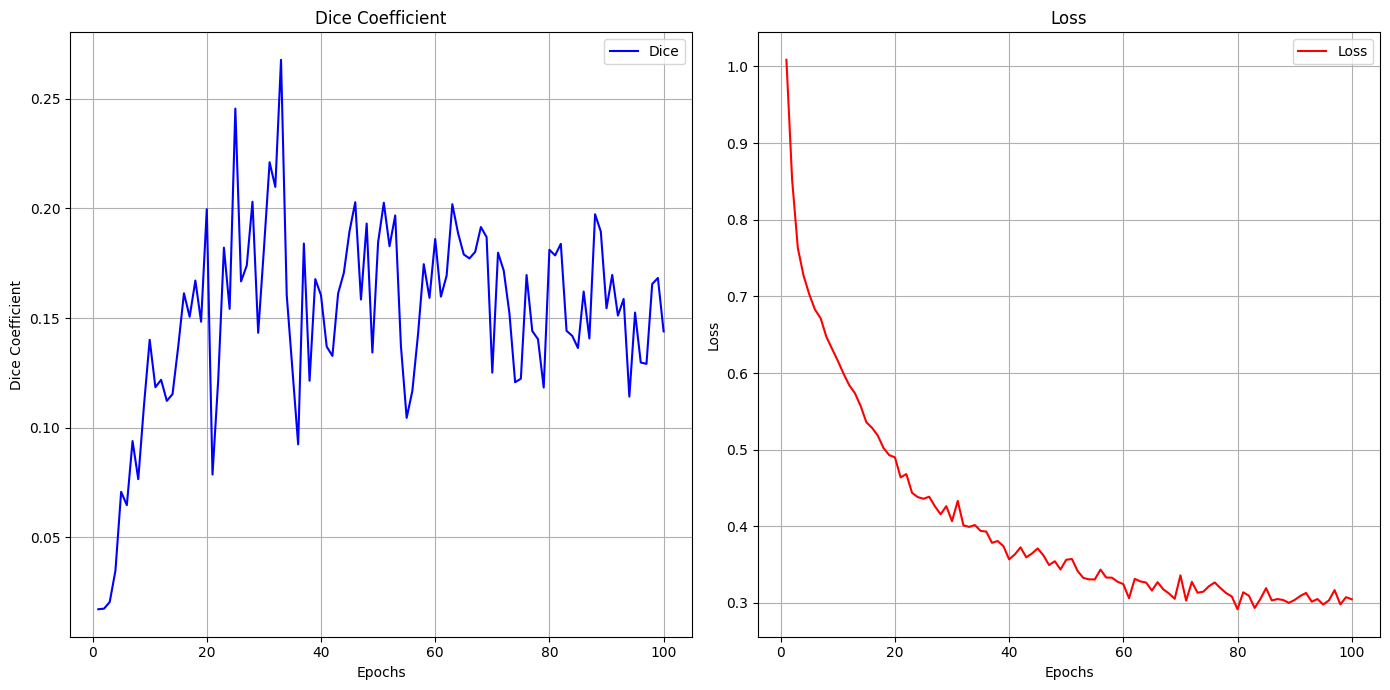

In [9]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()